In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display, display_html, HTML

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [2]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [3]:
imdb_data_folder = BES_data_folder + "imdb_data" + os.sep

In [4]:
from imdb import IMDb
ia = IMDb()

In [5]:
the_matrix = ia.get_movie('0133093')
print(the_matrix['director'])

[<Person id:0905154[http] name:_Wachowski, Lana_>, <Person id:0905152[http] name:_Wachowski, Lilly_>]


In [6]:
print(ia.get_movie_infoset())

['airing', 'akas', 'alternate versions', 'awards', 'connections', 'crazy credits', 'critic reviews', 'episodes', 'external reviews', 'external sites', 'faqs', 'full credits', 'goofs', 'keywords', 'locations', 'main', 'misc sites', 'news', 'official sites', 'parents guide', 'photo sites', 'plot', 'quotes', 'release dates', 'release info', 'reviews', 'sound clips', 'soundtrack', 'synopsis', 'taglines', 'technical', 'trivia', 'tv schedule', 'video clips', 'vote details']


In [7]:
movie_metadata = pd.read_csv(imdb_data_folder+ "movie_metadata.csv")

In [8]:
movie_metadata

color       director_name  num_critic_for_reviews  duration  \
0                Color       James Cameron                   723.0     178.0   
1                Color      Gore Verbinski                   302.0     169.0   
2                Color          Sam Mendes                   602.0     148.0   
3                Color   Christopher Nolan                   813.0     164.0   
4                  NaN         Doug Walker                     NaN       NaN   
5                Color      Andrew Stanton                   462.0     132.0   
6                Color           Sam Raimi                   392.0     156.0   
7                Color        Nathan Greno                   324.0     100.0   
8                Color         Joss Whedon                   635.0     141.0   
9                Color         David Yates                   375.0     153.0   
10               Color         Zack Snyder                   673.0     183.0   
11               Color        Bryan Singer                   434.0     169.0   
12               Color        Marc Forster                   403.0     106.0   
13               Color      Gore Verbinski                   313.0     151.0   
14               Color      Gore Verbinski                   450.0     150.0   
15               Color         Zack Snyder                   733.0     143.0   
16               Color      Andrew Adamson                   258.0     150.0   
17               Color         Joss Whedon                   703.0     173.0   
18               Color        Rob Marshall                   448.0     136.0   
19               Color    Barry Sonnenfeld                   451.0     106.0   
20               Color       Peter Jackson                   422.0     164.0   
21               Color           Marc Webb                   599.0     153.0   
22               Color        Ridley Scott                   343.0     156.0   
23               Color       Peter Jackson                   509.0     186.0   
24               Color         Chris Weitz                   251.0     113.0   
25               Color       Peter Jackson                   446.0     201.0   
26               Color       James Cameron                   315.0     194.0   
27               Color       Anthony Russo                   516.0     147.0   
28               Color          Peter Berg                   377.0     131.0   
29               Color     Colin Trevorrow                   644.0     124.0   
...                ...                 ...                     ...       ...   
5013             Color          Eric Eason                    28.0      79.0   
5014             Color            Uwe Boll                    58.0      80.0   
5015   Black and White   Richard Linklater                    61.0     100.0   
5016             Color     Joseph Mazzella                     NaN      90.0   
5017             Color        Travis Legge                     1.0      90.0   
5018             Color       Alex Kendrick                     5.0     120.0   
5019             Color       Marcus Nispel                    43.0      91.0   
5020               NaN     Brandon Landers                     NaN     143.0   
5021             Color         Jay Duplass                    51.0      85.0   
5022   Black and White          Jim Chuchu                     6.0      60.0   
5023             Color          Daryl Wein                    22.0      88.0   
5024             Color         Jason Trost                    42.0      78.0   
5025             Color         John Waters                    73.0     108.0   
5026             Color     Olivier Assayas                    81.0     110.0   
5027             Color        Jafar Panahi                    64.0      90.0   
5028   Black and White       Ivan Kavanagh                    12.0      83.0   
5029             Color    Kiyoshi Kurosawa                    78.0     111.0   
5030             Color        Tadeo Garcia                     NaN      84.0   
5031             

In [9]:
movie_metadata.describe()

# what doesn't look like a reasonable-ish ordinal variable here?
# aspect_ratio?
# title_year?
# duration?



num_critic_for_reviews     duration  director_facebook_likes  \
count             4993.000000  5028.000000              4939.000000   
mean               140.194272   107.201074               686.509212   
std                121.601675    25.197441              2813.328607   
min                  1.000000     7.000000                 0.000000   
25%                 50.000000    93.000000                 7.000000   
50%                110.000000   103.000000                49.000000   
75%                195.000000   118.000000               194.500000   
max                813.000000   511.000000             23000.000000   

       actor_3_facebook_likes  actor_1_facebook_likes         gross  \
count             5020.000000             5036.000000  4.159000e+03   
mean               645.009761             6560.047061  4.846841e+07   
std               1665.041728            15020.759120  6.845299e+07   
min                  0.000000                0.000000  1.620000e+02   
25%                133.000000              614.000000  5.340988e+06   
50%                371.500000              988.000000  2.551750e+07   
75%                636.000000            11000.000000  6.230944e+07   
max              23000.000000           640000.000000  7.605058e+08   

       num_voted_users  cast_total_facebook_likes  facenumber_in_poster  \
count     5.043000e+03                5043.000000           5030.000000   
mean      8.366816e+04                9699.063851              1.371173   
std       1.384853e+05               18163.799124              2.013576   
min       5.000000e+00                   0.000000              0.000000   
25%       8.593500e+03                1411.000000              0.000000   
50%       3.435900e+04                3090.000000              1.000000   
75%       9.630900e+04               13756.500000              2.000000   
max       1.689764e+06              656730.000000             43.000000   

       num_user_for_reviews        budget   title_year  \
count           5022.000000  4.551000e+03  4935.000000   
mean             272.770808  3.975262e+07  2002.470517   
std              377.982886  2.061149e+08    12.474599   
min                1.000000  2.180000e+02  1916.000000   
25%               65.000000  6.000000e+06  1999.000000   
50%              156.000000  2.000000e+07  2005.000000   
75%              326.000000  4.500000e+07  2011.000000   
max             5060.000000  1.221550e+10  2016.000000   

       actor_2_facebook_likes   imdb_score  aspect_ratio  movie_facebook_likes  
count             5030.000000  5043.000000   4714.000000           5043.000000  
mean              1651.754473     6.442138      2.220403           7525.964505  
std               4042.438863     1.125116      1.385113          19320.445110  
min                  0.000000     1.600000      1.180000              0.000000  
25%                281.000000     5.800000      1.850000              0.000000  
50%                595.000000     6.600000      2.350000            166.000000  
75%                918.000000     7.200000      2.350000           3000.000000  
max             137000.000000     9.500000     16.000000         349000.000000

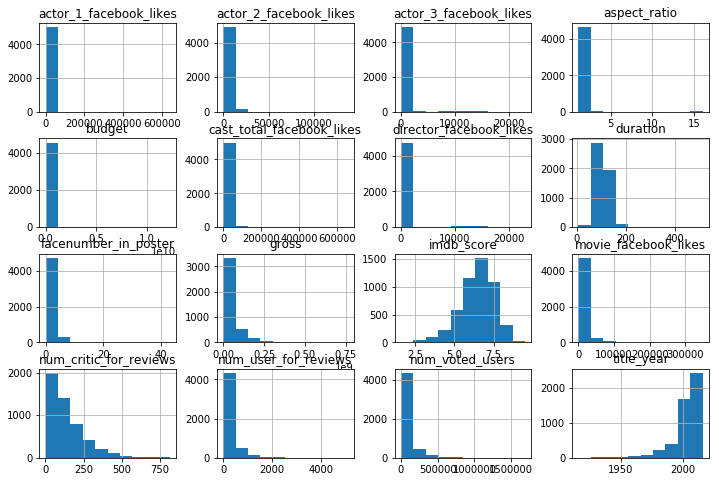

In [10]:
# long-tails-a-go-go!
# aspect_ratio looks
movie_metadata.hist(figsize =(12,8));

In [11]:
movie_metadata.describe(include='all')

color     director_name  num_critic_for_reviews     duration  \
count    5024              4939             4993.000000  5028.000000   
unique      2              2398                     NaN          NaN   
top     Color  Steven Spielberg                     NaN          NaN   
freq     4815                26                     NaN          NaN   
mean      NaN               NaN              140.194272   107.201074   
std       NaN               NaN              121.601675    25.197441   
min       NaN               NaN                1.000000     7.000000   
25%       NaN               NaN               50.000000    93.000000   
50%       NaN               NaN              110.000000   103.000000   
75%       NaN               NaN              195.000000   118.000000   
max       NaN               NaN              813.000000   511.000000   

        director_facebook_likes  actor_3_facebook_likes    actor_2_name  \
count               4939.000000             5020.000000            5030   
unique                      NaN                     NaN            3032   
top                         NaN                     NaN  Morgan Freeman   
freq                        NaN                     NaN              20   
mean                 686.509212              645.009761             NaN   
std                 2813.328607             1665.041728             NaN   
min                    0.000000                0.000000             NaN   
25%                    7.000000              133.000000             NaN   
50%                   49.000000              371.500000             NaN   
75%                  194.500000              636.000000             NaN   
max                23000.000000            23000.000000             NaN   

        actor_1_facebook_likes         gross genres         ...           \
count              5036.000000  4.159000e+03   5043         ...            
unique                     NaN           NaN    914         ...            
top                        NaN           NaN  Drama         ...            
freq                       NaN           NaN    236         ...            
mean               6560.047061  4.846841e+07    NaN         ...            
std               15020.759120  6.845299e+07    NaN         ...            
min                   0.000000  1.620000e+02    NaN         ...            
25%                 614.000000  5.340988e+06    NaN         ...            
50%                 988.000000  2.551750e+07    NaN         ...            
75%               11000.000000  6.230944e+07    NaN         ...            
max              640000.000000  7.605058e+08    NaN         ...            

       num_user_for_reviews language  country  content_rating        budget  \
count           5022.000000     5031     5038            4740  4.551000e+03   
unique                  NaN       47       65              18           NaN   
top                     NaN  English      USA               R           NaN   
freq                    NaN     4704     3807            2118           NaN   
mean             272.770808      NaN      NaN             NaN  3.975262e+07   
std              377.982886      NaN      NaN             NaN  2.061149e+08   
min                1.000000      NaN      NaN             NaN  2.180000e+02   
25%               65.000000      NaN      NaN             NaN  6.000000e+06   
50%              156.000000      NaN      NaN             NaN  2.000000e+07   
75%              326.000000      NaN      NaN             NaN  4.500000e+07   
max             5060.000000      NaN      NaN             NaN  1.221550e+10   

         title_year actor_2_facebook_likes   imdb_score  aspect_ratio  \
count   4935.000000            5030.000000  5043.000000   4714.000000   
unique          NaN                    NaN          NaN           NaN   
top             NaN                    NaN          NaN           NaN   
freq            NaN                    NaN          NaN           NaN   
mean    2002.47

In [12]:
# I'm torn - feels like this should be categorical
movie_metadata["aspect_ratio"].value_counts().sort_index()

1.18        1
1.20        1
1.33       68
1.37      100
1.44        1
1.50        2
1.66       64
1.75        3
1.77        1
1.78      110
1.85     1906
1.89        1
2.00        5
2.20       15
2.24        1
2.35     2360
2.39       15
2.40        3
2.55        2
2.76        3
4.00        7
16.00      45
Name: aspect_ratio, dtype: int64

In [13]:
movie_metadata.dtypes.value_counts()

float64    13
object     12
int64       3
dtype: int64

In [14]:
movie_metadata_cleaned = movie_metadata[movie_metadata.columns[movie_metadata.dtypes != "object"]].copy()

In [15]:
movie_metadata[movie_metadata.columns[movie_metadata.dtypes=="object"]].describe()
# 



color     director_name    actor_2_name genres    actor_1_name  \
count    5024              4939            5030   5043            5036   
unique      2              2398            3032    914            2097   
top     Color  Steven Spielberg  Morgan Freeman  Drama  Robert De Niro   
freq     4815                26              20    236              49   

                      movie_title actor_3_name   plot_keywords  \
count                        5043         5020            4890   
unique                       4917         3521            4760   
top     The Fast and the Furious    John Heard  based on novel   
freq                            3            8               4   

                                          movie_imdb_link language country  \
count                                                5043     5031    5038   
unique                                               4919       47      65   
top     http://www.imdb.com/title/tt3332064/?ref_=fn_t...  English     USA   
freq                                                    3     4704    3807   

       content_rating  
count            4740  
unique             18  
top                 R  
freq             2118

In [16]:
# director_name	actor_2_name	actor_1_name	movie_title	actor_3_name

# index to drop in more info about actors ...
# -> dummy top 10?


In [17]:
movie_metadata["genres"].value_counts()

Drama                                                              236
Comedy                                                             209
Comedy|Drama                                                       191
Comedy|Drama|Romance                                               187
Comedy|Romance                                                     158
Drama|Romance                                                      152
Crime|Drama|Thriller                                               101
Horror                                                              71
Action|Crime|Drama|Thriller                                         68
Action|Crime|Thriller                                               65
Drama|Thriller                                                      64
Crime|Drama                                                         63
Horror|Thriller                                                     56
Crime|Drama|Mystery|Thriller                                        55
Comedy

In [18]:
# [movie_metadata["genres"].value_counts().split("|")]

genre_list = list(set([y for x in [x.split("|") for x in movie_metadata["genres"].value_counts().index] for y in x]))



genre_df = pd.DataFrame({genre: movie_metadata["genres"].apply(lambda x: x.split("|")).apply(lambda x: genre in x) for genre in genre_list})
genre_list = genre_df.sum().sort_values(ascending=False)[genre_df.sum().sort_values(ascending=False)>10].index


In [19]:
plot_keywords = list(set([y for x in [x.split("|") for x in movie_metadata["plot_keywords"].value_counts().index] for y in x]))


pk_df = pd.DataFrame({pk: movie_metadata["plot_keywords"].dropna().apply(lambda x: x.split("|")).apply(lambda x: pk in x) for pk in plot_keywords})
#
# pk_df

In [20]:
plot_keyword_list = pk_df.sum().sort_values(ascending=False).head(50).index

In [21]:
top_10_content_ratings = movie_metadata["content_rating"].value_counts().index[0:10]
top_10_countries = movie_metadata["country"].value_counts().index[0:10]
top_10_languages = movie_metadata["language"].value_counts().index[0:10]
top_10_actors = movie_metadata[["actor_2_name","actor_1_name","actor_3_name"]].stack().value_counts().index[0:10]
top_10_directors = movie_metadata["director_name"].value_counts().index[0:10]

In [22]:
# movie_metadata["director_name"].value_counts()[movie_metadata["director_name"].value_counts()>1]

In [23]:
movie_metadata_cleaned["Black and White"] = (movie_metadata["color"]==" Black and White")
movie_metadata_cleaned["Black and White"][movie_metadata["color"].isnull()] = np.nan
# movie_metadata_cleaned["Black and White"].value_counts(dropna=False)

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
convert_list = {"content_rating": top_10_content_ratings,
                "country": top_10_countries,
                "language": top_10_languages,
#                 "actor_names": top_10_actors,
                "director_name": top_10_directors,
                "plot_keywords": plot_keyword_list,
                "genres": genre_list}

In [25]:
top_list = top_10_content_ratings
col = "content_rating"
for col in convert_list.keys():
    df = pd.DataFrame({col+"_"+pk: movie_metadata[col].dropna().apply(lambda x: x.split("|")).apply(lambda x: pk in x) for pk in convert_list[col]})
    df[col+"_"+"other"] = (~df.any(axis=1))
    movie_metadata_cleaned[df.columns] = df

col="actor_names"
df = pd.DataFrame({col+"_"+pk: (movie_metadata["actor_2_name"]+"|"+ movie_metadata["actor_1_name"]+"|" +movie_metadata["actor_3_name"]).dropna().apply(lambda x: x.split("|")).apply(lambda x: pk in x) for pk in top_10_actors})
df[col+"_"+"other"] = (~df.any(axis=1))
movie_metadata_cleaned[df.columns] = df    

In [26]:
movie_metadata_cleaned.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews',
       ...
       'actor_names_Morgan Freeman', 'actor_names_Johnny Depp',
       'actor_names_Bruce Willis', 'actor_names_Matt Damon',
       'actor_names_Steve Buscemi', 'actor_names_Brad Pitt',
       'actor_names_Bill Murray', 'actor_names_Nicolas Cage',
       'actor_names_Liam Neeson', 'actor_names_other'],
      dtype='object', length=145)

In [27]:
# color -> replace with "black&white"
movie_metadata["color"].value_counts()

Color               4815
 Black and White     209
Name: color, dtype: int64

In [28]:
movie_metadata["color"].value_counts(dropna=False)

Color               4815
 Black and White     209
NaN                   19
Name: color, dtype: int64

In [29]:
# movie_metadata["genres"].value_counts()
# 


# we should dummy this back into categories?
# (unless is really about combinations??)

# similar thing with "plot keywords"

# movie_title/movie_imdb_link

# 

In [30]:
# movie_metadata["plot_keywords"].value_counts()

In [31]:
movie_metadata_cleaned.describe(include="all")

num_critic_for_reviews     duration  director_facebook_likes  \
count              4993.000000  5028.000000              4939.000000   
unique                     NaN          NaN                      NaN   
top                        NaN          NaN                      NaN   
freq                       NaN          NaN                      NaN   
mean                140.194272   107.201074               686.509212   
std                 121.601675    25.197441              2813.328607   
min                   1.000000     7.000000                 0.000000   
25%                  50.000000    93.000000                 7.000000   
50%                 110.000000   103.000000                49.000000   
75%                 195.000000   118.000000               194.500000   
max                 813.000000   511.000000             23000.000000   

        actor_3_facebook_likes  actor_1_facebook_likes         gross  \
count              5020.000000             5036.000000  4.159000e+03   
unique                     NaN                     NaN           NaN   
top                        NaN                     NaN           NaN   
freq                       NaN                     NaN           NaN   
mean                645.009761             6560.047061  4.846841e+07   
std                1665.041728            15020.759120  6.845299e+07   
min                   0.000000                0.000000  1.620000e+02   
25%                 133.000000              614.000000  5.340988e+06   
50%                 371.500000              988.000000  2.551750e+07   
75%                 636.000000            11000.000000  6.230944e+07   
max               23000.000000           640000.000000  7.605058e+08   

        num_voted_users  cast_total_facebook_likes  facenumber_in_poster  \
count      5.043000e+03                5043.000000           5030.000000   
unique              NaN                        NaN                   NaN   
top                 NaN                        NaN                   NaN   
freq                NaN                        NaN                   NaN   
mean       8.366816e+04                9699.063851              1.371173   
std        1.384853e+05               18163.799124              2.013576   
min        5.000000e+00                   0.000000              0.000000   
25%        8.593500e+03                1411.000000              0.000000   
50%        3.435900e+04                3090.000000              1.000000   
75%        9.630900e+04               13756.500000              2.000000   
max        1.689764e+06              656730.000000             43.000000   

        num_user_for_reviews        ...         actor_names_Morgan Freeman  \
count            5022.000000        ...                               5020   
unique                   NaN        ...                                  2   
top                      NaN        ...                              False   
freq                     NaN        ...                               4973   
mean              272.770808        ...                                NaN   
std               377.982886        ...                                NaN   
min                 1.000000        ...                                NaN   
25%                65.000000        ...                                NaN   
50%               156.000000        ...                                NaN   
75%               326.000000        ...                                NaN   
max              5060.000000        ...                                NaN   

        actor_names_Johnny Depp  actor_names_Bruce Willis  \
count                      5020                      5020   
unique                        2                         2   
top                       False                     False   
freq                       4979                      4980   
mean                        NaN                       NaN   
std                         NaN                       NaN   
m

In [148]:
movie_metadata_cleaned = movie_metadata_cleaned.astype('float')
movie_metadata_cleaned.describe()

num_critic_for_reviews     duration  director_facebook_likes  \
count             4993.000000  5028.000000              4939.000000   
mean               140.194272   107.201074               686.509212   
std                121.601675    25.197441              2813.328607   
min                  1.000000     7.000000                 0.000000   
25%                 50.000000    93.000000                 7.000000   
50%                110.000000   103.000000                49.000000   
75%                195.000000   118.000000               194.500000   
max                813.000000   511.000000             23000.000000   

       actor_3_facebook_likes  actor_1_facebook_likes         gross  \
count             5020.000000             5036.000000  4.159000e+03   
mean               645.009761             6560.047061  4.846841e+07   
std               1665.041728            15020.759120  6.845299e+07   
min                  0.000000                0.000000  1.620000e+02   
25%                133.000000              614.000000  5.340988e+06   
50%                371.500000              988.000000  2.551750e+07   
75%                636.000000            11000.000000  6.230944e+07   
max              23000.000000           640000.000000  7.605058e+08   

       num_voted_users  cast_total_facebook_likes  facenumber_in_poster  \
count     5.043000e+03                5043.000000           5030.000000   
mean      8.366816e+04                9699.063851              1.371173   
std       1.384853e+05               18163.799124              2.013576   
min       5.000000e+00                   0.000000              0.000000   
25%       8.593500e+03                1411.000000              0.000000   
50%       3.435900e+04                3090.000000              1.000000   
75%       9.630900e+04               13756.500000              2.000000   
max       1.689764e+06              656730.000000             43.000000   

       num_user_for_reviews        ...          actor_names_Morgan Freeman  \
count           5022.000000        ...                         5020.000000   
mean             272.770808        ...                            0.009363   
std              377.982886        ...                            0.096316   
min                1.000000        ...                            0.000000   
25%               65.000000        ...                            0.000000   
50%              156.000000        ...                            0.000000   
75%              326.000000        ...                            0.000000   
max             5060.000000        ...                            1.000000   

       actor_names_Johnny Depp  actor_names_Bruce Willis  \
count              5020.000000               5020.000000   
mean                  0.008167                  0.007968   
std                   0.090012                  0.088917   
min                   0.000000                  0.000000   
25%                   0.000000                  0.000000   
50%                   0.000000                  0.000000   
75%                   0.000000                  0.000000   
max                   1.000000                  1.000000   

       actor_names_Matt Damon  actor_names_Steve Buscemi  \
count             5020.000000                5020.000000   
mean                 0.007371                   0.007371   
std                  0.085543                   0.085543   
min                  0.000000                   0.000000   
25%                  0.000000                   0.000000   
50%                  0.000000                   0.000000   
75%                  0.000000                   0.000000   
max                  1.000000                   1.000000   

       actor_names_Liam Neeson  actor_names_Brad Pitt  \
count              5020.000000            5020.000000   
mean                  0.006773               0.006773   
std                   0.082027               0.082027   
min                   0.000000        

In [32]:
movie_metadata_cleaned.isnull().sum().sort_values(ascending=False)

gross                            884
budget                           492
aspect_ratio                     329
content_rating_TV-MA             303
content_rating_G                 303
content_rating_other             303
content_rating_TV-PG             303
content_rating_TV-14             303
content_rating_Approved          303
content_rating_Unrated           303
content_rating_Not Rated         303
content_rating_PG                303
content_rating_PG-13             303
content_rating_R                 303
plot_keywords_female nudity      153
plot_keywords_detective          153
plot_keywords_serial killer      153
plot_keywords_sex                153
plot_keywords_box office flop    153
plot_keywords_rescue             153
plot_keywords_teenager           153
plot_keywords_revenge            153
plot_keywords_battle             153
plot_keywords_secret             153
plot_keywords_vomiting           153
plot_keywords_lawyer             153
plot_keywords_escape             153
p

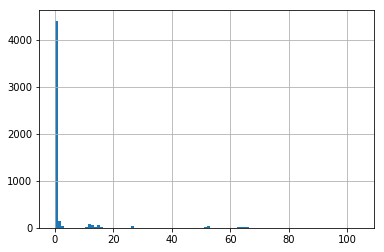

In [33]:
movie_metadata_cleaned.isnull().sum(axis=1).hist(bins=100)

In [34]:
(movie_metadata_cleaned.isnull().sum(axis=1)>10).sum()

453

In [35]:
missing_value_rows = (movie_metadata_cleaned.isnull().sum(axis=1)>10)

In [36]:
movie_metadata_cleaned.loc[~missing_value_rows].isnull().sum().sort_values(ascending=False).head(8)

gross                     535
budget                    318
aspect_ratio              160
num_critic_for_reviews     12
facenumber_in_poster       10
Black and White             9
duration                    1
num_user_for_reviews        1
dtype: int64

In [37]:
movie_metadata_cleaned_no_nan = movie_metadata_cleaned.loc[~missing_value_rows].copy()
movie_metadata_cleaned_no_nan = movie_metadata_cleaned_no_nan.fillna(movie_metadata_cleaned_no_nan.median())



In [238]:
movie_metadata_cleaned_no_nan.to_stata(imdb_data_folder+ "movie_metadata_cleaned_no_nan.dta")

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\pandas\io\stata.py:2138: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'Black and White'   ->   Black_and_White
    b'content_rating_PG-13'   ->   content_rating_PG_13
    b'content_rating_Not Rated'   ->   content_rating_Not_Rated
    b'content_rating_TV-14'   ->   content_rating_TV_14
    b'content_rating_TV-MA'   ->   content_rating_TV_MA
    b'content_rating_TV-PG'   ->   content_rating_TV_PG
    b'director_name_Steven Spielberg'   ->   director_name_Steven_Spielberg
    b'director_name_Woody Allen'   ->   director_name_Woody_Allen
    b'director_name_Martin Scorsese'   ->   director_name_Martin_Scorsese
    b'director_name_Clint Eastwood'   ->   director_name_Clint_Eastwood
    b'director_name_Ridley Scott'   ->   director_name_Ridley_Scott
    b'director_name_Tim Burton'   ->   director_name_Tim_Burton
    b'director_name_Spike Lee'   ->

In [173]:
pattern = "imdb_score"
name = "imdb_score"
corr_type = "spearman"
df,corr_type = make_corr_summary(movie_metadata_cleaned_no_nan, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Top 20 positive (spearman) correlations for imdb_score 
 
 
 r 
 p 
 N 
 
 
 num_voted_users 
 0.44 
 0.00 
 4590 
 
 duration 
 0.38 
 0.00 
 4590 
 
 num_user_for_reviews 
 0.36 
 0.00 
 4590 
 
 num_critic_for_reviews 
 0.34 
 0.00 
 4590 
 
 genres_Drama 
 0.31 
 0.00 
 4590 
 
 genres_Biography 
 0.19 
 0.00 
 4590 
 
 Black and White 
 0.16 
 0.00 
 4590 
 
 genres_History 
 0.14 
 0.00 
 4590 
 
 movie_facebook_likes 
 0.14 
 0.00 
 4590 
 
 director_facebook_likes 
 0.14 
 0.00 
 4590 
 
 genres_War 
 0.12 
 0.00 
 4590 
 
 country_UK 
 0.12 
 0.00 
 4590 
 
 genres_Documentary 
 0.11 
 0.00 
 4590 
 
 language_other 
 0.11 
 0.00 
 4590 
 
 content_rating_Approved 
 0.1 
 0.00 
 4590 
 
 country_other 
 0.09 
 0.00 
 4590 
 
 gross 
 0.09 
 0.00 
 4590 
 
 director_name_Steven Spielberg 
 0.08 
 0.00 
 4590 
 
 content_rating_R 
 0.08 
 0.00 
 4590 
 
 director_name_Martin Scorsese 
 0.08 
 0.00 
 4590 
 
 
 Top 20 negative (spearman) correlations for imdb_score 
 
 
 r 
 p 
 N 
 
 
 genres_Comedy 
 -0.2 
 0.00 
 4590 
 
 genres_Horror 
 -0.2 
 0.00 
 4590 
 
 language_English 
 -0.17 
 0.00 
 4590 
 
 title_year 
 -0.15 
 0.00 
 4590 
 
 country_USA 
 -0.13 
 0.00 
 4590 
 
 genres_Action 
 -0.12 
 0.00 
 4590 
 
 content_rating_PG-13 
 -0.12 
 0.00 
 4590 
 
 director_name_other 
 -0.11 
 0.00 
 4590 
 
 plot_keywords_box office flop 
 -0.1 
 0.00 
 4590 
 
 genres_Thriller 
 -0.09 
 0.00 
 4590 
 
 facenumber_in_poster 
 -0.09 
 0.00 
 4590 
 
 actor_names_other 
 -0.07 
 0.00 
 4590 
 
 actor_3_facebook_likes 
 -0.06 
 0.00 
 4590 
 
 genres_Fantasy 
 -0.06 
 0.00 
 4590 
 
 genres_Sci-Fi 
 -0.06 
 0.00 
 4590 
 
 budget 
 -0.06 
 0.00 
 4590 
 
 genres_Family 
 -0.06 
 0.00 
 4590 
 
 plot_keywords_rescue 
 -0.05 
 0.00 
 4590 
 
 plot_keywords_wedding 
 -0.05 
 0.00 
 4590 
 
 plot_keywords_teenager 
 -0.05 
 0.00 
 4590

In [174]:
Treatment = "imdb_project"

In [175]:
# fulldata_withPP - all samples, no columns removed due to NAs, preprocessing for weasel answers
# procdata_withPP - light cleaning
# mostdata_withPP - imputation on reduced set, 2% least filled removed
# lessdata_withPP - imputation on reduced set (% lesast filled), but only retain 2/3 filled out data
# core_withPP - just the representative cross-section core


output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [176]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(movie_metadata_cleaned_no_nan.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = movie_metadata_cleaned_no_nan.columns,
                             index   = movie_metadata_cleaned_no_nan.index      )

In [179]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde


In [216]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = BES_std.shape[1]
n_components = 10
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = movie_metadata_cleaned_no_nan.index)

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\decomposition\factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


Wall time: 1min 14s


In [217]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

average log-likelihood of all samples: -167.55383747741982
number of iterations: 1000


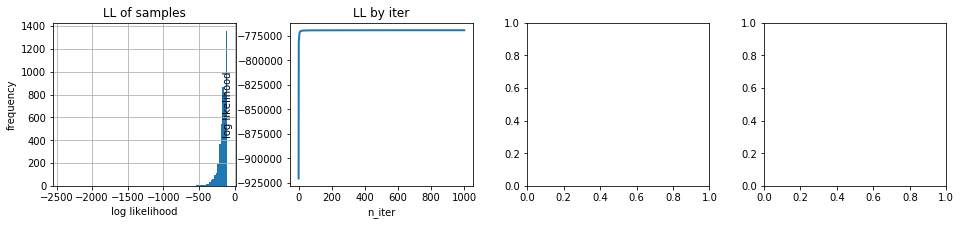

In [218]:
display_pca_data(n_components, decomp, BES_std)

Warning, filename truncated because it was over 30. Filenames may no longer be unique


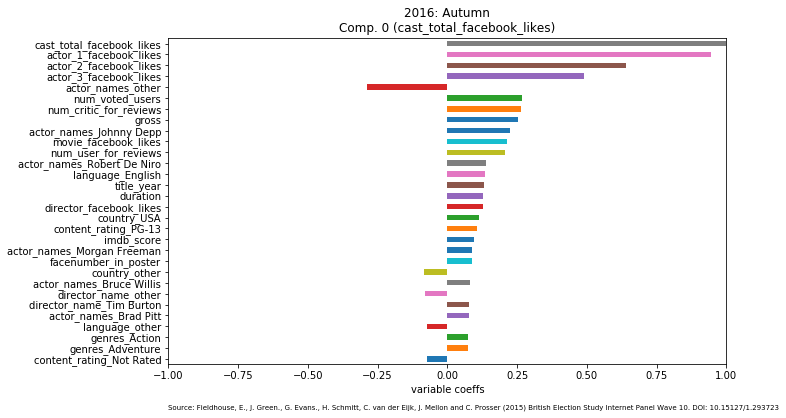

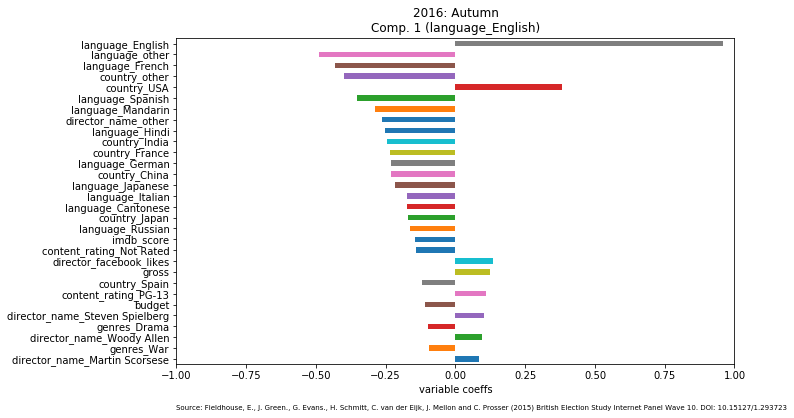

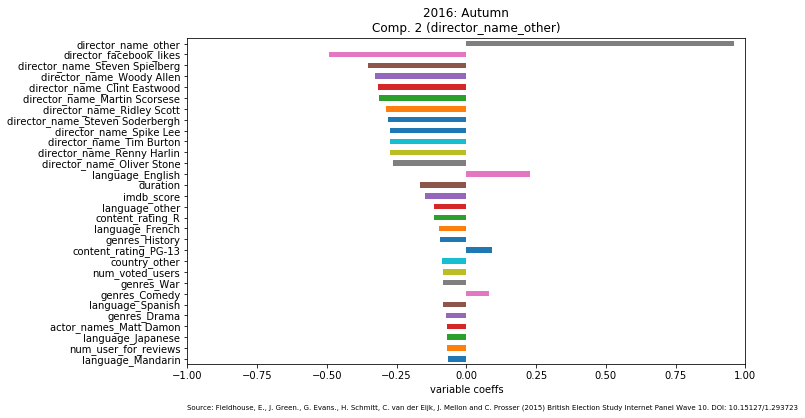

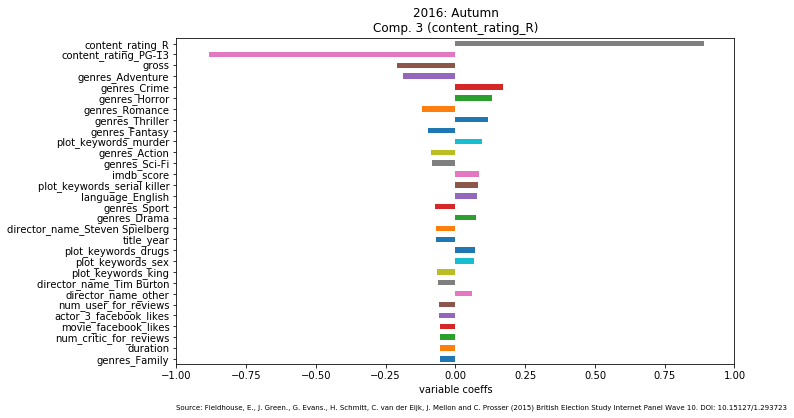

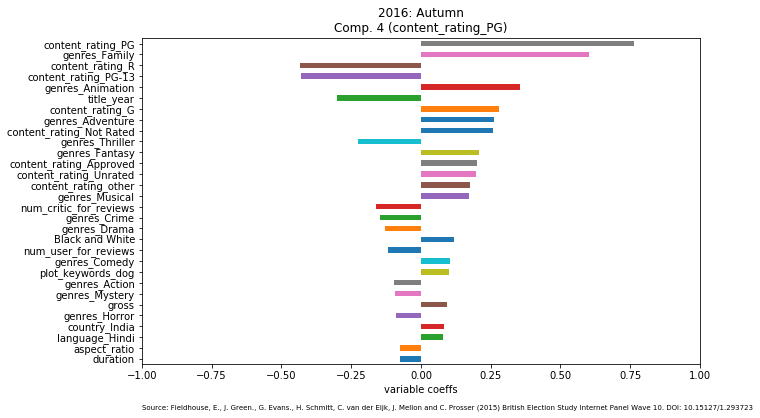

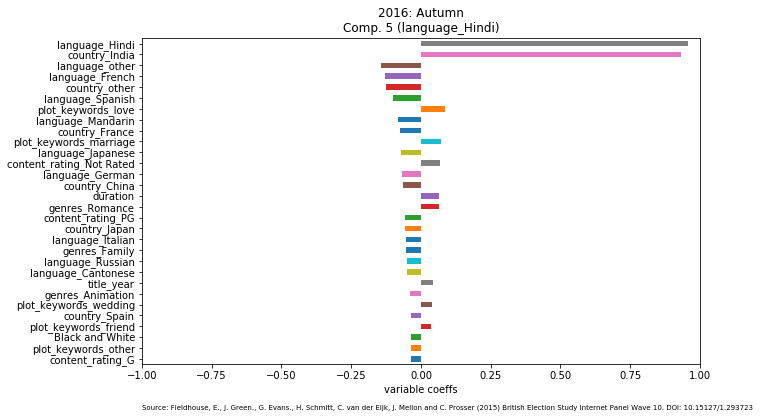

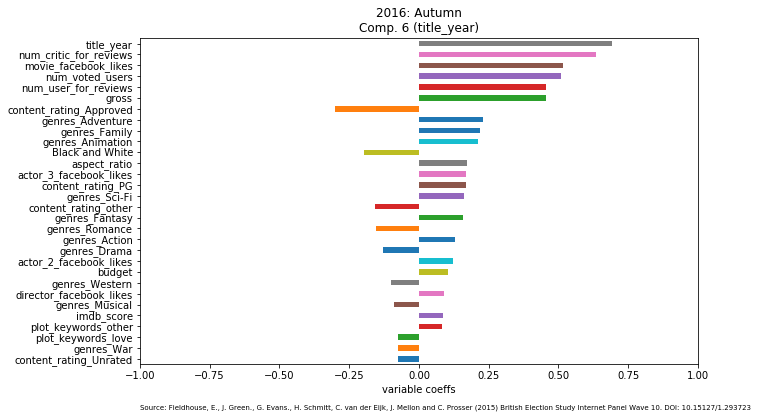

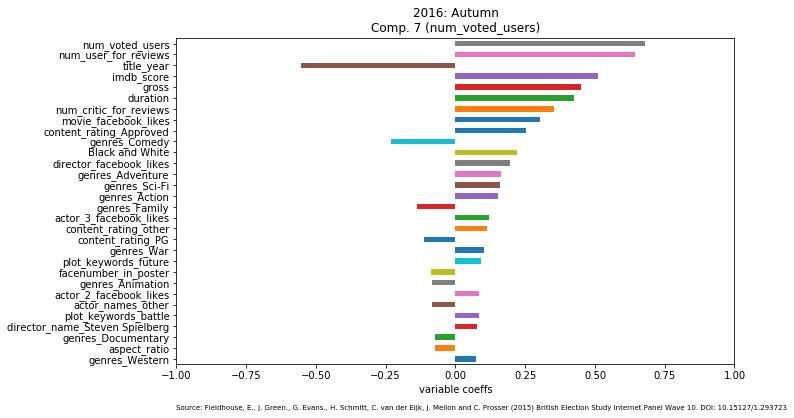

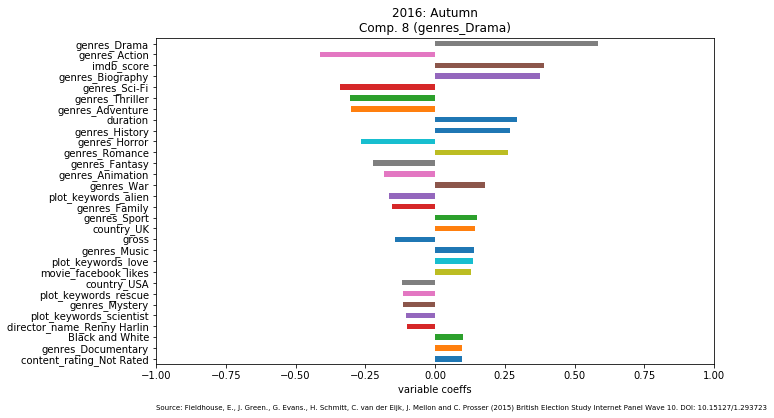

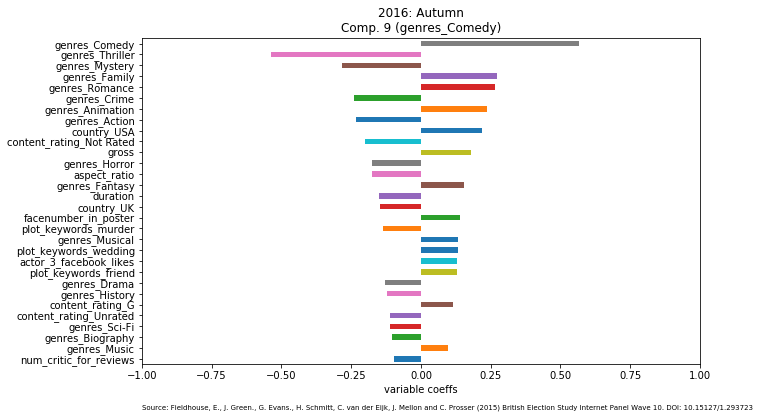

In [221]:
dataset_name = "W10_only"
manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          movie_metadata_cleaned_no_nan.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 10, show_histogram = False)

noise_variance_
genres_other                         1.000000e-12
content_rating_TV-MA                 1.000000e-12
cast_total_facebook_likes            1.539667e-04
language_English                     8.686472e-04
director_name_other                  9.738278e-04
content_rating_PG-13                 2.294530e-03
content_rating_R                     2.329891e-03
language_Hindi                       1.053740e-02
country_India                        6.166005e-02
title_year                           8.913796e-02
actor_1_facebook_likes               9.207073e-02
num_voted_users                      1.860342e-01
num_user_for_reviews                 3.085087e-01
num_critic_for_reviews               3.584210e-01
content_rating_PG                    3.612911e-01
gross                                4.035120e-01
genres_Family                        4.651745e-01
imdb_score                           5.165905e-01
genres_Thriller                      5.443529e-01
actor_2_facebook_likes               5.594929e-01
movie_facebook_likes                 5.682785e-01
genres_Drama                         5.869497e-01
genres_Comedy                        5.956773e-01
duration                             6.486646e-01
director_facebook_likes              6.729971e-01
actor_3_facebook_likes               6.965452e-01
genres_Action                        7.112930e-01
genres_Adventure                     7.161661e-01
language_other                       7.186727e-01
genres_Animation                     7.263332e-01
...                                           ...
plot_keywords_college                9.909183e-01
plot_keywords_drugs                  9.911013e-01
plot_keywords_party                  9.914438e-01
plot_keywords_box office flop        9.915736e-01
plot_keywords_king                   9.920273e-01
plot_keywords_revenge                9.922451e-01
plot_keywords_new york city          9.926713e-01
plot_keywords_money                  9.927416e-01
plot_keywords_writer                 9.928784e-01
plot_keywords_school                 9.930237e-01
country_Germany                      9.936023e-01
plot_keywords_boy                    9.941128e-01
plot_keywords_vomiting               9.941238e-01
plot_keywords_island                 9.945529e-01
plot_keywords_prison                 9.946294e-01
content_rating_TV-14                 9.950349e-01
plot_keywords_female protagonist     9.951694e-01
plot_keywords_female nudity          9.951880e-01
plot_keywords_secret                 9.954493e-01
plot_keywords_texas                  9.954747e-01
actor_names_Nicolas Cage             9.958666e-01
plot_keywords_train                  9.963342e-01
plot_keywords_teenager               9.964217e-01
plot_keywords_lawyer                 9.970170e-01
plot_keywords_hotel                  9.971240e-01
content_rating_TV-PG                 9.971906e-01
plot_keywords_hospital               9.973478e-01
country_Australia                    9.973487e-01
plot_keywords_small town             9.980511e-01
plot_keywords_fight                  9.988871e-01

[145 rows x 1 columns]

noise_variance_
actor_names_Bill Murray             0.990399
actor_names_Brad Pitt               0.982864
actor_names_Bruce Willis            0.985353
actor_names_Johnny Depp             0.944705
actor_names_Liam Neeson             0.989033
actor_names_Matt Damon              0.985167
actor_names_Morgan Freeman          0.984263
actor_names_Nicolas Cage            0.995867
actor_names_Robert De Niro          0.972840
actor_names_Steve Buscemi           0.987734
actor_names_other                   0.900594
aspect_ratio                        0.924835
budget                              0.963398
content_rating_G                    0.900037
content_rating_TV-14                0.995035
content_rating_TV-PG                0.997191
content_rating_Unrated              0.925491
content_rating_other                0.926921
country_Australia                   0.997349
country_Canada                      0.987130
country_China                       0.935291
country_France                      0.924640
country_Germany                     0.993602
country_Japan                       0.954428
country_Spain                       0.978701
country_UK                          0.949410
director_name_Oliver Stone          0.920683
director_name_Renny Harlin          0.904590
director_name_Ridley Scott          0.906000
director_name_Spike Lee             0.913567
...                                      ...
plot_keywords_hospital              0.997348
plot_keywords_hotel                 0.997124
plot_keywords_island                0.994553
plot_keywords_king                  0.992027
plot_keywords_lawyer                0.997017
plot_keywords_love                  0.955437
plot_keywords_marriage              0.979767
plot_keywords_money                 0.992742
plot_keywords_murder                0.961366
plot_keywords_new york city         0.992671
plot_keywords_other                 0.979366
plot_keywords_party                 0.991444
plot_keywords_police                0.982066
plot_keywords_prison                0.994629
plot_keywords_rescue                0.984304
plot_keywords_revenge               0.992245
plot_keywords_school                0.993024
plot_keywords_scientist             0.981529
plot_keywords_secret                0.995449
plot_keywords_serial killer         0.977048
plot_keywords_sex                   0.984193
plot_keywords_singer                0.984538
plot_keywords_small town            0.998051
plot_keywords_teenager              0.996422
plot_keywords_texas                 0.995475
plot_keywords_train                 0.996334
plot_keywords_vampire               0.988008
plot_keywords_vomiting              0.994124
plot_keywords_wedding               0.976515
plot_keywords_writer                0.992878

[96 rows x 1 columns]

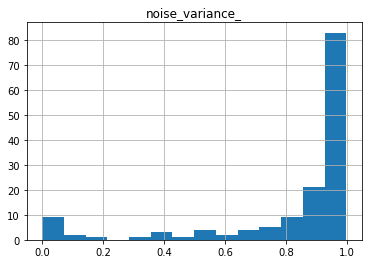

In [222]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [194]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [212]:
def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1

In [196]:
memory_use(locs = locals().items())

                         pk_df:  37.7MiB
                           _48:  37.7MiB
                           _70:  17.2MiB
                          _109:  17.2MiB
                          _118:  17.2MiB
                          _135:  17.2MiB
        movie_metadata_cleaned:   5.6MiB
                          _147:   5.6MiB
                            __:   5.1MiB
                           ___:   5.1MiB


In [197]:
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ), q=10 ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ), q=10 ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)

In [213]:
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False ):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(BES_output_folder,"xgb_census"+Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)


In [234]:
Treatment = "xgboost_imdb_data"
var_stub = "imdb_score"

var_list = ["imdb_score"]
var_stub_list = [var_stub]

# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1



def create_train(drop_other_waves):
    keep_list = movie_metadata_cleaned.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return movie_metadata_cleaned[keep_list]


def create_target(target_var):
    
    return movie_metadata_cleaned[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



[0]	validation_0-rmse:5.75175
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.47314
[2]	validation_0-rmse:5.20831
[3]	validation_0-rmse:4.95812
[4]	validation_0-rmse:4.72007
[5]	validation_0-rmse:4.4945
[6]	validation_0-rmse:4.2807
[7]	validation_0-rmse:4.0769
[8]	validation_0-rmse:3.8832
[9]	validation_0-rmse:3.69998
[10]	validation_0-rmse:3.52681
[11]	validation_0-rmse:3.36305
[12]	validation_0-rmse:3.20686
[13]	validation_0-rmse:3.05851
[14]	validation_0-rmse:2.91865
[15]	validation_0-rmse:2.78662
[16]	validation_0-rmse:2.66137
[17]	validation_0-rmse:2.54252
[18]	validation_0-rmse:2.43081
[19]	validation_0-rmse:2.32393
[20]	validation_0-rmse:2.22319
[21]	validation_0-rmse:2.12841
[22]	validation_0-rmse:2.03888
[23]	validation_0-rmse:1.95403
[24]	validation_0-rmse:1.87347
[25]	validation_0-rmse:1.79776
[26]	validation_0-rmse:1.72639
[27]	validation_0-rmse:1.6598
[28]	validation_0-rmse:1.597
[29]	validation_0-rmse:1.53705
[30]	v

[252]	validation_0-rmse:0.697164
[253]	validation_0-rmse:0.697167
[254]	validation_0-rmse:0.697049
[255]	validation_0-rmse:0.697018
[256]	validation_0-rmse:0.697274
[257]	validation_0-rmse:0.697381
[258]	validation_0-rmse:0.697583
[259]	validation_0-rmse:0.697645
[260]	validation_0-rmse:0.697624
[261]	validation_0-rmse:0.697543
[262]	validation_0-rmse:0.697395
[263]	validation_0-rmse:0.697247
[264]	validation_0-rmse:0.697154
[265]	validation_0-rmse:0.696904
[266]	validation_0-rmse:0.696993
[267]	validation_0-rmse:0.697263
[268]	validation_0-rmse:0.697405
[269]	validation_0-rmse:0.696996
[270]	validation_0-rmse:0.696858
[271]	validation_0-rmse:0.697008
[272]	validation_0-rmse:0.697006
[273]	validation_0-rmse:0.696915
[274]	validation_0-rmse:0.696989
[275]	validation_0-rmse:0.696992
[276]	validation_0-rmse:0.696774
[277]	validation_0-rmse:0.696679
[278]	validation_0-rmse:0.696547
[279]	validation_0-rmse:0.696805
[280]	validation_0-rmse:0.696814
[281]	validation_0-rmse:0.696852
[282]	vali

[501]	validation_0-rmse:0.691125
[502]	validation_0-rmse:0.691152
[503]	validation_0-rmse:0.691202
[504]	validation_0-rmse:0.691116
[505]	validation_0-rmse:0.691143
[506]	validation_0-rmse:0.69121
[507]	validation_0-rmse:0.691422
MSE: 0.48, MAE: 0.47, EV: 0.63, R2: 0.63


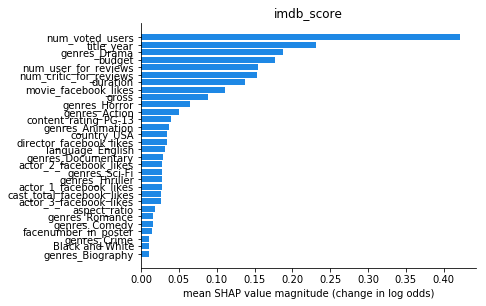

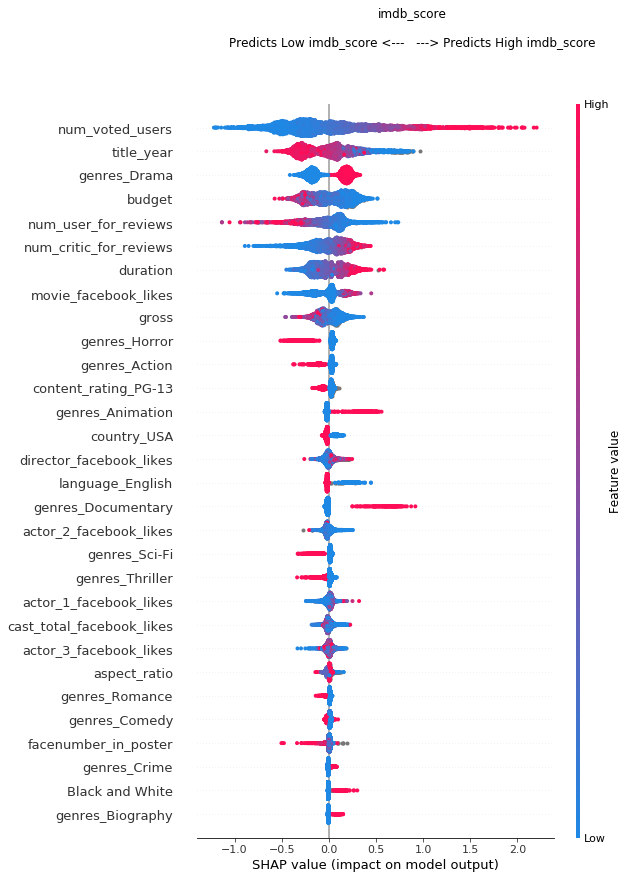

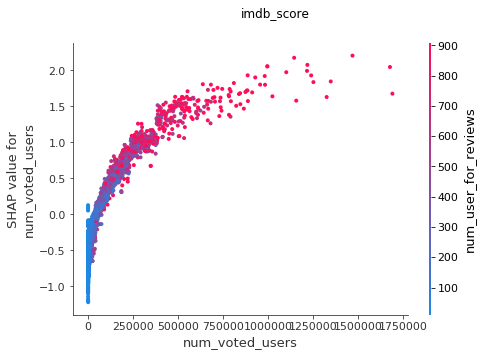

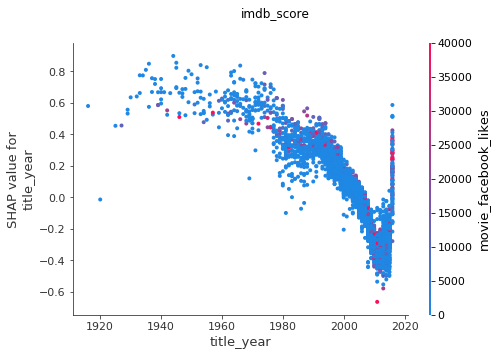

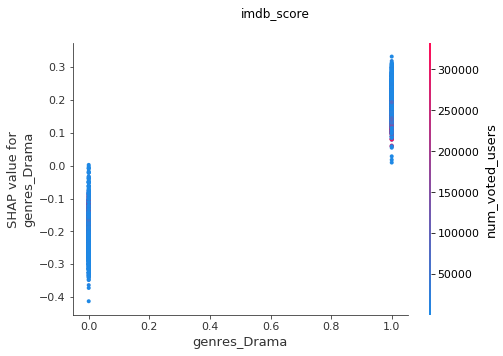

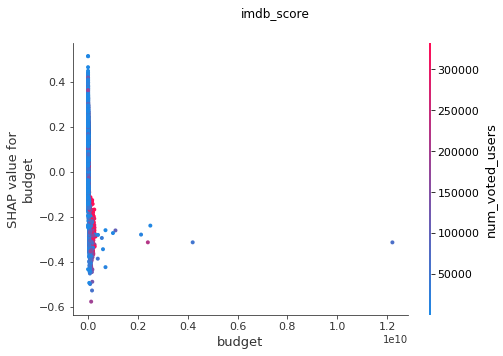

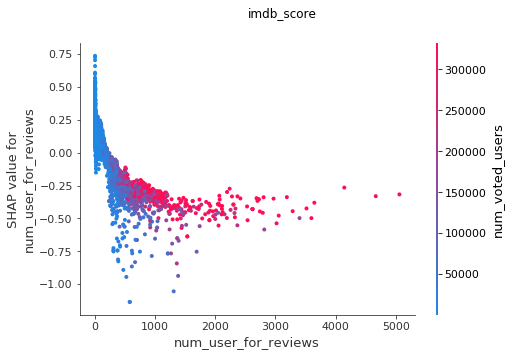

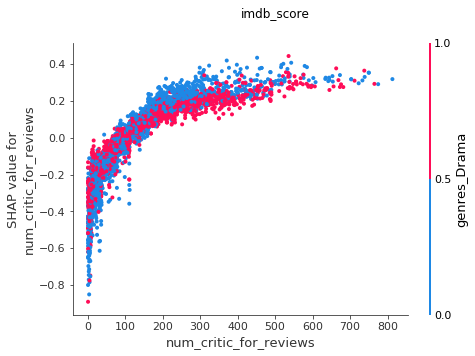

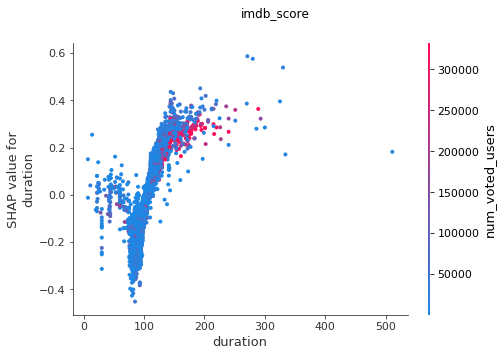

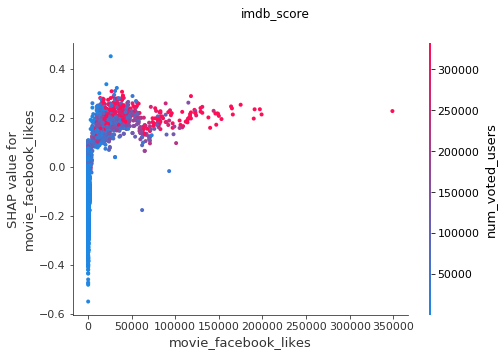

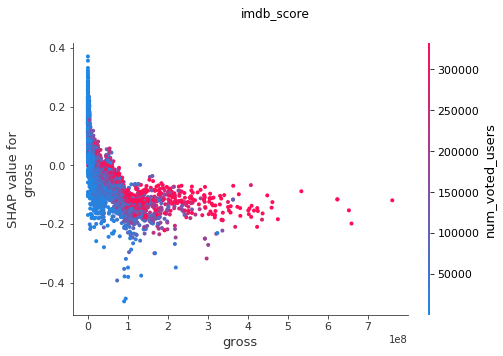

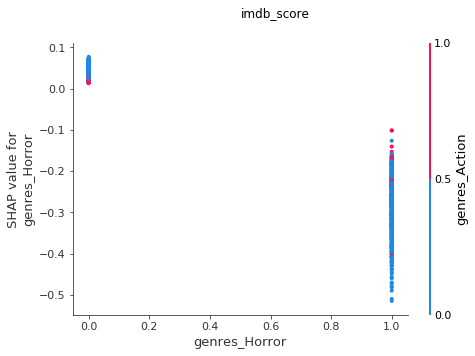

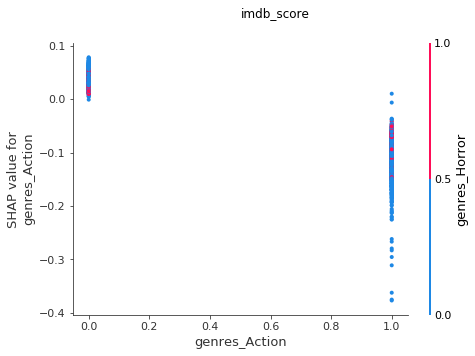

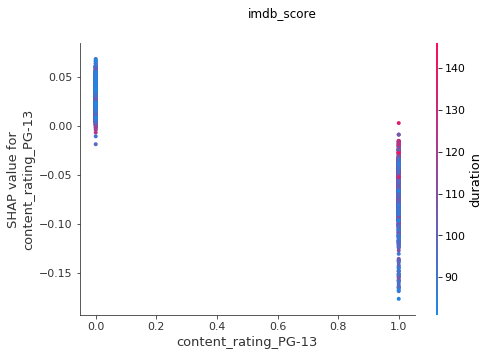

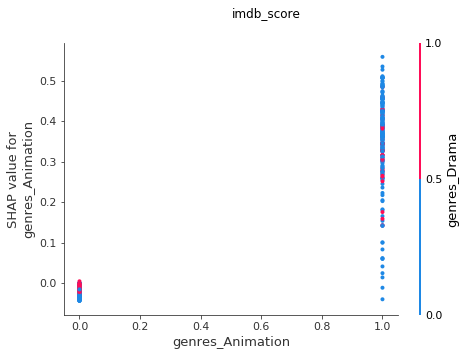

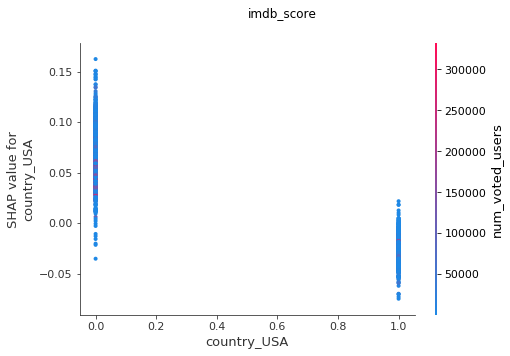

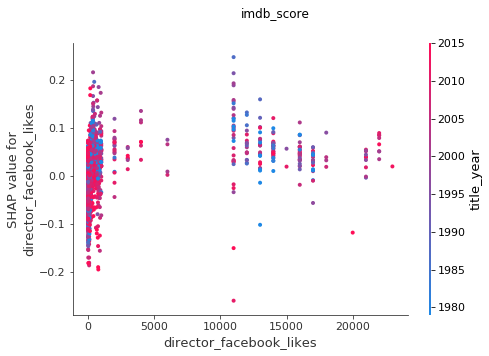

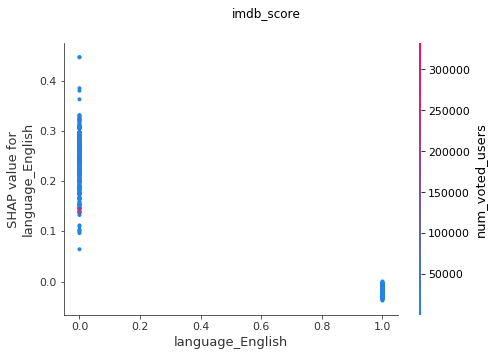

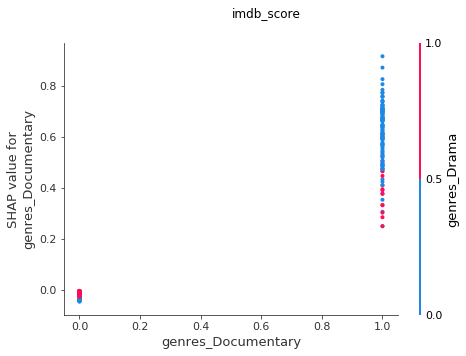

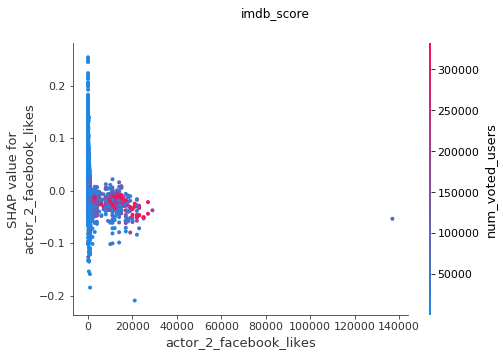

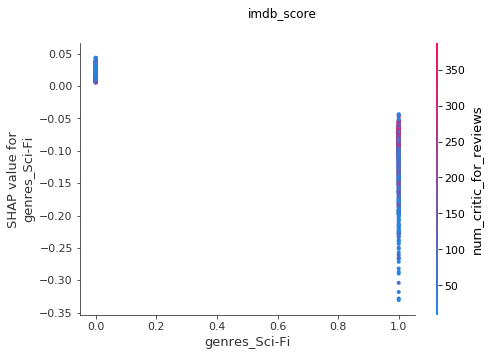

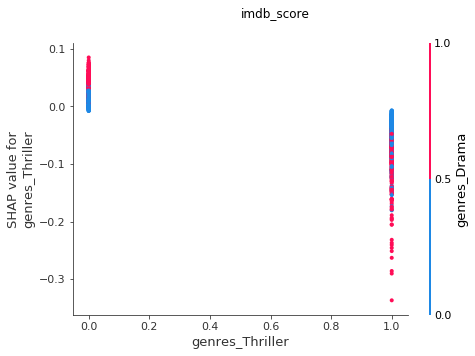

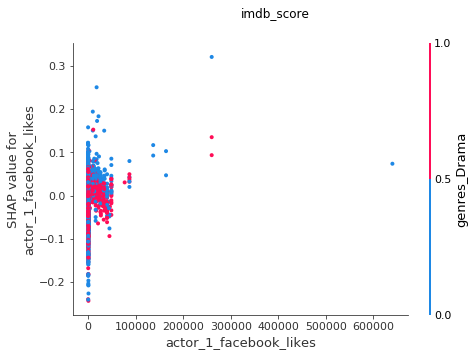

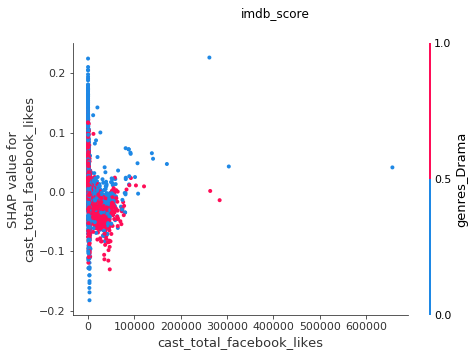

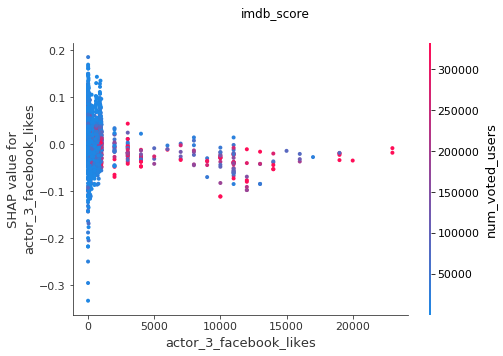

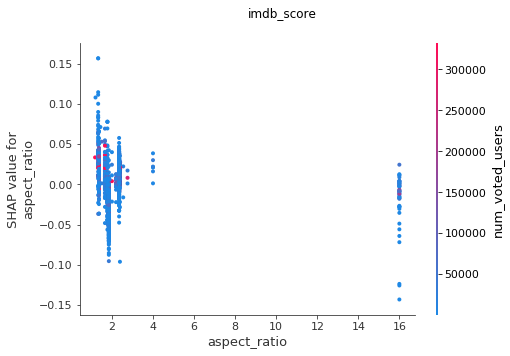

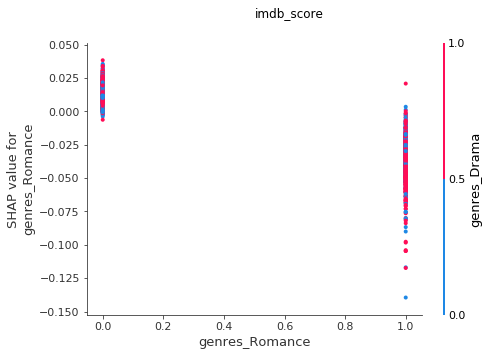

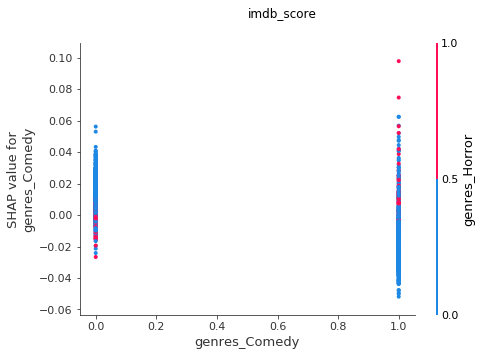

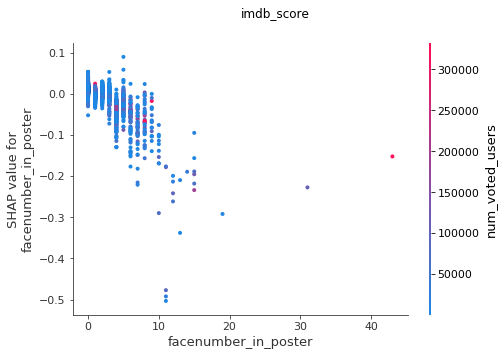

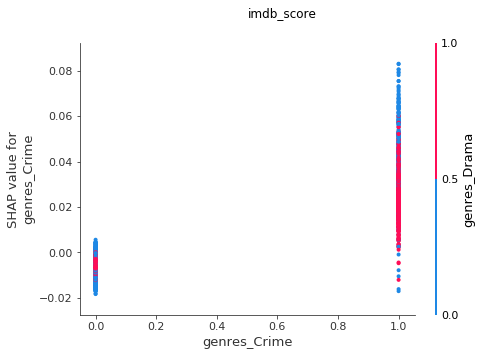

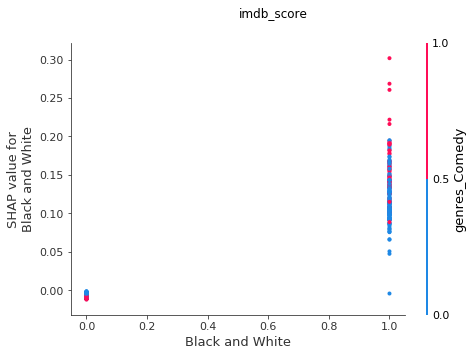

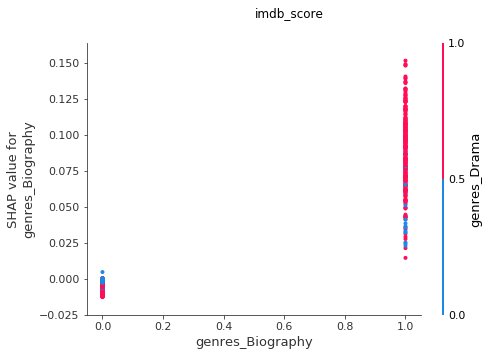

Wall time: 2min 23s


In [235]:
%%time
colname = "imdb_score"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(movie_metadata_cleaned.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)

[0]	validation_0-rmse:5.7526
Will train until validation_0-rmse hasn't improved in 53.1 rounds.
[1]	validation_0-rmse:5.4734
[2]	validation_0-rmse:5.20974
[3]	validation_0-rmse:4.9588
[4]	validation_0-rmse:4.71989
[5]	validation_0-rmse:4.49539
[6]	validation_0-rmse:4.28119
[7]	validation_0-rmse:4.07914
[8]	validation_0-rmse:3.887
[9]	validation_0-rmse:3.70332
[10]	validation_0-rmse:3.53029
[11]	validation_0-rmse:3.36597
[12]	validation_0-rmse:3.20958
[13]	validation_0-rmse:3.06208
[14]	validation_0-rmse:2.92152
[15]	validation_0-rmse:2.78922
[16]	validation_0-rmse:2.66417
[17]	validation_0-rmse:2.54505
[18]	validation_0-rmse:2.43319
[19]	validation_0-rmse:2.32717
[20]	validation_0-rmse:2.22738
[21]	validation_0-rmse:2.13447
[22]	validation_0-rmse:2.04389
[23]	validation_0-rmse:1.95802
[24]	validation_0-rmse:1.87774
[25]	validation_0-rmse:1.80219
[26]	validation_0-rmse:1.72918
[27]	validation_0-rmse:1.66106
[28]	validation_0-rmse:1.59757
[29]	validation_0-rmse:1.53832
[30]	validation_0-

[252]	validation_0-rmse:0.691428
[253]	validation_0-rmse:0.691375
[254]	validation_0-rmse:0.691432
[255]	validation_0-rmse:0.691359
[256]	validation_0-rmse:0.691251
[257]	validation_0-rmse:0.691024
[258]	validation_0-rmse:0.690944
[259]	validation_0-rmse:0.690972
[260]	validation_0-rmse:0.691067
[261]	validation_0-rmse:0.69117
[262]	validation_0-rmse:0.690986
[263]	validation_0-rmse:0.690824
[264]	validation_0-rmse:0.690585
[265]	validation_0-rmse:0.690567
[266]	validation_0-rmse:0.690333
[267]	validation_0-rmse:0.690373
[268]	validation_0-rmse:0.690241
[269]	validation_0-rmse:0.690282
[270]	validation_0-rmse:0.69031
[271]	validation_0-rmse:0.690219
[272]	validation_0-rmse:0.690281
[273]	validation_0-rmse:0.690281
[274]	validation_0-rmse:0.690482
[275]	validation_0-rmse:0.690468
[276]	validation_0-rmse:0.690645
[277]	validation_0-rmse:0.690773
[278]	validation_0-rmse:0.690736
[279]	validation_0-rmse:0.690704
[280]	validation_0-rmse:0.69077
[281]	validation_0-rmse:0.690729
[282]	validat

[502]	validation_0-rmse:0.688811
[503]	validation_0-rmse:0.688823
[504]	validation_0-rmse:0.688766
[505]	validation_0-rmse:0.688785
[506]	validation_0-rmse:0.688765
[507]	validation_0-rmse:0.68874
[508]	validation_0-rmse:0.688728
[509]	validation_0-rmse:0.688717
[510]	validation_0-rmse:0.688727
[511]	validation_0-rmse:0.688764
[512]	validation_0-rmse:0.688688
[513]	validation_0-rmse:0.688671
[514]	validation_0-rmse:0.688687
[515]	validation_0-rmse:0.688709
[516]	validation_0-rmse:0.688685
[517]	validation_0-rmse:0.688675
[518]	validation_0-rmse:0.688677
[519]	validation_0-rmse:0.688657
[520]	validation_0-rmse:0.688628
[521]	validation_0-rmse:0.688641
[522]	validation_0-rmse:0.688618
[523]	validation_0-rmse:0.688661
[524]	validation_0-rmse:0.688695
[525]	validation_0-rmse:0.688706
[526]	validation_0-rmse:0.688706
[527]	validation_0-rmse:0.688676
[528]	validation_0-rmse:0.688647
[529]	validation_0-rmse:0.688608
[530]	validation_0-rmse:0.688621
MSE: 0.47, MAE: 0.47, EV: 0.63, R2: 0.63


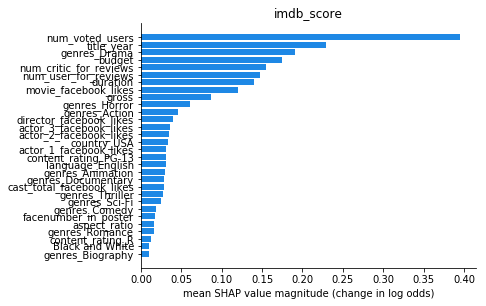

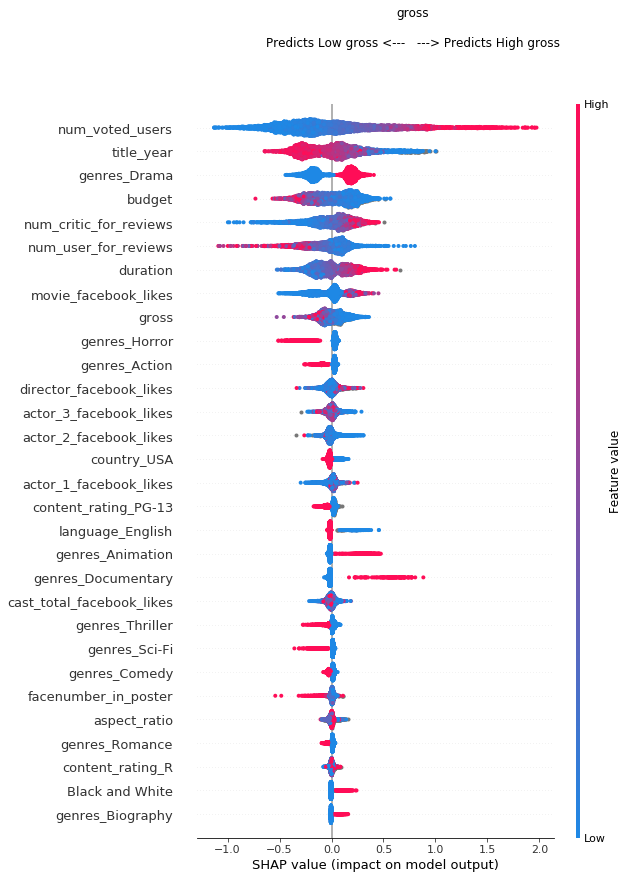

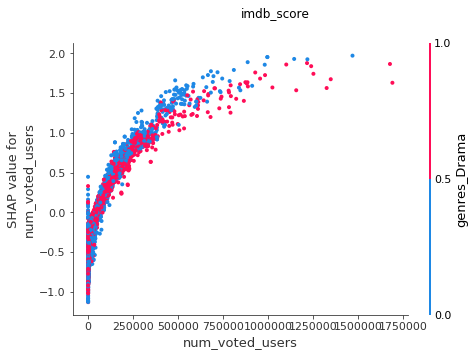

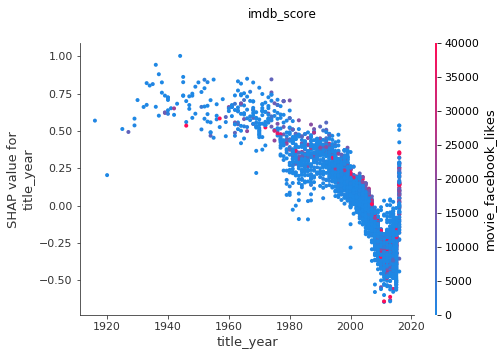

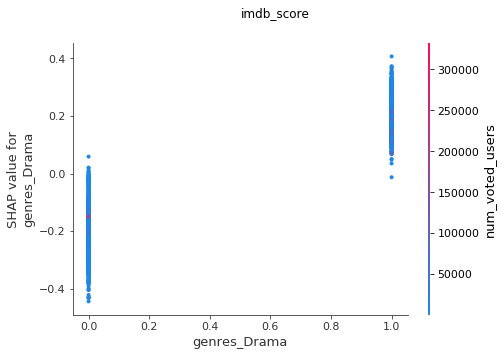

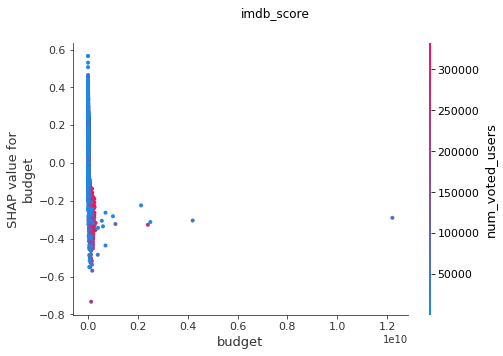

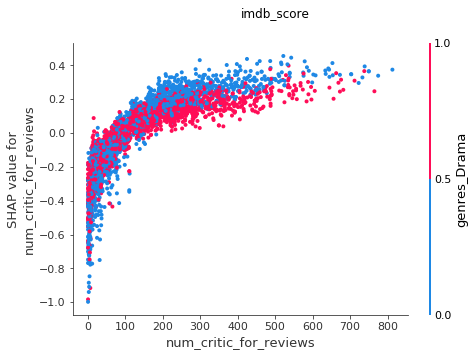

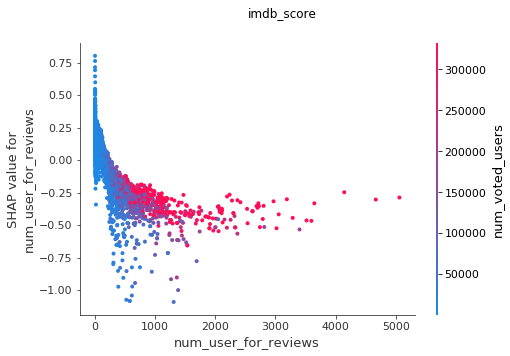

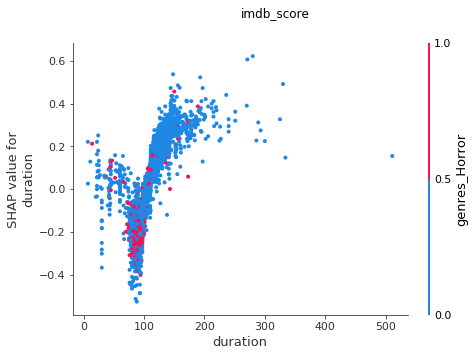

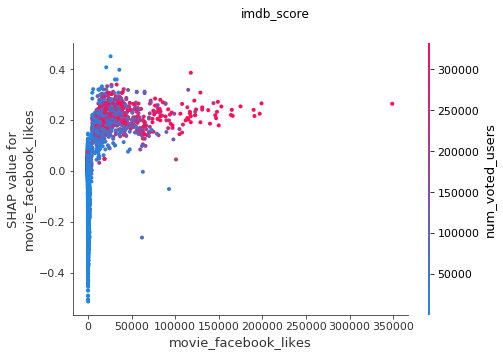

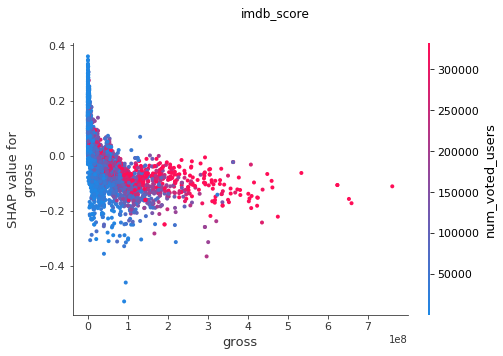

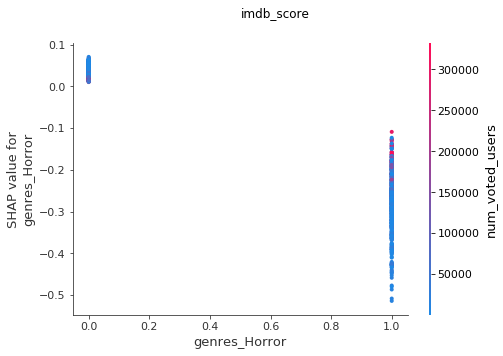

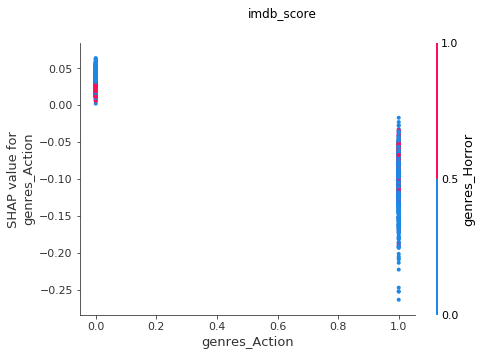

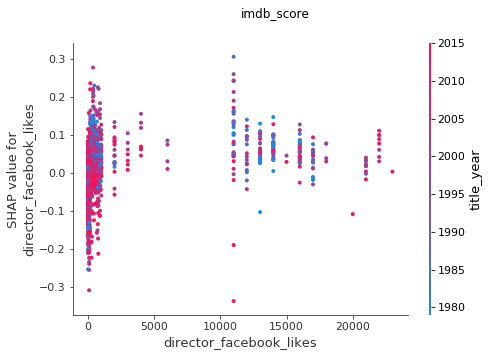

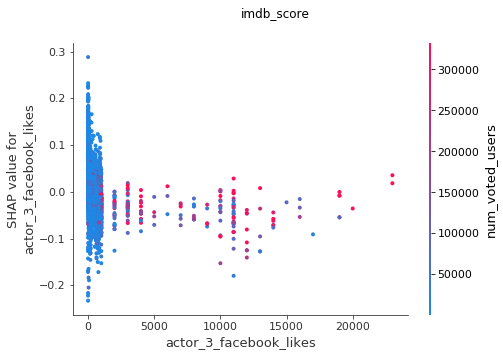

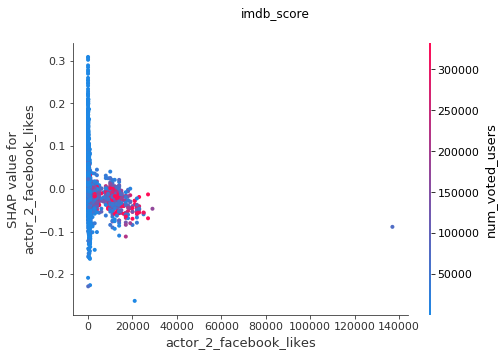

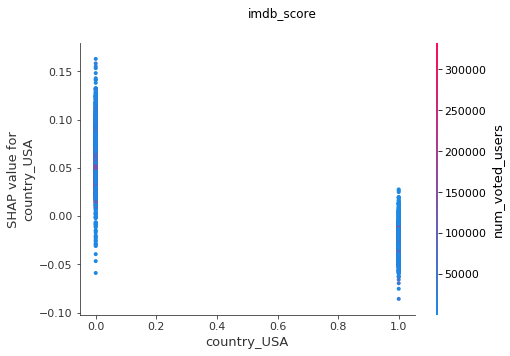

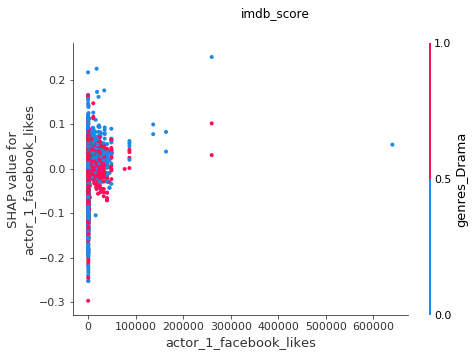

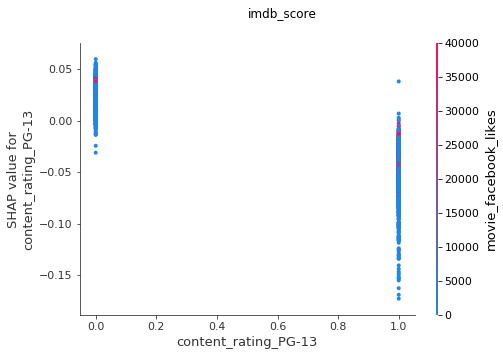

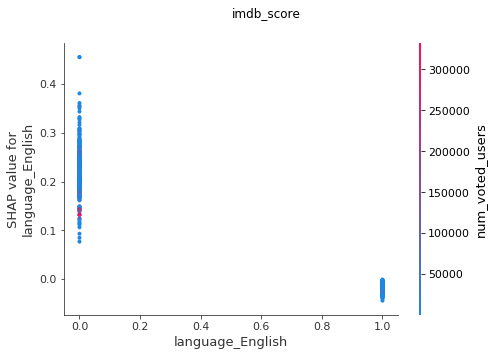

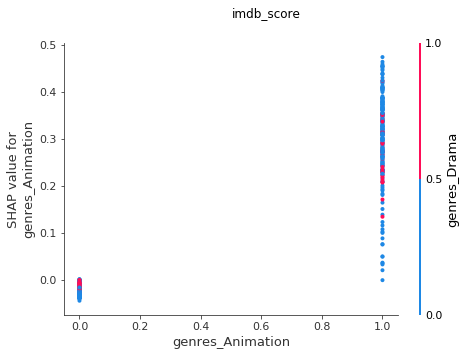

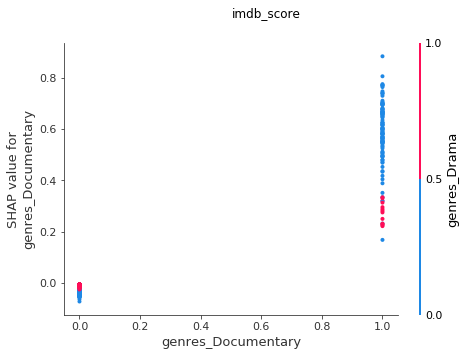

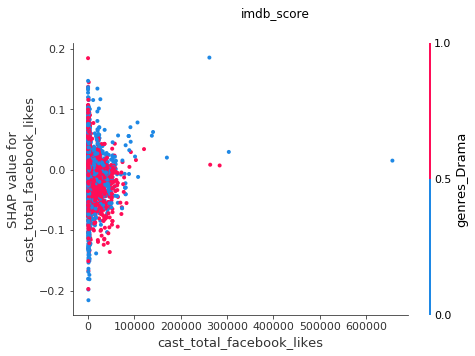

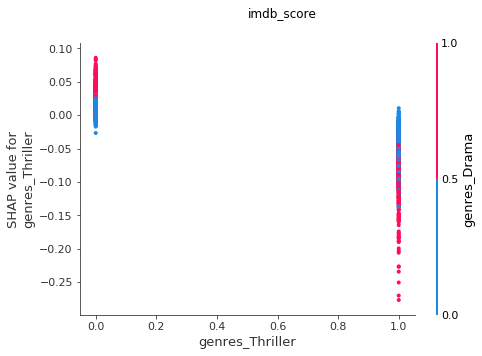

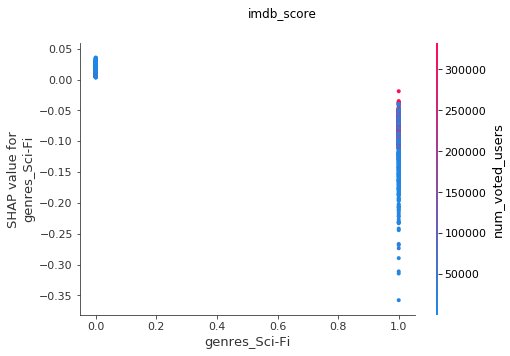

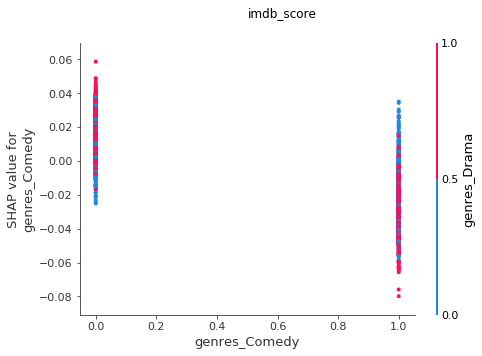

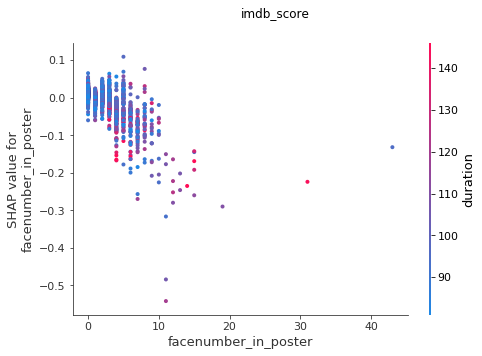

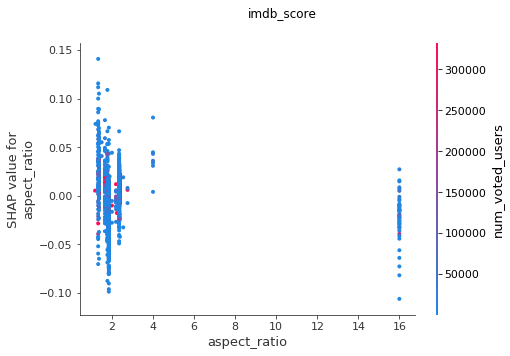

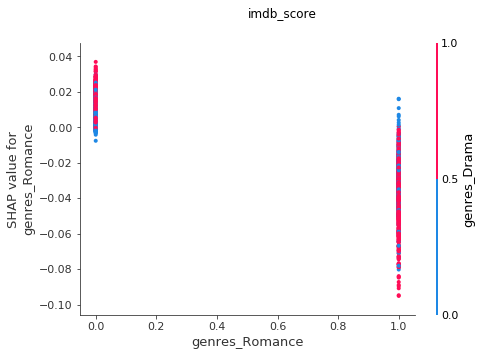

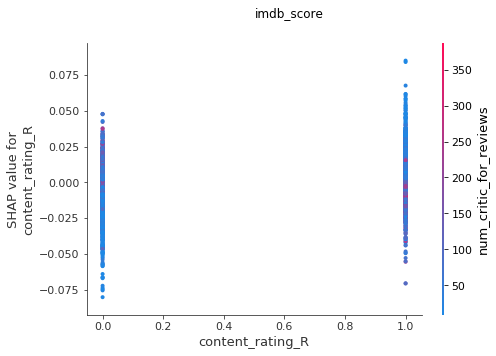

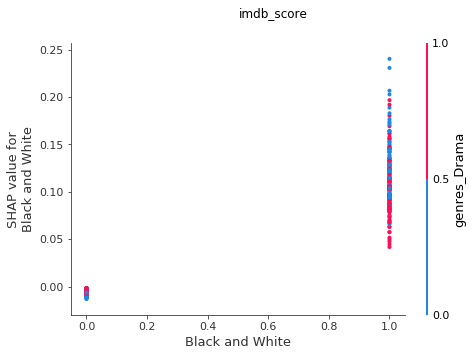

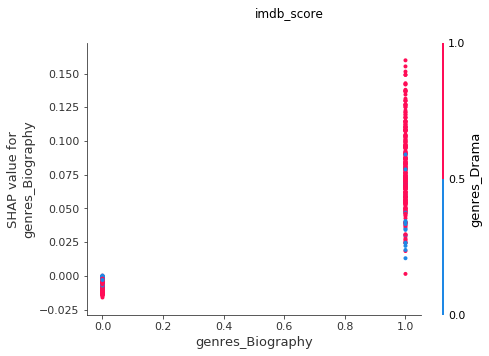

Wall time: 6min 7s


In [223]:
%%time
colname = "gross"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(movie_metadata_cleaned.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)

In [ ]:
### find best settings

In [229]:
%%time

target = movie_metadata_cleaned["imdb_score"]
train =movie_metadata_cleaned.drop("imdb_score",axis=1)
### xgboost_tuner
# https://github.com/Jie-Yuan/xgboost-tuner

from xgboost_tuner.tuner import tune_xgb_params

# train = X.values
# label = rounded_targets

# metric_sklearn = ‘neg_mean_squared_error’ or 'remse'
# estimator_cls = xgb.XGBClassifier, xgb.XGBRegressor


# Tune the parameters incrementally and limit the range for colsample_bytree and subsample
best_params, history = tune_xgb_params(
    cv_folds = 3,
    label = target,
    metric_sklearn = 'neg_mean_squared_error',
    metric_xgb = "rmse",
    n_jobs = 4,
    objective = 'reg:linear',
    random_state = seed,
    strategy = 'incremental',
    train = train,
    init_colsample_bytree = 0.9,
    init_gamma = 0.0,
    init_max_depth = 7,
    init_min_child_weight  = 6,
    init_subsample = 0.6,
    learning_rates = [0.03,.04,.05,.06],
)



[0]	train-rmse:5.69448+0.0227361	test-rmse:5.69236+0.0572157
[1]	train-rmse:5.363+0.0216886	test-rmse:5.36063+0.0738498
[2]	train-rmse:5.05165+0.0212259	test-rmse:5.0469+0.0862409
[3]	train-rmse:4.75939+0.0199783	test-rmse:4.76025+0.100714
[4]	train-rmse:4.48506+0.0190412	test-rmse:4.48722+0.110006
[5]	train-rmse:4.22729+0.0186545	test-rmse:4.23067+0.12296
[6]	train-rmse:3.98508+0.0179452	test-rmse:3.99247+0.131774
[7]	train-rmse:3.75817+0.0179808	test-rmse:3.76462+0.139507
[8]	train-rmse:3.5446+0.0177904	test-rmse:3.5588+0.14984
[9]	train-rmse:3.34458+0.0182386	test-rmse:3.36242+0.156703
[10]	train-rmse:3.15744+0.0185698	test-rmse:3.17623+0.158959
[11]	train-rmse:2.98185+0.0187645	test-rmse:3.00654+0.159985
[12]	train-rmse:2.81559+0.0189526	test-rmse:2.84537+0.164739
[13]	train-rmse:2.66053+0.0185669	test-rmse:2.70011+0.170341
[14]	train-rmse:2.51362+0.0187835	test-rmse:2.55447+0.173425
[15]	train-rmse:2.37746+0.0196896	test-rmse:2.42011+0.178225
[16]	train-rmse:2.24963+0.0206386	test

[132]	train-rmse:0.403979+0.0342734	test-rmse:0.753998+0.124563
[133]	train-rmse:0.401794+0.0343637	test-rmse:0.753578+0.124428
[134]	train-rmse:0.400322+0.0350046	test-rmse:0.752967+0.1239
[135]	train-rmse:0.398714+0.0351597	test-rmse:0.753133+0.124122
[136]	train-rmse:0.398136+0.0350985	test-rmse:0.752996+0.124327
[137]	train-rmse:0.396933+0.0347548	test-rmse:0.753028+0.124313
[138]	train-rmse:0.395596+0.0349328	test-rmse:0.752075+0.12318
[139]	train-rmse:0.394113+0.0346332	test-rmse:0.751933+0.123155
[140]	train-rmse:0.392538+0.0339674	test-rmse:0.752169+0.122931
[141]	train-rmse:0.391152+0.0339947	test-rmse:0.751896+0.122934
[142]	train-rmse:0.389359+0.0338591	test-rmse:0.751678+0.123237
[143]	train-rmse:0.388336+0.033817	test-rmse:0.752225+0.12374
[144]	train-rmse:0.386355+0.0335923	test-rmse:0.752472+0.124409
[145]	train-rmse:0.385023+0.0332075	test-rmse:0.752877+0.124596
[146]	train-rmse:0.384089+0.0332034	test-rmse:0.752057+0.123828
[147]	train-rmse:0.382335+0.0333684	test-rmse

[261]	train-rmse:0.259819+0.0213448	test-rmse:0.750427+0.126775
[262]	train-rmse:0.258954+0.0215226	test-rmse:0.750443+0.126937
[263]	train-rmse:0.258427+0.0212323	test-rmse:0.750572+0.126994
[264]	train-rmse:0.257564+0.0208462	test-rmse:0.750555+0.126788
[265]	train-rmse:0.256401+0.0207495	test-rmse:0.750533+0.126969
[266]	train-rmse:0.255455+0.0209399	test-rmse:0.750525+0.12683
[267]	train-rmse:0.254744+0.0208322	test-rmse:0.750271+0.126401
[268]	train-rmse:0.25394+0.0206619	test-rmse:0.75059+0.126335
[269]	train-rmse:0.252879+0.0204081	test-rmse:0.750531+0.126102
[270]	train-rmse:0.252147+0.0203317	test-rmse:0.750404+0.125598
[271]	train-rmse:0.251104+0.0204386	test-rmse:0.750334+0.125847
[272]	train-rmse:0.250402+0.0208006	test-rmse:0.750382+0.12587
[273]	train-rmse:0.249389+0.0204206	test-rmse:0.750393+0.125969
[274]	train-rmse:0.248766+0.0205856	test-rmse:0.750255+0.125975
[275]	train-rmse:0.24775+0.0205031	test-rmse:0.75023+0.126201
[276]	train-rmse:0.246963+0.0201405	test-rmse:

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   36.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:  6.8min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed:   39.3s remaining:   15.0s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:   41.2s remaining:    8.2s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   50.1s finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   44.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  2.9min finished


Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   46.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:  1.8min finished


Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   46.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:  1.8min finished


[0]	train-rmse:5.75394+0.0231048	test-rmse:5.75654+0.0527555
[1]	train-rmse:5.47431+0.0222395	test-rmse:5.47832+0.0599186
[2]	train-rmse:5.20942+0.0213944	test-rmse:5.2131+0.0718648
[3]	train-rmse:4.95765+0.0205529	test-rmse:4.96264+0.0818626
[4]	train-rmse:4.71862+0.0200133	test-rmse:4.72352+0.0924873
[5]	train-rmse:4.49191+0.0194575	test-rmse:4.49165+0.102473
[6]	train-rmse:4.27742+0.019314	test-rmse:4.27675+0.107958
[7]	train-rmse:4.07281+0.0189327	test-rmse:4.07174+0.116644
[8]	train-rmse:3.87844+0.0190049	test-rmse:3.87977+0.129247
[9]	train-rmse:3.69504+0.0184779	test-rmse:3.6954+0.134657
[10]	train-rmse:3.5205+0.0184205	test-rmse:3.523+0.142346
[11]	train-rmse:3.35516+0.0179878	test-rmse:3.3612+0.150006
[12]	train-rmse:3.1981+0.0178472	test-rmse:3.20199+0.155388
[13]	train-rmse:3.04986+0.0178915	test-rmse:3.05553+0.161515
[14]	train-rmse:2.90833+0.0184914	test-rmse:2.91592+0.158765
[15]	train-rmse:2.77484+0.0187591	test-rmse:2.78605+0.164951
[16]	train-rmse:2.64795+0.0191698	tes

[132]	train-rmse:0.473948+0.0379084	test-rmse:0.761216+0.124845
[133]	train-rmse:0.472977+0.0376087	test-rmse:0.760759+0.124621
[134]	train-rmse:0.47186+0.0376044	test-rmse:0.759828+0.123793
[135]	train-rmse:0.471096+0.0377128	test-rmse:0.759697+0.123929
[136]	train-rmse:0.47008+0.0375736	test-rmse:0.759369+0.123958
[137]	train-rmse:0.468709+0.037625	test-rmse:0.759117+0.123712
[138]	train-rmse:0.467594+0.0374936	test-rmse:0.758786+0.124075
[139]	train-rmse:0.466554+0.0378421	test-rmse:0.758043+0.123419
[140]	train-rmse:0.465286+0.0378792	test-rmse:0.757934+0.123902
[141]	train-rmse:0.464041+0.0379539	test-rmse:0.757746+0.124069
[142]	train-rmse:0.462918+0.0377709	test-rmse:0.757772+0.1242
[143]	train-rmse:0.461994+0.0377463	test-rmse:0.757456+0.123564
[144]	train-rmse:0.460754+0.0375619	test-rmse:0.757641+0.123937
[145]	train-rmse:0.459551+0.0375177	test-rmse:0.757429+0.124302
[146]	train-rmse:0.458824+0.0377102	test-rmse:0.757296+0.124414
[147]	train-rmse:0.457675+0.0378296	test-rmse

[261]	train-rmse:0.355161+0.0329058	test-rmse:0.745786+0.124003
[262]	train-rmse:0.354427+0.0327068	test-rmse:0.745701+0.124105
[263]	train-rmse:0.353788+0.0329807	test-rmse:0.745764+0.124082
[264]	train-rmse:0.35298+0.0326179	test-rmse:0.745763+0.124112
[265]	train-rmse:0.352481+0.032518	test-rmse:0.745717+0.124196
[266]	train-rmse:0.351603+0.03235	test-rmse:0.74556+0.123986
[267]	train-rmse:0.351154+0.0323952	test-rmse:0.745509+0.123992
[268]	train-rmse:0.350719+0.0324404	test-rmse:0.745469+0.124014
[269]	train-rmse:0.350196+0.0324569	test-rmse:0.745387+0.123949
[270]	train-rmse:0.349399+0.0324009	test-rmse:0.745367+0.123944
[271]	train-rmse:0.348722+0.0323539	test-rmse:0.745151+0.123682
[272]	train-rmse:0.348118+0.0322573	test-rmse:0.745113+0.12362
[273]	train-rmse:0.347179+0.0322675	test-rmse:0.745231+0.123653
[274]	train-rmse:0.34665+0.0320624	test-rmse:0.745152+0.12364
[275]	train-rmse:0.346035+0.0322932	test-rmse:0.745216+0.12365
[276]	train-rmse:0.3452+0.0322654	test-rmse:0.745

[390]	train-rmse:0.276664+0.0258854	test-rmse:0.743438+0.126172
[391]	train-rmse:0.275856+0.0256774	test-rmse:0.74336+0.12619
[392]	train-rmse:0.275285+0.0257199	test-rmse:0.743308+0.126157
[393]	train-rmse:0.274965+0.0256231	test-rmse:0.743289+0.126173
[394]	train-rmse:0.274601+0.0254109	test-rmse:0.743285+0.126133
[395]	train-rmse:0.274153+0.0255117	test-rmse:0.743286+0.12617
[396]	train-rmse:0.27357+0.025646	test-rmse:0.743244+0.126178
[397]	train-rmse:0.273037+0.0256596	test-rmse:0.743399+0.126225
[398]	train-rmse:0.272612+0.0255227	test-rmse:0.743445+0.126264
[399]	train-rmse:0.272024+0.0254891	test-rmse:0.743451+0.12629
[400]	train-rmse:0.271438+0.0254305	test-rmse:0.743375+0.12639
[401]	train-rmse:0.271164+0.0254299	test-rmse:0.743414+0.126376
[402]	train-rmse:0.270642+0.0253108	test-rmse:0.743473+0.126362
[403]	train-rmse:0.270291+0.0251095	test-rmse:0.743474+0.126387
[404]	train-rmse:0.269492+0.024879	test-rmse:0.743379+0.126296
[405]	train-rmse:0.268973+0.0249889	test-rmse:0.

[520]	train-rmse:0.218517+0.0197707	test-rmse:0.743192+0.128265
[521]	train-rmse:0.21787+0.0197069	test-rmse:0.743064+0.128237
[522]	train-rmse:0.217478+0.0197587	test-rmse:0.742967+0.128184
[523]	train-rmse:0.21726+0.0198152	test-rmse:0.742993+0.128237
[524]	train-rmse:0.216956+0.0198238	test-rmse:0.743065+0.12846
[525]	train-rmse:0.21675+0.019852	test-rmse:0.743119+0.12844
[526]	train-rmse:0.216386+0.0196753	test-rmse:0.743049+0.128437
[527]	train-rmse:0.215909+0.019731	test-rmse:0.743001+0.12842
[528]	train-rmse:0.215657+0.0196842	test-rmse:0.742936+0.128431
[529]	train-rmse:0.21535+0.0197045	test-rmse:0.743017+0.128425
[530]	train-rmse:0.214963+0.0195194	test-rmse:0.743016+0.128399
[531]	train-rmse:0.214657+0.0195734	test-rmse:0.743081+0.128496
[532]	train-rmse:0.214203+0.0197233	test-rmse:0.742967+0.128485
[533]	train-rmse:0.213655+0.019777	test-rmse:0.743+0.128503
[534]	train-rmse:0.2131+0.0197443	test-rmse:0.74298+0.128534
[535]	train-rmse:0.212907+0.0197862	test-rmse:0.74291+0.

[96]	train-rmse:0.575865+0.0352297	test-rmse:0.799923+0.135481
[97]	train-rmse:0.573121+0.0351887	test-rmse:0.798607+0.134246
[98]	train-rmse:0.570688+0.0350862	test-rmse:0.797039+0.133739
[99]	train-rmse:0.567918+0.0354274	test-rmse:0.795217+0.132614
[100]	train-rmse:0.565426+0.0353798	test-rmse:0.793794+0.132119
[101]	train-rmse:0.562978+0.0356559	test-rmse:0.792554+0.131537
[102]	train-rmse:0.560721+0.0360378	test-rmse:0.791346+0.13158
[103]	train-rmse:0.558444+0.0357027	test-rmse:0.790127+0.131128
[104]	train-rmse:0.556726+0.0355906	test-rmse:0.789013+0.130597
[105]	train-rmse:0.554399+0.0356731	test-rmse:0.788759+0.13183
[106]	train-rmse:0.552415+0.0354714	test-rmse:0.7875+0.130914
[107]	train-rmse:0.54985+0.0354051	test-rmse:0.786049+0.130318
[108]	train-rmse:0.547898+0.0355285	test-rmse:0.785654+0.130299
[109]	train-rmse:0.546211+0.0354349	test-rmse:0.784443+0.12909
[110]	train-rmse:0.544293+0.0360445	test-rmse:0.783552+0.128711
[111]	train-rmse:0.542303+0.0358488	test-rmse:0.78

[226]	train-rmse:0.419333+0.0341415	test-rmse:0.750349+0.119315
[227]	train-rmse:0.418792+0.0340805	test-rmse:0.750282+0.119196
[228]	train-rmse:0.418096+0.034431	test-rmse:0.750157+0.119261
[229]	train-rmse:0.417219+0.0339625	test-rmse:0.749733+0.118999
[230]	train-rmse:0.416467+0.0339674	test-rmse:0.74929+0.118587
[231]	train-rmse:0.415616+0.0337674	test-rmse:0.749088+0.118534
[232]	train-rmse:0.414839+0.0337564	test-rmse:0.749015+0.118927
[233]	train-rmse:0.41435+0.0338906	test-rmse:0.748907+0.118865
[234]	train-rmse:0.41368+0.033675	test-rmse:0.749003+0.118972
[235]	train-rmse:0.413046+0.03379	test-rmse:0.749079+0.11892
[236]	train-rmse:0.411953+0.0340839	test-rmse:0.749001+0.118797
[237]	train-rmse:0.411049+0.034089	test-rmse:0.748881+0.118826
[238]	train-rmse:0.410195+0.034016	test-rmse:0.748902+0.119058
[239]	train-rmse:0.409847+0.0340893	test-rmse:0.748827+0.119197
[240]	train-rmse:0.409219+0.0338809	test-rmse:0.748691+0.119231
[241]	train-rmse:0.40867+0.0335486	test-rmse:0.748

[356]	train-rmse:0.337645+0.0300324	test-rmse:0.743997+0.120255
[357]	train-rmse:0.337217+0.0301752	test-rmse:0.744061+0.120295
[358]	train-rmse:0.336568+0.0300918	test-rmse:0.744009+0.12023
[359]	train-rmse:0.335833+0.0301052	test-rmse:0.744019+0.120215
[360]	train-rmse:0.335423+0.0300114	test-rmse:0.744008+0.120243
[361]	train-rmse:0.334828+0.0299491	test-rmse:0.744025+0.120292
[362]	train-rmse:0.334434+0.0297773	test-rmse:0.744069+0.120319
[363]	train-rmse:0.333656+0.0296137	test-rmse:0.744156+0.120333
[364]	train-rmse:0.333071+0.0294085	test-rmse:0.744125+0.120347
[365]	train-rmse:0.332395+0.02909	test-rmse:0.744364+0.120477
[366]	train-rmse:0.331986+0.0288313	test-rmse:0.74429+0.120449
[367]	train-rmse:0.331698+0.0288191	test-rmse:0.7445+0.120661
[368]	train-rmse:0.330813+0.0286426	test-rmse:0.744327+0.120728
[369]	train-rmse:0.330446+0.0287661	test-rmse:0.744346+0.120795
[370]	train-rmse:0.330088+0.0286476	test-rmse:0.74432+0.120852
[371]	train-rmse:0.329749+0.0285537	test-rmse:0

[486]	train-rmse:0.276143+0.0239847	test-rmse:0.742054+0.12292
[487]	train-rmse:0.275933+0.0240634	test-rmse:0.742021+0.12295
[488]	train-rmse:0.275638+0.0240643	test-rmse:0.742071+0.123091
[489]	train-rmse:0.275304+0.0239022	test-rmse:0.742052+0.12308
[490]	train-rmse:0.274904+0.0238994	test-rmse:0.742143+0.123055
[491]	train-rmse:0.274359+0.0238405	test-rmse:0.742154+0.123125
[492]	train-rmse:0.274033+0.0238345	test-rmse:0.742172+0.123155
[493]	train-rmse:0.273609+0.0238596	test-rmse:0.742057+0.123262
[494]	train-rmse:0.273184+0.0237623	test-rmse:0.742092+0.123236
[495]	train-rmse:0.272619+0.0237106	test-rmse:0.742173+0.123174
[496]	train-rmse:0.272377+0.0237932	test-rmse:0.742101+0.12318
[497]	train-rmse:0.271968+0.0238179	test-rmse:0.74209+0.123225
[498]	train-rmse:0.271613+0.0237462	test-rmse:0.742082+0.123173
[499]	train-rmse:0.271116+0.023535	test-rmse:0.742001+0.123125
[500]	train-rmse:0.270672+0.0234	test-rmse:0.742086+0.123254
[501]	train-rmse:0.270128+0.0235777	test-rmse:0.7

[615]	train-rmse:0.229475+0.0198774	test-rmse:0.741565+0.125112
[616]	train-rmse:0.229265+0.019883	test-rmse:0.741525+0.125127
[617]	train-rmse:0.228853+0.0198458	test-rmse:0.741505+0.125139
[618]	train-rmse:0.228661+0.0199004	test-rmse:0.741534+0.125152
[619]	train-rmse:0.228439+0.0198151	test-rmse:0.741558+0.125169
[620]	train-rmse:0.22805+0.0198094	test-rmse:0.741555+0.125168
[621]	train-rmse:0.227668+0.0197768	test-rmse:0.741603+0.125184
[622]	train-rmse:0.227274+0.0196822	test-rmse:0.741642+0.125158
[623]	train-rmse:0.226996+0.0196647	test-rmse:0.741603+0.125198
[624]	train-rmse:0.226729+0.0196179	test-rmse:0.741635+0.125138
[625]	train-rmse:0.226368+0.0195046	test-rmse:0.741659+0.125128
[626]	train-rmse:0.225964+0.019409	test-rmse:0.741579+0.125041
[0]	train-rmse:5.87138+0.023247	test-rmse:5.87288+0.0503387
[1]	train-rmse:5.70001+0.0227063	test-rmse:5.70361+0.056012
[2]	train-rmse:5.53421+0.0221756	test-rmse:5.53757+0.0627868
[3]	train-rmse:5.37323+0.0216409	test-rmse:5.37712+0.0

[121]	train-rmse:0.595215+0.0341103	test-rmse:0.808846+0.137922
[122]	train-rmse:0.59269+0.0342883	test-rmse:0.807178+0.137518
[123]	train-rmse:0.590227+0.0345326	test-rmse:0.806171+0.13715
[124]	train-rmse:0.587692+0.0347477	test-rmse:0.805106+0.136907
[125]	train-rmse:0.585315+0.0346963	test-rmse:0.803643+0.136173
[126]	train-rmse:0.583081+0.0344191	test-rmse:0.802416+0.136019
[127]	train-rmse:0.580828+0.0343062	test-rmse:0.801216+0.135655
[128]	train-rmse:0.578858+0.0341647	test-rmse:0.800062+0.135256
[129]	train-rmse:0.576553+0.0342744	test-rmse:0.798873+0.134544
[130]	train-rmse:0.574443+0.0341199	test-rmse:0.797656+0.134429
[131]	train-rmse:0.57242+0.0342967	test-rmse:0.796445+0.13419
[132]	train-rmse:0.570871+0.0345345	test-rmse:0.794827+0.1331
[133]	train-rmse:0.568962+0.0346952	test-rmse:0.793703+0.132731
[134]	train-rmse:0.567053+0.0346728	test-rmse:0.792679+0.132315
[135]	train-rmse:0.56537+0.0346029	test-rmse:0.79188+0.131833
[136]	train-rmse:0.563631+0.0346227	test-rmse:0.

[250]	train-rmse:0.451719+0.0340263	test-rmse:0.754967+0.120175
[251]	train-rmse:0.451085+0.034091	test-rmse:0.754934+0.12033
[252]	train-rmse:0.450382+0.0342943	test-rmse:0.754872+0.120231
[253]	train-rmse:0.449811+0.0343852	test-rmse:0.754816+0.120048
[254]	train-rmse:0.449214+0.0343488	test-rmse:0.754702+0.119918
[255]	train-rmse:0.448668+0.0345588	test-rmse:0.754678+0.12001
[256]	train-rmse:0.447945+0.0346069	test-rmse:0.754633+0.119878
[257]	train-rmse:0.447135+0.0347141	test-rmse:0.754509+0.119935
[258]	train-rmse:0.446314+0.034678	test-rmse:0.754307+0.120048
[259]	train-rmse:0.445652+0.034396	test-rmse:0.75414+0.12024
[260]	train-rmse:0.445004+0.0343184	test-rmse:0.753842+0.120178
[261]	train-rmse:0.444489+0.03437	test-rmse:0.753769+0.120211
[262]	train-rmse:0.443812+0.0343829	test-rmse:0.753756+0.12013
[263]	train-rmse:0.443005+0.0344474	test-rmse:0.753531+0.120304
[264]	train-rmse:0.442409+0.0343811	test-rmse:0.753533+0.120302
[265]	train-rmse:0.441766+0.0343134	test-rmse:0.75

[379]	train-rmse:0.379552+0.0316478	test-rmse:0.747829+0.121883
[380]	train-rmse:0.379304+0.0316075	test-rmse:0.747809+0.121815
[381]	train-rmse:0.378814+0.0317244	test-rmse:0.747644+0.121796
[382]	train-rmse:0.378486+0.0316616	test-rmse:0.74775+0.121825
[383]	train-rmse:0.37789+0.0315901	test-rmse:0.747833+0.121872
[384]	train-rmse:0.377438+0.0314701	test-rmse:0.747951+0.121991
[385]	train-rmse:0.376893+0.0317216	test-rmse:0.747888+0.121956
[386]	train-rmse:0.376329+0.0316214	test-rmse:0.747865+0.121978
[387]	train-rmse:0.375718+0.0315549	test-rmse:0.747683+0.121809
[388]	train-rmse:0.375099+0.0316501	test-rmse:0.747658+0.121957
[389]	train-rmse:0.374704+0.0315682	test-rmse:0.747638+0.122012
[390]	train-rmse:0.374421+0.0314776	test-rmse:0.747534+0.121933
[391]	train-rmse:0.37389+0.0314455	test-rmse:0.747377+0.122004
[392]	train-rmse:0.373517+0.0313902	test-rmse:0.747258+0.122005
[393]	train-rmse:0.373089+0.0312812	test-rmse:0.747188+0.122239
[394]	train-rmse:0.372756+0.0311462	test-rm

[508]	train-rmse:0.325214+0.0277363	test-rmse:0.744175+0.122641
[509]	train-rmse:0.325011+0.0276863	test-rmse:0.744254+0.122656
[510]	train-rmse:0.324729+0.0275442	test-rmse:0.744121+0.122549
[511]	train-rmse:0.324217+0.0272915	test-rmse:0.744104+0.122549
[512]	train-rmse:0.323911+0.0272616	test-rmse:0.744294+0.1226
[513]	train-rmse:0.323581+0.0273092	test-rmse:0.744262+0.122626
[514]	train-rmse:0.323162+0.027251	test-rmse:0.744358+0.122779
[515]	train-rmse:0.322753+0.0272834	test-rmse:0.744252+0.122882
[516]	train-rmse:0.322393+0.0273105	test-rmse:0.744258+0.122867
[517]	train-rmse:0.321792+0.027313	test-rmse:0.744313+0.122999
[518]	train-rmse:0.321325+0.0273939	test-rmse:0.744291+0.123077
[519]	train-rmse:0.321031+0.0273718	test-rmse:0.744367+0.123038
[520]	train-rmse:0.320281+0.0272846	test-rmse:0.744495+0.123092
[521]	train-rmse:0.319739+0.0271414	test-rmse:0.744459+0.123198
[522]	train-rmse:0.319304+0.0269526	test-rmse:0.744435+0.123224
[523]	train-rmse:0.319082+0.0270919	test-rms

In [230]:
best_params

{'colsample_bytree': 0.6,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 6,
 'nthread': 4,
 'objective': 'reg:linear',
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'random_state': 27,
 'n_estimators': 508,
 'reg_alpha': 5e-05,
 'reg_lambda': 1}

In [231]:
history

[({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.06,
   'max_depth': 7,
   'min_child_weight': 6,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.6,
   'random_state': 27,
   'n_estimators': 231},
  0.288901),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.06,
   'max_depth': 7,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.6,
   'random_state': 27,
   'n_estimators': 231},
  0.7634561667522037),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.06,
   'max_depth': 6,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.6,
   'random_state': 27,
   'n_estimators': 231},
  0.7634561667522037),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.06,
   'max_depth': 6,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.6,
   'random_state': 27,
   'n_estimators': 231},
  0.7606984310492958),
 ({'colsample_bytree': 0.6,
   'gamma': 0.0,
   'learning_rate': 0.06,
   'max_depth': 6,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 231},
  0.7595069313599697),
 ({'colsample_bytree': 0.6,
   'gamma': 0.0,
   'learning_rate': 0.06,
   'max_depth': 6,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 231,
   'reg_alpha': 5e-05},
  0.7595069313599697),
 ({'colsample_bytree': 0.6,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 6,
   'min_child_weight': 6,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 508,
   'reg_alpha': 5e-05,
   'reg_lambda': 1},
  0.22356566666666666),
 ({'colsample_bytree': 0.6,
   'gamma': 0.0,
   'learning_rate': 0.04,
   'max_depth': 6,
   'min_child_weight': 6,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 578,
   'reg_alpha': 5e-05,
   'reg_lambda': 1},
  0.24301533333333333),
 ({'colsample_bytree': 0.6,
   'gamma': 0.0,
   'learning_rate': 0.03,
   'max_depth': 6,
   'min_child_weight': 6,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 507,
   'reg_alpha': 5e-05,
   'reg_lambda': 1},
  0.326077)]

In [ ]:
{'colsample_bytree': 0.6,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 6,
 'nthread': 4,
 'objective': 'reg:linear',
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'random_state': 27,
 'n_estimators': 508,
 'reg_alpha': 5e-05,
 'reg_lambda': 1}

In [233]:
%%time
X_train, X_test, y_train, y_test = train_test_split( train,
                                                     target, test_size=test_size,
                                                     random_state=seed,
                                                     stratify=pd.qcut( pd.Series( target ), q=10 ).cat.codes )

eval_set = [(X_test, y_test)]

param_test1 ={
 'min_child_weight':[5,7],
 'learning_rate':[0.045,0.055],
 'subsample':[.75,.85],
 'max_depth':[5,7],
 'gamma':[0],
 'reg_alpha':[5e-05],
 'reg_lambda':[1],
 'colsample_bytree':[0.55,.65],
 'scale_pos_weight': [1],
 'n_estimators': [508],
}

# {'colsample_bytree': 0.7,
#  'gamma': 0.30000000000000004,
#  'learning_rate': 0.06,
#  'max_depth': 10,
#  'min_child_weight': 5,
#  'nthread': 4,
#  'objective': 'reg:linear',
#  'scale_pos_weight': 1,
#  'subsample': 0.6,
#  'random_state': 27,
#  'n_estimators': 1733,
#  'reg_alpha': 0.01,
#  'reg_lambda': 1}

from sklearn.model_selection import StratifiedKFold, KFold
skf = StratifiedKFold(n_splits=3)
skf = KFold(n_splits=3)

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



gsearch1 = GridSearchCV(estimator = alg,
                        param_grid = param_test1,
                        scoring='r2', #'r2'
                        n_jobs=1, 
                        iid=False,
                        cv=skf,
                        verbose=True)

gsearch1.fit(X_train, y_train, eval_metric='rmse',
        early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
        verbose=True)

display(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0]	validation_0-rmse:5.78004
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.5269
[2]	validation_0-rmse:5.28681
[3]	validation_0-rmse:5.05675
[4]	validation_0-rmse:4.83757
[5]	validation_0-rmse:4.62916
[6]	validation_0-rmse:4.43031
[7]	validation_0-rmse:4.24005
[8]	validation_0-rmse:4.05791
[9]	validation_0-rmse:3.8852
[10]	validation_0-rmse:3.72039
[11]	validation_0-rmse:3.56335
[12]	validation_0-rmse:3.41358
[13]	validation_0-rmse:3.27116
[14]	validation_0-rmse:3.13541
[15]	validation_0-rmse:3.00638
[16]	validation_0-rmse:2.88339
[17]	validation_0-rmse:2.76693
[18]	validation_0-rmse:2.65442
[19]	validation_0-rmse:2.54836
[20]	validation_0-rmse:2.44688
[21]	validation_0-rmse:2.35073
[22]	validation_0-rmse:2.25832
[23]	validation_0-rmse:2.17101
[24]	validation_0-rmse:2.08825
[25]	validation_0-rmse:2.00885
[26]	validation_0-rmse:1.93342
[27]	validation_0-rmse:1.86222
[28]	validation_0-rmse:1.79465
[29]	validation_0-rmse:1.73096
[

[252]	validation_0-rmse:0.719901
[253]	validation_0-rmse:0.719774
[254]	validation_0-rmse:0.719548
[255]	validation_0-rmse:0.719584
[256]	validation_0-rmse:0.719453
[257]	validation_0-rmse:0.719404
[258]	validation_0-rmse:0.719457
[259]	validation_0-rmse:0.7196
[260]	validation_0-rmse:0.719698
[261]	validation_0-rmse:0.719719
[262]	validation_0-rmse:0.719549
[263]	validation_0-rmse:0.719637
[264]	validation_0-rmse:0.719487
[265]	validation_0-rmse:0.719192
[266]	validation_0-rmse:0.71903
[267]	validation_0-rmse:0.719119
[268]	validation_0-rmse:0.718894
[269]	validation_0-rmse:0.719017
[270]	validation_0-rmse:0.71917
[271]	validation_0-rmse:0.719012
[272]	validation_0-rmse:0.719061
[273]	validation_0-rmse:0.718962
[274]	validation_0-rmse:0.718667
[275]	validation_0-rmse:0.718498
[276]	validation_0-rmse:0.718504
[277]	validation_0-rmse:0.718385
[278]	validation_0-rmse:0.718057
[279]	validation_0-rmse:0.718303
[280]	validation_0-rmse:0.718129
[281]	validation_0-rmse:0.717682
[282]	validati

[45]	validation_0-rmse:1.09439
[46]	validation_0-rmse:1.07126
[47]	validation_0-rmse:1.04823
[48]	validation_0-rmse:1.02877
[49]	validation_0-rmse:1.00961
[50]	validation_0-rmse:0.991393
[51]	validation_0-rmse:0.975061
[52]	validation_0-rmse:0.960636
[53]	validation_0-rmse:0.946561
[54]	validation_0-rmse:0.932992
[55]	validation_0-rmse:0.919184
[56]	validation_0-rmse:0.907114
[57]	validation_0-rmse:0.896192
[58]	validation_0-rmse:0.885812
[59]	validation_0-rmse:0.876386
[60]	validation_0-rmse:0.867748
[61]	validation_0-rmse:0.859422
[62]	validation_0-rmse:0.851627
[63]	validation_0-rmse:0.844475
[64]	validation_0-rmse:0.8381
[65]	validation_0-rmse:0.832175
[66]	validation_0-rmse:0.826778
[67]	validation_0-rmse:0.821361
[68]	validation_0-rmse:0.814963
[69]	validation_0-rmse:0.810439
[70]	validation_0-rmse:0.806139
[71]	validation_0-rmse:0.802001
[72]	validation_0-rmse:0.798155
[73]	validation_0-rmse:0.794681
[74]	validation_0-rmse:0.791212
[75]	validation_0-rmse:0.787841
[76]	validation

[296]	validation_0-rmse:0.719059
[297]	validation_0-rmse:0.718834
[298]	validation_0-rmse:0.719089
[299]	validation_0-rmse:0.719272
[300]	validation_0-rmse:0.718956
[301]	validation_0-rmse:0.718831
[302]	validation_0-rmse:0.718852
[303]	validation_0-rmse:0.718864
[304]	validation_0-rmse:0.718868
[305]	validation_0-rmse:0.718924
[306]	validation_0-rmse:0.718952
[307]	validation_0-rmse:0.719075
[308]	validation_0-rmse:0.719259
[309]	validation_0-rmse:0.719197
[310]	validation_0-rmse:0.71932
[311]	validation_0-rmse:0.719419
[312]	validation_0-rmse:0.719306
[313]	validation_0-rmse:0.719136
[314]	validation_0-rmse:0.718799
[315]	validation_0-rmse:0.718674
[316]	validation_0-rmse:0.718606
[317]	validation_0-rmse:0.718527
[318]	validation_0-rmse:0.718388
[319]	validation_0-rmse:0.718244
[320]	validation_0-rmse:0.718377
[321]	validation_0-rmse:0.718411
[322]	validation_0-rmse:0.718395
[323]	validation_0-rmse:0.718524
[324]	validation_0-rmse:0.718454
[325]	validation_0-rmse:0.718281
[326]	valid

[57]	validation_0-rmse:0.903691
[58]	validation_0-rmse:0.893404
[59]	validation_0-rmse:0.883433
[60]	validation_0-rmse:0.874521
[61]	validation_0-rmse:0.865785
[62]	validation_0-rmse:0.857994
[63]	validation_0-rmse:0.850899
[64]	validation_0-rmse:0.843492
[65]	validation_0-rmse:0.837328
[66]	validation_0-rmse:0.831455
[67]	validation_0-rmse:0.825672
[68]	validation_0-rmse:0.82042
[69]	validation_0-rmse:0.814713
[70]	validation_0-rmse:0.810193
[71]	validation_0-rmse:0.805671
[72]	validation_0-rmse:0.802317
[73]	validation_0-rmse:0.798802
[74]	validation_0-rmse:0.795744
[75]	validation_0-rmse:0.791011
[76]	validation_0-rmse:0.787114
[77]	validation_0-rmse:0.78404
[78]	validation_0-rmse:0.78129
[79]	validation_0-rmse:0.778684
[80]	validation_0-rmse:0.77695
[81]	validation_0-rmse:0.774449
[82]	validation_0-rmse:0.772343
[83]	validation_0-rmse:0.770251
[84]	validation_0-rmse:0.767952
[85]	validation_0-rmse:0.766248
[86]	validation_0-rmse:0.764454
[87]	validation_0-rmse:0.762342
[88]	validat

[308]	validation_0-rmse:0.718472
[309]	validation_0-rmse:0.718415
[310]	validation_0-rmse:0.718372
[311]	validation_0-rmse:0.718421
[312]	validation_0-rmse:0.718426
[313]	validation_0-rmse:0.718407
[314]	validation_0-rmse:0.718218
[315]	validation_0-rmse:0.718032
[316]	validation_0-rmse:0.71818
[317]	validation_0-rmse:0.717905
[318]	validation_0-rmse:0.717741
[319]	validation_0-rmse:0.717571
[320]	validation_0-rmse:0.717531
[321]	validation_0-rmse:0.717637
[322]	validation_0-rmse:0.717646
[323]	validation_0-rmse:0.71766
[324]	validation_0-rmse:0.717788
[325]	validation_0-rmse:0.71792
[326]	validation_0-rmse:0.717895
[327]	validation_0-rmse:0.717777
[328]	validation_0-rmse:0.717653
[329]	validation_0-rmse:0.717668
[330]	validation_0-rmse:0.717404
[331]	validation_0-rmse:0.717392
[332]	validation_0-rmse:0.71736
[333]	validation_0-rmse:0.717223
[334]	validation_0-rmse:0.717102
[335]	validation_0-rmse:0.717052
[336]	validation_0-rmse:0.717023
[337]	validation_0-rmse:0.716864
[338]	validati

[50]	validation_0-rmse:0.974601
[51]	validation_0-rmse:0.957942
[52]	validation_0-rmse:0.943131
[53]	validation_0-rmse:0.928853
[54]	validation_0-rmse:0.914991
[55]	validation_0-rmse:0.901769
[56]	validation_0-rmse:0.890296
[57]	validation_0-rmse:0.879559
[58]	validation_0-rmse:0.869041
[59]	validation_0-rmse:0.859777
[60]	validation_0-rmse:0.850555
[61]	validation_0-rmse:0.843044
[62]	validation_0-rmse:0.835276
[63]	validation_0-rmse:0.828673
[64]	validation_0-rmse:0.822494
[65]	validation_0-rmse:0.816686
[66]	validation_0-rmse:0.811489
[67]	validation_0-rmse:0.80609
[68]	validation_0-rmse:0.801299
[69]	validation_0-rmse:0.796884
[70]	validation_0-rmse:0.792643
[71]	validation_0-rmse:0.78899
[72]	validation_0-rmse:0.786109
[73]	validation_0-rmse:0.782785
[74]	validation_0-rmse:0.780327
[75]	validation_0-rmse:0.777629
[76]	validation_0-rmse:0.774764
[77]	validation_0-rmse:0.772499
[78]	validation_0-rmse:0.770125
[79]	validation_0-rmse:0.76817
[80]	validation_0-rmse:0.766441
[81]	valida

[301]	validation_0-rmse:0.719646
[302]	validation_0-rmse:0.719809
[303]	validation_0-rmse:0.719907
[304]	validation_0-rmse:0.720124
[305]	validation_0-rmse:0.720074
[306]	validation_0-rmse:0.720228
[307]	validation_0-rmse:0.720316
[308]	validation_0-rmse:0.720094
[309]	validation_0-rmse:0.720255
[310]	validation_0-rmse:0.720264
[311]	validation_0-rmse:0.720263
[312]	validation_0-rmse:0.720175
[313]	validation_0-rmse:0.720094
[314]	validation_0-rmse:0.719981
[315]	validation_0-rmse:0.719913
[316]	validation_0-rmse:0.720032
[317]	validation_0-rmse:0.720131
[318]	validation_0-rmse:0.720041
[319]	validation_0-rmse:0.719738
[320]	validation_0-rmse:0.719635
[321]	validation_0-rmse:0.719576
[322]	validation_0-rmse:0.719683
[323]	validation_0-rmse:0.719784
[324]	validation_0-rmse:0.719799
[325]	validation_0-rmse:0.71955
[326]	validation_0-rmse:0.719378
[327]	validation_0-rmse:0.719329
[328]	validation_0-rmse:0.719377
[329]	validation_0-rmse:0.719489
[330]	validation_0-rmse:0.719559
[331]	valid

[41]	validation_0-rmse:1.20181
[42]	validation_0-rmse:1.17101
[43]	validation_0-rmse:1.1436
[44]	validation_0-rmse:1.11746
[45]	validation_0-rmse:1.09222
[46]	validation_0-rmse:1.06958
[47]	validation_0-rmse:1.04722
[48]	validation_0-rmse:1.02683
[49]	validation_0-rmse:1.00795
[50]	validation_0-rmse:0.989677
[51]	validation_0-rmse:0.972688
[52]	validation_0-rmse:0.957697
[53]	validation_0-rmse:0.943349
[54]	validation_0-rmse:0.929797
[55]	validation_0-rmse:0.915828
[56]	validation_0-rmse:0.903779
[57]	validation_0-rmse:0.891849
[58]	validation_0-rmse:0.881657
[59]	validation_0-rmse:0.871935
[60]	validation_0-rmse:0.863326
[61]	validation_0-rmse:0.854934
[62]	validation_0-rmse:0.847428
[63]	validation_0-rmse:0.840549
[64]	validation_0-rmse:0.834104
[65]	validation_0-rmse:0.828172
[66]	validation_0-rmse:0.822938
[67]	validation_0-rmse:0.817287
[68]	validation_0-rmse:0.81201
[69]	validation_0-rmse:0.807457
[70]	validation_0-rmse:0.802736
[71]	validation_0-rmse:0.798716
[72]	validation_0-r

[293]	validation_0-rmse:0.721288
[294]	validation_0-rmse:0.721113
[295]	validation_0-rmse:0.721155
[296]	validation_0-rmse:0.721115
[297]	validation_0-rmse:0.720996
[298]	validation_0-rmse:0.721035
[299]	validation_0-rmse:0.721175
[300]	validation_0-rmse:0.721315
[301]	validation_0-rmse:0.721244
[302]	validation_0-rmse:0.721297
[303]	validation_0-rmse:0.721188
[304]	validation_0-rmse:0.721148
[305]	validation_0-rmse:0.72104
[306]	validation_0-rmse:0.721077
[307]	validation_0-rmse:0.720868
[308]	validation_0-rmse:0.72099
[309]	validation_0-rmse:0.721017
[310]	validation_0-rmse:0.721204
[311]	validation_0-rmse:0.721068
[312]	validation_0-rmse:0.721011
[313]	validation_0-rmse:0.721119
[314]	validation_0-rmse:0.721191
[315]	validation_0-rmse:0.721218
[316]	validation_0-rmse:0.720978
[317]	validation_0-rmse:0.720979
[318]	validation_0-rmse:0.721161
[319]	validation_0-rmse:0.721064
[320]	validation_0-rmse:0.721141
[321]	validation_0-rmse:0.721177
[322]	validation_0-rmse:0.721091
[323]	valida

[34]	validation_0-rmse:1.48231
[35]	validation_0-rmse:1.43637
[36]	validation_0-rmse:1.39235
[37]	validation_0-rmse:1.35216
[38]	validation_0-rmse:1.31473
[39]	validation_0-rmse:1.27878
[40]	validation_0-rmse:1.2448
[41]	validation_0-rmse:1.21328
[42]	validation_0-rmse:1.18204
[43]	validation_0-rmse:1.15406
[44]	validation_0-rmse:1.12692
[45]	validation_0-rmse:1.10175
[46]	validation_0-rmse:1.07807
[47]	validation_0-rmse:1.05583
[48]	validation_0-rmse:1.0349
[49]	validation_0-rmse:1.01639
[50]	validation_0-rmse:0.997975
[51]	validation_0-rmse:0.980652
[52]	validation_0-rmse:0.965154
[53]	validation_0-rmse:0.949985
[54]	validation_0-rmse:0.936027
[55]	validation_0-rmse:0.922231
[56]	validation_0-rmse:0.910292
[57]	validation_0-rmse:0.899323
[58]	validation_0-rmse:0.889142
[59]	validation_0-rmse:0.87953
[60]	validation_0-rmse:0.870863
[61]	validation_0-rmse:0.861887
[62]	validation_0-rmse:0.854254
[63]	validation_0-rmse:0.846315
[64]	validation_0-rmse:0.839201
[65]	validation_0-rmse:0.83

[286]	validation_0-rmse:0.716004
[287]	validation_0-rmse:0.715923
[288]	validation_0-rmse:0.715944
[289]	validation_0-rmse:0.715999
[290]	validation_0-rmse:0.715856
[291]	validation_0-rmse:0.715896
[292]	validation_0-rmse:0.715773
[293]	validation_0-rmse:0.715421
[294]	validation_0-rmse:0.715453
[295]	validation_0-rmse:0.715466
[296]	validation_0-rmse:0.715597
[297]	validation_0-rmse:0.715742
[298]	validation_0-rmse:0.715566
[299]	validation_0-rmse:0.715683
[300]	validation_0-rmse:0.715563
[301]	validation_0-rmse:0.715573
[302]	validation_0-rmse:0.715422
[303]	validation_0-rmse:0.715443
[304]	validation_0-rmse:0.715364
[305]	validation_0-rmse:0.715193
[306]	validation_0-rmse:0.715134
[307]	validation_0-rmse:0.715191
[308]	validation_0-rmse:0.715154
[309]	validation_0-rmse:0.715181
[310]	validation_0-rmse:0.715232
[311]	validation_0-rmse:0.715331
[312]	validation_0-rmse:0.715256
[313]	validation_0-rmse:0.715331
[314]	validation_0-rmse:0.715144
[315]	validation_0-rmse:0.715029
[316]	vali

[27]	validation_0-rmse:1.86177
[28]	validation_0-rmse:1.7944
[29]	validation_0-rmse:1.7308
[30]	validation_0-rmse:1.67062
[31]	validation_0-rmse:1.61393
[32]	validation_0-rmse:1.56052
[33]	validation_0-rmse:1.5105
[34]	validation_0-rmse:1.46254
[35]	validation_0-rmse:1.41693
[36]	validation_0-rmse:1.37479
[37]	validation_0-rmse:1.33346
[38]	validation_0-rmse:1.29566
[39]	validation_0-rmse:1.2589
[40]	validation_0-rmse:1.22495
[41]	validation_0-rmse:1.19321
[42]	validation_0-rmse:1.16351
[43]	validation_0-rmse:1.13588
[44]	validation_0-rmse:1.10892
[45]	validation_0-rmse:1.08392
[46]	validation_0-rmse:1.06154
[47]	validation_0-rmse:1.03875
[48]	validation_0-rmse:1.01843
[49]	validation_0-rmse:0.999729
[50]	validation_0-rmse:0.981121
[51]	validation_0-rmse:0.964879
[52]	validation_0-rmse:0.949459
[53]	validation_0-rmse:0.935351
[54]	validation_0-rmse:0.922091
[55]	validation_0-rmse:0.908159
[56]	validation_0-rmse:0.896494
[57]	validation_0-rmse:0.885736
[58]	validation_0-rmse:0.874788
[5

[279]	validation_0-rmse:0.714583
[280]	validation_0-rmse:0.7146
[281]	validation_0-rmse:0.714254
[282]	validation_0-rmse:0.714123
[283]	validation_0-rmse:0.713978
[284]	validation_0-rmse:0.713678
[285]	validation_0-rmse:0.713715
[286]	validation_0-rmse:0.713719
[287]	validation_0-rmse:0.713588
[288]	validation_0-rmse:0.71372
[289]	validation_0-rmse:0.71384
[290]	validation_0-rmse:0.713971
[291]	validation_0-rmse:0.713886
[292]	validation_0-rmse:0.713854
[293]	validation_0-rmse:0.713889
[294]	validation_0-rmse:0.713735
[295]	validation_0-rmse:0.71391
[296]	validation_0-rmse:0.713526
[297]	validation_0-rmse:0.713381
[298]	validation_0-rmse:0.713599
[299]	validation_0-rmse:0.713801
[300]	validation_0-rmse:0.713589
[301]	validation_0-rmse:0.713738
[302]	validation_0-rmse:0.713745
[303]	validation_0-rmse:0.713889
[304]	validation_0-rmse:0.713873
[305]	validation_0-rmse:0.713865
[306]	validation_0-rmse:0.713926
[307]	validation_0-rmse:0.713854
[308]	validation_0-rmse:0.713506
[309]	validatio

[19]	validation_0-rmse:2.55924
[20]	validation_0-rmse:2.45703
[21]	validation_0-rmse:2.36178
[22]	validation_0-rmse:2.26951
[23]	validation_0-rmse:2.18258
[24]	validation_0-rmse:2.09901
[25]	validation_0-rmse:2.02095
[26]	validation_0-rmse:1.94568
[27]	validation_0-rmse:1.8746
[28]	validation_0-rmse:1.80713
[29]	validation_0-rmse:1.74362
[30]	validation_0-rmse:1.68334
[31]	validation_0-rmse:1.62596
[32]	validation_0-rmse:1.57178
[33]	validation_0-rmse:1.52149
[34]	validation_0-rmse:1.47339
[35]	validation_0-rmse:1.4275
[36]	validation_0-rmse:1.38498
[37]	validation_0-rmse:1.3439
[38]	validation_0-rmse:1.30565
[39]	validation_0-rmse:1.26989
[40]	validation_0-rmse:1.23619
[41]	validation_0-rmse:1.20442
[42]	validation_0-rmse:1.17357
[43]	validation_0-rmse:1.14567
[44]	validation_0-rmse:1.11965
[45]	validation_0-rmse:1.09459
[46]	validation_0-rmse:1.0713
[47]	validation_0-rmse:1.04869
[48]	validation_0-rmse:1.02892
[49]	validation_0-rmse:1.0097
[50]	validation_0-rmse:0.991649
[51]	validat

[272]	validation_0-rmse:0.723511
[273]	validation_0-rmse:0.723299
[274]	validation_0-rmse:0.723168
[275]	validation_0-rmse:0.723353
[276]	validation_0-rmse:0.723362
[277]	validation_0-rmse:0.723419
[278]	validation_0-rmse:0.72338
[279]	validation_0-rmse:0.723155
[280]	validation_0-rmse:0.723059
[281]	validation_0-rmse:0.722985
[282]	validation_0-rmse:0.723109
[283]	validation_0-rmse:0.723111
[284]	validation_0-rmse:0.723004
[285]	validation_0-rmse:0.722815
[286]	validation_0-rmse:0.722778
[287]	validation_0-rmse:0.722644
[288]	validation_0-rmse:0.722486
[289]	validation_0-rmse:0.722342
[290]	validation_0-rmse:0.722327
[291]	validation_0-rmse:0.722426
[292]	validation_0-rmse:0.722422
[293]	validation_0-rmse:0.722403
[294]	validation_0-rmse:0.722546
[295]	validation_0-rmse:0.72258
[296]	validation_0-rmse:0.722383
[297]	validation_0-rmse:0.722168
[298]	validation_0-rmse:0.722208
[299]	validation_0-rmse:0.72255
[300]	validation_0-rmse:0.722279
[301]	validation_0-rmse:0.722193
[302]	validat

[24]	validation_0-rmse:2.10935
[25]	validation_0-rmse:2.03123
[26]	validation_0-rmse:1.95667
[27]	validation_0-rmse:1.88657
[28]	validation_0-rmse:1.81892
[29]	validation_0-rmse:1.75505
[30]	validation_0-rmse:1.69514
[31]	validation_0-rmse:1.63837
[32]	validation_0-rmse:1.58374
[33]	validation_0-rmse:1.53202
[34]	validation_0-rmse:1.48326
[35]	validation_0-rmse:1.43669
[36]	validation_0-rmse:1.39409
[37]	validation_0-rmse:1.35379
[38]	validation_0-rmse:1.31623
[39]	validation_0-rmse:1.27984
[40]	validation_0-rmse:1.24689
[41]	validation_0-rmse:1.21483
[42]	validation_0-rmse:1.18321
[43]	validation_0-rmse:1.15596
[44]	validation_0-rmse:1.12867
[45]	validation_0-rmse:1.10291
[46]	validation_0-rmse:1.07905
[47]	validation_0-rmse:1.05667
[48]	validation_0-rmse:1.03633
[49]	validation_0-rmse:1.01712
[50]	validation_0-rmse:0.998522
[51]	validation_0-rmse:0.981584
[52]	validation_0-rmse:0.966398
[53]	validation_0-rmse:0.951775
[54]	validation_0-rmse:0.93795
[55]	validation_0-rmse:0.924617
[56

[277]	validation_0-rmse:0.72316
[278]	validation_0-rmse:0.723282
[279]	validation_0-rmse:0.723101
[280]	validation_0-rmse:0.723065
[281]	validation_0-rmse:0.722644
[282]	validation_0-rmse:0.722757
[283]	validation_0-rmse:0.722713
[284]	validation_0-rmse:0.722433
[285]	validation_0-rmse:0.72234
[286]	validation_0-rmse:0.722321
[287]	validation_0-rmse:0.722302
[288]	validation_0-rmse:0.722248
[289]	validation_0-rmse:0.72223
[290]	validation_0-rmse:0.722281
[291]	validation_0-rmse:0.722164
[292]	validation_0-rmse:0.722078
[293]	validation_0-rmse:0.721795
[294]	validation_0-rmse:0.721822
[295]	validation_0-rmse:0.721667
[296]	validation_0-rmse:0.721617
[297]	validation_0-rmse:0.721529
[298]	validation_0-rmse:0.721481
[299]	validation_0-rmse:0.721732
[300]	validation_0-rmse:0.721849
[301]	validation_0-rmse:0.722035
[302]	validation_0-rmse:0.72195
[303]	validation_0-rmse:0.721902
[304]	validation_0-rmse:0.721987
[305]	validation_0-rmse:0.721817
[306]	validation_0-rmse:0.721718
[307]	validati

[27]	validation_0-rmse:1.86018
[28]	validation_0-rmse:1.79321
[29]	validation_0-rmse:1.72931
[30]	validation_0-rmse:1.66905
[31]	validation_0-rmse:1.61208
[32]	validation_0-rmse:1.55763
[33]	validation_0-rmse:1.5071
[34]	validation_0-rmse:1.45791
[35]	validation_0-rmse:1.41267
[36]	validation_0-rmse:1.37017
[37]	validation_0-rmse:1.3292
[38]	validation_0-rmse:1.2912
[39]	validation_0-rmse:1.25462
[40]	validation_0-rmse:1.22038
[41]	validation_0-rmse:1.18858
[42]	validation_0-rmse:1.15826
[43]	validation_0-rmse:1.13018
[44]	validation_0-rmse:1.10376
[45]	validation_0-rmse:1.07858
[46]	validation_0-rmse:1.05486
[47]	validation_0-rmse:1.03323
[48]	validation_0-rmse:1.01304
[49]	validation_0-rmse:0.994047
[50]	validation_0-rmse:0.975861
[51]	validation_0-rmse:0.9593
[52]	validation_0-rmse:0.944166
[53]	validation_0-rmse:0.930116
[54]	validation_0-rmse:0.916431
[55]	validation_0-rmse:0.903175
[56]	validation_0-rmse:0.891833
[57]	validation_0-rmse:0.881203
[58]	validation_0-rmse:0.870603
[59

[279]	validation_0-rmse:0.723046
[280]	validation_0-rmse:0.722963
[281]	validation_0-rmse:0.722908
[282]	validation_0-rmse:0.722866
[283]	validation_0-rmse:0.722871
[284]	validation_0-rmse:0.722969
[285]	validation_0-rmse:0.722992
[286]	validation_0-rmse:0.722929
[287]	validation_0-rmse:0.722901
[288]	validation_0-rmse:0.723069
[289]	validation_0-rmse:0.723209
[290]	validation_0-rmse:0.723328
[291]	validation_0-rmse:0.723639
[292]	validation_0-rmse:0.723716
[293]	validation_0-rmse:0.723697
[294]	validation_0-rmse:0.723415
[295]	validation_0-rmse:0.723428
[296]	validation_0-rmse:0.723095
[297]	validation_0-rmse:0.723033
[298]	validation_0-rmse:0.723329
[299]	validation_0-rmse:0.723532
[300]	validation_0-rmse:0.723296
[301]	validation_0-rmse:0.723411
[302]	validation_0-rmse:0.72349
[303]	validation_0-rmse:0.723322
[304]	validation_0-rmse:0.72366
[305]	validation_0-rmse:0.723701
[306]	validation_0-rmse:0.723978
[307]	validation_0-rmse:0.723999
[308]	validation_0-rmse:0.723705
Stopping. Be

[220]	validation_0-rmse:0.722464
[221]	validation_0-rmse:0.722331
[222]	validation_0-rmse:0.72221
[223]	validation_0-rmse:0.722142
[224]	validation_0-rmse:0.722152
[225]	validation_0-rmse:0.72231
[226]	validation_0-rmse:0.722592
[227]	validation_0-rmse:0.722569
[228]	validation_0-rmse:0.722789
[229]	validation_0-rmse:0.722721
[230]	validation_0-rmse:0.722316
[231]	validation_0-rmse:0.722282
[232]	validation_0-rmse:0.722332
[233]	validation_0-rmse:0.7224
[234]	validation_0-rmse:0.721742
[235]	validation_0-rmse:0.721712
[236]	validation_0-rmse:0.721677
[237]	validation_0-rmse:0.721498
[238]	validation_0-rmse:0.721525
[239]	validation_0-rmse:0.721404
[240]	validation_0-rmse:0.721389
[241]	validation_0-rmse:0.721321
[242]	validation_0-rmse:0.721306
[243]	validation_0-rmse:0.721277
[244]	validation_0-rmse:0.72099
[245]	validation_0-rmse:0.721135
[246]	validation_0-rmse:0.721171
[247]	validation_0-rmse:0.720753
[248]	validation_0-rmse:0.720719
[249]	validation_0-rmse:0.720368
[250]	validatio

[92]	validation_0-rmse:0.755768
[93]	validation_0-rmse:0.754228
[94]	validation_0-rmse:0.753472
[95]	validation_0-rmse:0.752125
[96]	validation_0-rmse:0.750636
[97]	validation_0-rmse:0.749824
[98]	validation_0-rmse:0.748656
[99]	validation_0-rmse:0.747639
[100]	validation_0-rmse:0.745993
[101]	validation_0-rmse:0.744962
[102]	validation_0-rmse:0.744524
[103]	validation_0-rmse:0.743829
[104]	validation_0-rmse:0.742826
[105]	validation_0-rmse:0.74189
[106]	validation_0-rmse:0.741371
[107]	validation_0-rmse:0.740565
[108]	validation_0-rmse:0.739714
[109]	validation_0-rmse:0.739149
[110]	validation_0-rmse:0.738767
[111]	validation_0-rmse:0.738227
[112]	validation_0-rmse:0.737874
[113]	validation_0-rmse:0.737575
[114]	validation_0-rmse:0.736796
[115]	validation_0-rmse:0.736299
[116]	validation_0-rmse:0.736125
[117]	validation_0-rmse:0.735973
[118]	validation_0-rmse:0.735813
[119]	validation_0-rmse:0.735658
[120]	validation_0-rmse:0.735219
[121]	validation_0-rmse:0.735478
[122]	validation_0-

[342]	validation_0-rmse:0.713682
[343]	validation_0-rmse:0.713439
[344]	validation_0-rmse:0.713377
[345]	validation_0-rmse:0.713431
[346]	validation_0-rmse:0.713524
[347]	validation_0-rmse:0.71354
[348]	validation_0-rmse:0.71381
[349]	validation_0-rmse:0.713853
[350]	validation_0-rmse:0.713816
[351]	validation_0-rmse:0.713924
[352]	validation_0-rmse:0.71389
[353]	validation_0-rmse:0.713762
[354]	validation_0-rmse:0.713829
[355]	validation_0-rmse:0.713994
[356]	validation_0-rmse:0.714018
[357]	validation_0-rmse:0.71403
[358]	validation_0-rmse:0.713694
[359]	validation_0-rmse:0.713669
[360]	validation_0-rmse:0.713563
[361]	validation_0-rmse:0.71341
[362]	validation_0-rmse:0.713442
[363]	validation_0-rmse:0.713699
[364]	validation_0-rmse:0.713585
[365]	validation_0-rmse:0.713769
[366]	validation_0-rmse:0.713735
[367]	validation_0-rmse:0.713489
[368]	validation_0-rmse:0.713539
[369]	validation_0-rmse:0.713446
[370]	validation_0-rmse:0.713544
[371]	validation_0-rmse:0.713508
[372]	validatio

[86]	validation_0-rmse:0.746594
[87]	validation_0-rmse:0.745474
[88]	validation_0-rmse:0.744473
[89]	validation_0-rmse:0.742776
[90]	validation_0-rmse:0.741759
[91]	validation_0-rmse:0.740851
[92]	validation_0-rmse:0.74008
[93]	validation_0-rmse:0.738085
[94]	validation_0-rmse:0.736874
[95]	validation_0-rmse:0.73648
[96]	validation_0-rmse:0.736075
[97]	validation_0-rmse:0.735104
[98]	validation_0-rmse:0.734917
[99]	validation_0-rmse:0.733864
[100]	validation_0-rmse:0.733129
[101]	validation_0-rmse:0.732593
[102]	validation_0-rmse:0.732244
[103]	validation_0-rmse:0.731451
[104]	validation_0-rmse:0.730623
[105]	validation_0-rmse:0.730142
[106]	validation_0-rmse:0.729296
[107]	validation_0-rmse:0.729003
[108]	validation_0-rmse:0.728762
[109]	validation_0-rmse:0.728649
[110]	validation_0-rmse:0.727995
[111]	validation_0-rmse:0.72807
[112]	validation_0-rmse:0.727874
[113]	validation_0-rmse:0.727618
[114]	validation_0-rmse:0.72742
[115]	validation_0-rmse:0.727221
[116]	validation_0-rmse:0.72

[336]	validation_0-rmse:0.710912
[337]	validation_0-rmse:0.710875
[338]	validation_0-rmse:0.710753
[339]	validation_0-rmse:0.710673
[340]	validation_0-rmse:0.7106
[341]	validation_0-rmse:0.71051
[342]	validation_0-rmse:0.710419
[343]	validation_0-rmse:0.710464
[344]	validation_0-rmse:0.710376
[345]	validation_0-rmse:0.710113
[346]	validation_0-rmse:0.710153
[347]	validation_0-rmse:0.710066
[348]	validation_0-rmse:0.710045
[349]	validation_0-rmse:0.709935
[350]	validation_0-rmse:0.709908
[351]	validation_0-rmse:0.710017
[352]	validation_0-rmse:0.709914
[353]	validation_0-rmse:0.70983
[354]	validation_0-rmse:0.709656
[355]	validation_0-rmse:0.709828
[356]	validation_0-rmse:0.709793
[357]	validation_0-rmse:0.709988
[358]	validation_0-rmse:0.709958
[359]	validation_0-rmse:0.71002
[360]	validation_0-rmse:0.710112
[361]	validation_0-rmse:0.710024
[362]	validation_0-rmse:0.70995
[363]	validation_0-rmse:0.709893
[364]	validation_0-rmse:0.709881
[365]	validation_0-rmse:0.709786
[366]	validation

[108]	validation_0-rmse:0.732248
[109]	validation_0-rmse:0.732109
[110]	validation_0-rmse:0.731817
[111]	validation_0-rmse:0.731358
[112]	validation_0-rmse:0.730865
[113]	validation_0-rmse:0.730791
[114]	validation_0-rmse:0.730634
[115]	validation_0-rmse:0.730355
[116]	validation_0-rmse:0.730032
[117]	validation_0-rmse:0.729786
[118]	validation_0-rmse:0.729282
[119]	validation_0-rmse:0.729381
[120]	validation_0-rmse:0.729041
[121]	validation_0-rmse:0.728648
[122]	validation_0-rmse:0.728437
[123]	validation_0-rmse:0.72805
[124]	validation_0-rmse:0.727488
[125]	validation_0-rmse:0.727025
[126]	validation_0-rmse:0.726907
[127]	validation_0-rmse:0.726538
[128]	validation_0-rmse:0.726332
[129]	validation_0-rmse:0.726278
[130]	validation_0-rmse:0.726105
[131]	validation_0-rmse:0.7257
[132]	validation_0-rmse:0.725622
[133]	validation_0-rmse:0.725633
[134]	validation_0-rmse:0.725674
[135]	validation_0-rmse:0.725603
[136]	validation_0-rmse:0.725308
[137]	validation_0-rmse:0.724804
[138]	validat

[99]	validation_0-rmse:0.738746
[100]	validation_0-rmse:0.738086
[101]	validation_0-rmse:0.736924
[102]	validation_0-rmse:0.736245
[103]	validation_0-rmse:0.735441
[104]	validation_0-rmse:0.734805
[105]	validation_0-rmse:0.73368
[106]	validation_0-rmse:0.733632
[107]	validation_0-rmse:0.733348
[108]	validation_0-rmse:0.733169
[109]	validation_0-rmse:0.731966
[110]	validation_0-rmse:0.731477
[111]	validation_0-rmse:0.730968
[112]	validation_0-rmse:0.729866
[113]	validation_0-rmse:0.72933
[114]	validation_0-rmse:0.728833
[115]	validation_0-rmse:0.727945
[116]	validation_0-rmse:0.727766
[117]	validation_0-rmse:0.727476
[118]	validation_0-rmse:0.727295
[119]	validation_0-rmse:0.72727
[120]	validation_0-rmse:0.727087
[121]	validation_0-rmse:0.726768
[122]	validation_0-rmse:0.726536
[123]	validation_0-rmse:0.726125
[124]	validation_0-rmse:0.726078
[125]	validation_0-rmse:0.725644
[126]	validation_0-rmse:0.725208
[127]	validation_0-rmse:0.724909
[128]	validation_0-rmse:0.72508
[129]	validatio

[349]	validation_0-rmse:0.705808
[350]	validation_0-rmse:0.70586
[351]	validation_0-rmse:0.706034
[352]	validation_0-rmse:0.706161
[353]	validation_0-rmse:0.706164
[354]	validation_0-rmse:0.706139
[355]	validation_0-rmse:0.706138
[356]	validation_0-rmse:0.706121
[357]	validation_0-rmse:0.706145
[358]	validation_0-rmse:0.705866
[359]	validation_0-rmse:0.705687
[360]	validation_0-rmse:0.705767
[361]	validation_0-rmse:0.705619
[362]	validation_0-rmse:0.705545
[363]	validation_0-rmse:0.70567
[364]	validation_0-rmse:0.705833
[365]	validation_0-rmse:0.70576
[366]	validation_0-rmse:0.705747
[367]	validation_0-rmse:0.705765
[368]	validation_0-rmse:0.705806
[369]	validation_0-rmse:0.705867
[370]	validation_0-rmse:0.705938
[371]	validation_0-rmse:0.705943
[372]	validation_0-rmse:0.705964
[373]	validation_0-rmse:0.705953
[374]	validation_0-rmse:0.705868
[375]	validation_0-rmse:0.705792
[376]	validation_0-rmse:0.705791
[377]	validation_0-rmse:0.705777
[378]	validation_0-rmse:0.705701
[379]	validat

[92]	validation_0-rmse:0.732234
[93]	validation_0-rmse:0.731324
[94]	validation_0-rmse:0.730326
[95]	validation_0-rmse:0.729817
[96]	validation_0-rmse:0.728817
[97]	validation_0-rmse:0.727888
[98]	validation_0-rmse:0.727387
[99]	validation_0-rmse:0.726953
[100]	validation_0-rmse:0.726572
[101]	validation_0-rmse:0.725958
[102]	validation_0-rmse:0.724609
[103]	validation_0-rmse:0.72415
[104]	validation_0-rmse:0.723913
[105]	validation_0-rmse:0.723697
[106]	validation_0-rmse:0.723561
[107]	validation_0-rmse:0.722895
[108]	validation_0-rmse:0.722644
[109]	validation_0-rmse:0.722235
[110]	validation_0-rmse:0.722113
[111]	validation_0-rmse:0.72152
[112]	validation_0-rmse:0.721171
[113]	validation_0-rmse:0.720884
[114]	validation_0-rmse:0.720833
[115]	validation_0-rmse:0.721226
[116]	validation_0-rmse:0.721235
[117]	validation_0-rmse:0.720903
[118]	validation_0-rmse:0.720716
[119]	validation_0-rmse:0.720516
[120]	validation_0-rmse:0.719902
[121]	validation_0-rmse:0.719599
[122]	validation_0-r

[342]	validation_0-rmse:0.706456
[343]	validation_0-rmse:0.706433
[344]	validation_0-rmse:0.706335
[345]	validation_0-rmse:0.706325
[346]	validation_0-rmse:0.706307
[347]	validation_0-rmse:0.706241
[348]	validation_0-rmse:0.706201
[349]	validation_0-rmse:0.706207
[350]	validation_0-rmse:0.706177
[351]	validation_0-rmse:0.706348
[352]	validation_0-rmse:0.706234
[353]	validation_0-rmse:0.706184
[354]	validation_0-rmse:0.706246
[355]	validation_0-rmse:0.706319
[356]	validation_0-rmse:0.706298
[357]	validation_0-rmse:0.706248
[358]	validation_0-rmse:0.706281
[359]	validation_0-rmse:0.70633
[360]	validation_0-rmse:0.706317
[361]	validation_0-rmse:0.706401
[362]	validation_0-rmse:0.706446
[363]	validation_0-rmse:0.70629
[364]	validation_0-rmse:0.706365
[365]	validation_0-rmse:0.706395
[366]	validation_0-rmse:0.706372
[367]	validation_0-rmse:0.706354
[368]	validation_0-rmse:0.706402
[369]	validation_0-rmse:0.706262
[370]	validation_0-rmse:0.706196
[371]	validation_0-rmse:0.706149
[372]	valida

[133]	validation_0-rmse:0.724266
[134]	validation_0-rmse:0.724283
[135]	validation_0-rmse:0.72391
[136]	validation_0-rmse:0.723727
[137]	validation_0-rmse:0.723414
[138]	validation_0-rmse:0.723129
[139]	validation_0-rmse:0.723327
[140]	validation_0-rmse:0.723248
[141]	validation_0-rmse:0.72351
[142]	validation_0-rmse:0.723472
[143]	validation_0-rmse:0.723499
[144]	validation_0-rmse:0.723318
[145]	validation_0-rmse:0.723218
[146]	validation_0-rmse:0.723283
[147]	validation_0-rmse:0.723168
[148]	validation_0-rmse:0.723297
[149]	validation_0-rmse:0.72297
[150]	validation_0-rmse:0.722896
[151]	validation_0-rmse:0.723076
[152]	validation_0-rmse:0.723189
[153]	validation_0-rmse:0.723118
[154]	validation_0-rmse:0.722793
[155]	validation_0-rmse:0.723315
[156]	validation_0-rmse:0.72335
[157]	validation_0-rmse:0.723272
[158]	validation_0-rmse:0.723272
[159]	validation_0-rmse:0.723245
[160]	validation_0-rmse:0.723195
[161]	validation_0-rmse:0.723069
[162]	validation_0-rmse:0.722989
[163]	validati

[383]	validation_0-rmse:0.71369
[384]	validation_0-rmse:0.713718
[385]	validation_0-rmse:0.713364
[386]	validation_0-rmse:0.713482
[387]	validation_0-rmse:0.713512
[388]	validation_0-rmse:0.713511
[389]	validation_0-rmse:0.713623
[390]	validation_0-rmse:0.713816
[391]	validation_0-rmse:0.713794
[392]	validation_0-rmse:0.713837
[393]	validation_0-rmse:0.713811
[394]	validation_0-rmse:0.713818
[395]	validation_0-rmse:0.713818
[396]	validation_0-rmse:0.713876
[397]	validation_0-rmse:0.713852
[398]	validation_0-rmse:0.713809
[399]	validation_0-rmse:0.71379
[400]	validation_0-rmse:0.713868
[401]	validation_0-rmse:0.713845
[402]	validation_0-rmse:0.713939
[403]	validation_0-rmse:0.713913
[404]	validation_0-rmse:0.713853
[405]	validation_0-rmse:0.713877
[406]	validation_0-rmse:0.713915
[407]	validation_0-rmse:0.713889
[408]	validation_0-rmse:0.713781
[409]	validation_0-rmse:0.713726
[410]	validation_0-rmse:0.713773
[411]	validation_0-rmse:0.713733
[412]	validation_0-rmse:0.713762
[413]	valida

[196]	validation_0-rmse:0.72085
[197]	validation_0-rmse:0.720832
[198]	validation_0-rmse:0.720875
[199]	validation_0-rmse:0.720641
[200]	validation_0-rmse:0.720594
[201]	validation_0-rmse:0.720661
[202]	validation_0-rmse:0.720725
[203]	validation_0-rmse:0.720556
[204]	validation_0-rmse:0.720475
[205]	validation_0-rmse:0.720473
[206]	validation_0-rmse:0.720404
[207]	validation_0-rmse:0.720197
[208]	validation_0-rmse:0.719892
[209]	validation_0-rmse:0.719536
[210]	validation_0-rmse:0.719795
[211]	validation_0-rmse:0.719483
[212]	validation_0-rmse:0.71945
[213]	validation_0-rmse:0.719442
[214]	validation_0-rmse:0.719278
[215]	validation_0-rmse:0.719269
[216]	validation_0-rmse:0.719175
[217]	validation_0-rmse:0.719134
[218]	validation_0-rmse:0.718922
[219]	validation_0-rmse:0.718874
[220]	validation_0-rmse:0.718801
[221]	validation_0-rmse:0.718759
[222]	validation_0-rmse:0.718763
[223]	validation_0-rmse:0.718685
[224]	validation_0-rmse:0.718771
[225]	validation_0-rmse:0.718707
[226]	valida

[68]	validation_0-rmse:0.790283
[69]	validation_0-rmse:0.785686
[70]	validation_0-rmse:0.781643
[71]	validation_0-rmse:0.777759
[72]	validation_0-rmse:0.7738
[73]	validation_0-rmse:0.770493
[74]	validation_0-rmse:0.767467
[75]	validation_0-rmse:0.764605
[76]	validation_0-rmse:0.762192
[77]	validation_0-rmse:0.759557
[78]	validation_0-rmse:0.756951
[79]	validation_0-rmse:0.754517
[80]	validation_0-rmse:0.752364
[81]	validation_0-rmse:0.750319
[82]	validation_0-rmse:0.748391
[83]	validation_0-rmse:0.746916
[84]	validation_0-rmse:0.745521
[85]	validation_0-rmse:0.743861
[86]	validation_0-rmse:0.742491
[87]	validation_0-rmse:0.741299
[88]	validation_0-rmse:0.739776
[89]	validation_0-rmse:0.738958
[90]	validation_0-rmse:0.737515
[91]	validation_0-rmse:0.736376
[92]	validation_0-rmse:0.734955
[93]	validation_0-rmse:0.734178
[94]	validation_0-rmse:0.733611
[95]	validation_0-rmse:0.73313
[96]	validation_0-rmse:0.732961
[97]	validation_0-rmse:0.731954
[98]	validation_0-rmse:0.730668
[99]	valida

[319]	validation_0-rmse:0.712102
[320]	validation_0-rmse:0.712162
[321]	validation_0-rmse:0.712115
[322]	validation_0-rmse:0.712039
[323]	validation_0-rmse:0.711999
[324]	validation_0-rmse:0.712026
[325]	validation_0-rmse:0.71209
[326]	validation_0-rmse:0.712127
[327]	validation_0-rmse:0.712069
[328]	validation_0-rmse:0.712135
[329]	validation_0-rmse:0.712243
[330]	validation_0-rmse:0.712226
[331]	validation_0-rmse:0.712328
[332]	validation_0-rmse:0.712207
[333]	validation_0-rmse:0.712043
[334]	validation_0-rmse:0.712142
[335]	validation_0-rmse:0.712144
[336]	validation_0-rmse:0.712089
[337]	validation_0-rmse:0.711861
[338]	validation_0-rmse:0.71173
[339]	validation_0-rmse:0.7119
[340]	validation_0-rmse:0.711862
[341]	validation_0-rmse:0.711854
[342]	validation_0-rmse:0.711979
[343]	validation_0-rmse:0.711946
[344]	validation_0-rmse:0.711895
[345]	validation_0-rmse:0.711969
[346]	validation_0-rmse:0.711848
[347]	validation_0-rmse:0.711876
[348]	validation_0-rmse:0.711772
[349]	validati

[62]	validation_0-rmse:0.83743
[63]	validation_0-rmse:0.829971
[64]	validation_0-rmse:0.823733
[65]	validation_0-rmse:0.817108
[66]	validation_0-rmse:0.811341
[67]	validation_0-rmse:0.806373
[68]	validation_0-rmse:0.80094
[69]	validation_0-rmse:0.795721
[70]	validation_0-rmse:0.790985
[71]	validation_0-rmse:0.786267
[72]	validation_0-rmse:0.782414
[73]	validation_0-rmse:0.778903
[74]	validation_0-rmse:0.774994
[75]	validation_0-rmse:0.771582
[76]	validation_0-rmse:0.768542
[77]	validation_0-rmse:0.765051
[78]	validation_0-rmse:0.762894
[79]	validation_0-rmse:0.760877
[80]	validation_0-rmse:0.758577
[81]	validation_0-rmse:0.755933
[82]	validation_0-rmse:0.753803
[83]	validation_0-rmse:0.752048
[84]	validation_0-rmse:0.750708
[85]	validation_0-rmse:0.749557
[86]	validation_0-rmse:0.747775
[87]	validation_0-rmse:0.746597
[88]	validation_0-rmse:0.745157
[89]	validation_0-rmse:0.744367
[90]	validation_0-rmse:0.743285
[91]	validation_0-rmse:0.742158
[92]	validation_0-rmse:0.740788
[93]	valid

[313]	validation_0-rmse:0.717099
[314]	validation_0-rmse:0.716995
[315]	validation_0-rmse:0.717076
[316]	validation_0-rmse:0.717066
[317]	validation_0-rmse:0.717016
[318]	validation_0-rmse:0.716979
[319]	validation_0-rmse:0.716966
[320]	validation_0-rmse:0.716957
[321]	validation_0-rmse:0.716851
[322]	validation_0-rmse:0.716837
[323]	validation_0-rmse:0.71682
[324]	validation_0-rmse:0.716765
[325]	validation_0-rmse:0.716863
[326]	validation_0-rmse:0.717107
[327]	validation_0-rmse:0.71726
[328]	validation_0-rmse:0.717182
[329]	validation_0-rmse:0.717064
[330]	validation_0-rmse:0.716892
[331]	validation_0-rmse:0.716919
[332]	validation_0-rmse:0.717022
[333]	validation_0-rmse:0.716926
[334]	validation_0-rmse:0.717233
[335]	validation_0-rmse:0.717201
[336]	validation_0-rmse:0.71719
[337]	validation_0-rmse:0.717202
[338]	validation_0-rmse:0.71731
[339]	validation_0-rmse:0.71738
[340]	validation_0-rmse:0.717308
[341]	validation_0-rmse:0.717178
[342]	validation_0-rmse:0.717278
[343]	validatio

[56]	validation_0-rmse:0.901514
[57]	validation_0-rmse:0.89068
[58]	validation_0-rmse:0.880167
[59]	validation_0-rmse:0.869835
[60]	validation_0-rmse:0.860863
[61]	validation_0-rmse:0.852136
[62]	validation_0-rmse:0.844193
[63]	validation_0-rmse:0.836469
[64]	validation_0-rmse:0.829451
[65]	validation_0-rmse:0.823499
[66]	validation_0-rmse:0.817242
[67]	validation_0-rmse:0.810703
[68]	validation_0-rmse:0.805372
[69]	validation_0-rmse:0.800227
[70]	validation_0-rmse:0.796156
[71]	validation_0-rmse:0.791639
[72]	validation_0-rmse:0.788063
[73]	validation_0-rmse:0.783471
[74]	validation_0-rmse:0.780127
[75]	validation_0-rmse:0.777148
[76]	validation_0-rmse:0.774112
[77]	validation_0-rmse:0.770435
[78]	validation_0-rmse:0.768412
[79]	validation_0-rmse:0.765877
[80]	validation_0-rmse:0.763549
[81]	validation_0-rmse:0.761056
[82]	validation_0-rmse:0.759246
[83]	validation_0-rmse:0.757292
[84]	validation_0-rmse:0.755943
[85]	validation_0-rmse:0.754174
[86]	validation_0-rmse:0.752442
[87]	vali

[307]	validation_0-rmse:0.709354
[308]	validation_0-rmse:0.709167
[309]	validation_0-rmse:0.709158
[310]	validation_0-rmse:0.708937
[311]	validation_0-rmse:0.708794
[312]	validation_0-rmse:0.708808
[313]	validation_0-rmse:0.708707
[314]	validation_0-rmse:0.708718
[315]	validation_0-rmse:0.708676
[316]	validation_0-rmse:0.708481
[317]	validation_0-rmse:0.708568
[318]	validation_0-rmse:0.708505
[319]	validation_0-rmse:0.708757
[320]	validation_0-rmse:0.708738
[321]	validation_0-rmse:0.708615
[322]	validation_0-rmse:0.708503
[323]	validation_0-rmse:0.70837
[324]	validation_0-rmse:0.708378
[325]	validation_0-rmse:0.708356
[326]	validation_0-rmse:0.708316
[327]	validation_0-rmse:0.708253
[328]	validation_0-rmse:0.708181
[329]	validation_0-rmse:0.708241
[330]	validation_0-rmse:0.70818
[331]	validation_0-rmse:0.708149
[332]	validation_0-rmse:0.708076
[333]	validation_0-rmse:0.708399
[334]	validation_0-rmse:0.708286
[335]	validation_0-rmse:0.708026
[336]	validation_0-rmse:0.707956
[337]	valida

[49]	validation_0-rmse:0.983624
[50]	validation_0-rmse:0.965401
[51]	validation_0-rmse:0.947927
[52]	validation_0-rmse:0.931755
[53]	validation_0-rmse:0.91781
[54]	validation_0-rmse:0.903573
[55]	validation_0-rmse:0.890571
[56]	validation_0-rmse:0.879238
[57]	validation_0-rmse:0.868723
[58]	validation_0-rmse:0.858133
[59]	validation_0-rmse:0.848771
[60]	validation_0-rmse:0.839664
[61]	validation_0-rmse:0.831139
[62]	validation_0-rmse:0.823839
[63]	validation_0-rmse:0.816508
[64]	validation_0-rmse:0.810685
[65]	validation_0-rmse:0.804194
[66]	validation_0-rmse:0.798879
[67]	validation_0-rmse:0.793361
[68]	validation_0-rmse:0.789087
[69]	validation_0-rmse:0.783871
[70]	validation_0-rmse:0.779195
[71]	validation_0-rmse:0.775262
[72]	validation_0-rmse:0.771652
[73]	validation_0-rmse:0.768527
[74]	validation_0-rmse:0.76518
[75]	validation_0-rmse:0.762133
[76]	validation_0-rmse:0.759623
[77]	validation_0-rmse:0.756422
[78]	validation_0-rmse:0.75396
[79]	validation_0-rmse:0.751909
[80]	valida

[300]	validation_0-rmse:0.711243
[301]	validation_0-rmse:0.711331
[302]	validation_0-rmse:0.711321
[303]	validation_0-rmse:0.711232
[304]	validation_0-rmse:0.711273
[305]	validation_0-rmse:0.711194
[306]	validation_0-rmse:0.711121
[307]	validation_0-rmse:0.711176
[308]	validation_0-rmse:0.711261
[309]	validation_0-rmse:0.711326
[310]	validation_0-rmse:0.71144
[311]	validation_0-rmse:0.711521
[312]	validation_0-rmse:0.711519
[313]	validation_0-rmse:0.711469
[314]	validation_0-rmse:0.711533
[315]	validation_0-rmse:0.711499
[316]	validation_0-rmse:0.711515
[317]	validation_0-rmse:0.711617
[318]	validation_0-rmse:0.711623
[319]	validation_0-rmse:0.711612
[320]	validation_0-rmse:0.711549
[321]	validation_0-rmse:0.711721
[322]	validation_0-rmse:0.711682
[323]	validation_0-rmse:0.711591
[324]	validation_0-rmse:0.711599
[325]	validation_0-rmse:0.711567
[326]	validation_0-rmse:0.71161
[327]	validation_0-rmse:0.711657
[328]	validation_0-rmse:0.711561
[329]	validation_0-rmse:0.711572
[330]	valida

[115]	validation_0-rmse:0.722898
[116]	validation_0-rmse:0.722863
[117]	validation_0-rmse:0.722722
[118]	validation_0-rmse:0.722722
[119]	validation_0-rmse:0.722492
[120]	validation_0-rmse:0.722358
[121]	validation_0-rmse:0.722065
[122]	validation_0-rmse:0.722015
[123]	validation_0-rmse:0.721941
[124]	validation_0-rmse:0.721717
[125]	validation_0-rmse:0.72127
[126]	validation_0-rmse:0.72127
[127]	validation_0-rmse:0.721323
[128]	validation_0-rmse:0.721227
[129]	validation_0-rmse:0.721298
[130]	validation_0-rmse:0.720709
[131]	validation_0-rmse:0.720745
[132]	validation_0-rmse:0.720615
[133]	validation_0-rmse:0.720151
[134]	validation_0-rmse:0.720002
[135]	validation_0-rmse:0.719961
[136]	validation_0-rmse:0.720085
[137]	validation_0-rmse:0.719821
[138]	validation_0-rmse:0.719598
[139]	validation_0-rmse:0.71951
[140]	validation_0-rmse:0.719483
[141]	validation_0-rmse:0.719589
[142]	validation_0-rmse:0.719537
[143]	validation_0-rmse:0.719341
[144]	validation_0-rmse:0.719281
[145]	validat

[28]	validation_0-rmse:1.81573
[29]	validation_0-rmse:1.75163
[30]	validation_0-rmse:1.69171
[31]	validation_0-rmse:1.6335
[32]	validation_0-rmse:1.57935
[33]	validation_0-rmse:1.52729
[34]	validation_0-rmse:1.47876
[35]	validation_0-rmse:1.4338
[36]	validation_0-rmse:1.39075
[37]	validation_0-rmse:1.34967
[38]	validation_0-rmse:1.31079
[39]	validation_0-rmse:1.27428
[40]	validation_0-rmse:1.23956
[41]	validation_0-rmse:1.20782
[42]	validation_0-rmse:1.1766
[43]	validation_0-rmse:1.14785
[44]	validation_0-rmse:1.12092
[45]	validation_0-rmse:1.09501
[46]	validation_0-rmse:1.07021
[47]	validation_0-rmse:1.04818
[48]	validation_0-rmse:1.02669
[49]	validation_0-rmse:1.00747
[50]	validation_0-rmse:0.989021
[51]	validation_0-rmse:0.971926
[52]	validation_0-rmse:0.95499
[53]	validation_0-rmse:0.940477
[54]	validation_0-rmse:0.926052
[55]	validation_0-rmse:0.912532
[56]	validation_0-rmse:0.900395
[57]	validation_0-rmse:0.88912
[58]	validation_0-rmse:0.878924
[59]	validation_0-rmse:0.86871
[60]

[280]	validation_0-rmse:0.714152
[281]	validation_0-rmse:0.713968
[282]	validation_0-rmse:0.71404
[283]	validation_0-rmse:0.713968
[284]	validation_0-rmse:0.71402
[285]	validation_0-rmse:0.713958
[286]	validation_0-rmse:0.713923
[287]	validation_0-rmse:0.713797
[288]	validation_0-rmse:0.713754
[289]	validation_0-rmse:0.713667
[290]	validation_0-rmse:0.713318
[291]	validation_0-rmse:0.713126
[292]	validation_0-rmse:0.713313
[293]	validation_0-rmse:0.713245
[294]	validation_0-rmse:0.713357
[295]	validation_0-rmse:0.713392
[296]	validation_0-rmse:0.713179
[297]	validation_0-rmse:0.713156
[298]	validation_0-rmse:0.713152
[299]	validation_0-rmse:0.713171
[300]	validation_0-rmse:0.7132
[301]	validation_0-rmse:0.713179
[302]	validation_0-rmse:0.713093
[303]	validation_0-rmse:0.713089
[304]	validation_0-rmse:0.713081
[305]	validation_0-rmse:0.713029
[306]	validation_0-rmse:0.712991
[307]	validation_0-rmse:0.713218
[308]	validation_0-rmse:0.713173
[309]	validation_0-rmse:0.713122
[310]	validati

[47]	validation_0-rmse:0.879918
[48]	validation_0-rmse:0.867506
[49]	validation_0-rmse:0.857133
[50]	validation_0-rmse:0.847285
[51]	validation_0-rmse:0.839798
[52]	validation_0-rmse:0.832515
[53]	validation_0-rmse:0.825711
[54]	validation_0-rmse:0.818733
[55]	validation_0-rmse:0.811997
[56]	validation_0-rmse:0.805755
[57]	validation_0-rmse:0.801076
[58]	validation_0-rmse:0.796854
[59]	validation_0-rmse:0.793121
[60]	validation_0-rmse:0.789522
[61]	validation_0-rmse:0.785715
[62]	validation_0-rmse:0.781923
[63]	validation_0-rmse:0.778811
[64]	validation_0-rmse:0.775988
[65]	validation_0-rmse:0.773547
[66]	validation_0-rmse:0.771147
[67]	validation_0-rmse:0.768263
[68]	validation_0-rmse:0.766547
[69]	validation_0-rmse:0.7651
[70]	validation_0-rmse:0.763246
[71]	validation_0-rmse:0.761403
[72]	validation_0-rmse:0.760142
[73]	validation_0-rmse:0.758856
[74]	validation_0-rmse:0.757345
[75]	validation_0-rmse:0.75674
[76]	validation_0-rmse:0.755033
[77]	validation_0-rmse:0.753864
[78]	valida

[298]	validation_0-rmse:0.718343
[299]	validation_0-rmse:0.718435
[300]	validation_0-rmse:0.718175
[301]	validation_0-rmse:0.718373
[302]	validation_0-rmse:0.718308
[303]	validation_0-rmse:0.71842
[304]	validation_0-rmse:0.718503
[305]	validation_0-rmse:0.718665
[306]	validation_0-rmse:0.718686
[307]	validation_0-rmse:0.718609
[308]	validation_0-rmse:0.718287
[309]	validation_0-rmse:0.718515
[310]	validation_0-rmse:0.718703
[311]	validation_0-rmse:0.718743
[312]	validation_0-rmse:0.718694
[313]	validation_0-rmse:0.718836
[314]	validation_0-rmse:0.718707
[315]	validation_0-rmse:0.719322
[316]	validation_0-rmse:0.719161
[317]	validation_0-rmse:0.719135
[318]	validation_0-rmse:0.719101
[319]	validation_0-rmse:0.71885
[320]	validation_0-rmse:0.718926
[321]	validation_0-rmse:0.719181
[322]	validation_0-rmse:0.719172
[323]	validation_0-rmse:0.719186
[324]	validation_0-rmse:0.719138
[325]	validation_0-rmse:0.718803
[326]	validation_0-rmse:0.71892
[327]	validation_0-rmse:0.719096
[328]	validat

[196]	validation_0-rmse:0.729088
[197]	validation_0-rmse:0.728715
[198]	validation_0-rmse:0.728802
[199]	validation_0-rmse:0.729049
[200]	validation_0-rmse:0.729051
[201]	validation_0-rmse:0.72904
[202]	validation_0-rmse:0.728806
[203]	validation_0-rmse:0.728861
[204]	validation_0-rmse:0.728802
[205]	validation_0-rmse:0.728805
[206]	validation_0-rmse:0.728795
[207]	validation_0-rmse:0.728773
[208]	validation_0-rmse:0.728673
[209]	validation_0-rmse:0.728827
[210]	validation_0-rmse:0.728681
[211]	validation_0-rmse:0.728394
[212]	validation_0-rmse:0.728171
[213]	validation_0-rmse:0.728144
[214]	validation_0-rmse:0.72802
[215]	validation_0-rmse:0.727507
[216]	validation_0-rmse:0.727368
[217]	validation_0-rmse:0.727555
[218]	validation_0-rmse:0.727358
[219]	validation_0-rmse:0.727254
[220]	validation_0-rmse:0.727252
[221]	validation_0-rmse:0.727068
[222]	validation_0-rmse:0.726984
[223]	validation_0-rmse:0.726873
[224]	validation_0-rmse:0.72694
[225]	validation_0-rmse:0.726931
[226]	validat

[446]	validation_0-rmse:0.718153
[447]	validation_0-rmse:0.718278
[448]	validation_0-rmse:0.718282
[449]	validation_0-rmse:0.718408
[450]	validation_0-rmse:0.718315
[451]	validation_0-rmse:0.718387
[452]	validation_0-rmse:0.71824
[453]	validation_0-rmse:0.718274
[454]	validation_0-rmse:0.718439
[455]	validation_0-rmse:0.718557
[456]	validation_0-rmse:0.718663
[457]	validation_0-rmse:0.718566
[458]	validation_0-rmse:0.71854
[459]	validation_0-rmse:0.718587
[460]	validation_0-rmse:0.718653
[461]	validation_0-rmse:0.718732
[462]	validation_0-rmse:0.718716
[463]	validation_0-rmse:0.718589
[464]	validation_0-rmse:0.718722
[465]	validation_0-rmse:0.718616
Stopping. Best iteration:
[414]	validation_0-rmse:0.718006

[0]	validation_0-rmse:5.72463
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.42047
[2]	validation_0-rmse:5.1353
[3]	validation_0-rmse:4.86595
[4]	validation_0-rmse:4.61136
[5]	validation_0-rmse:4.36969
[6]	validation_0-rmse:

[230]	validation_0-rmse:0.728485
[231]	validation_0-rmse:0.728499
[232]	validation_0-rmse:0.728631
[233]	validation_0-rmse:0.728728
[234]	validation_0-rmse:0.728275
[235]	validation_0-rmse:0.728253
[236]	validation_0-rmse:0.728062
[237]	validation_0-rmse:0.728215
[238]	validation_0-rmse:0.728368
[239]	validation_0-rmse:0.728019
[240]	validation_0-rmse:0.728271
[241]	validation_0-rmse:0.72816
[242]	validation_0-rmse:0.728317
[243]	validation_0-rmse:0.728293
[244]	validation_0-rmse:0.728193
[245]	validation_0-rmse:0.728351
[246]	validation_0-rmse:0.728171
[247]	validation_0-rmse:0.727914
[248]	validation_0-rmse:0.728037
[249]	validation_0-rmse:0.727973
[250]	validation_0-rmse:0.7276
[251]	validation_0-rmse:0.727834
[252]	validation_0-rmse:0.728008
[253]	validation_0-rmse:0.728021
[254]	validation_0-rmse:0.728437
[255]	validation_0-rmse:0.728172
[256]	validation_0-rmse:0.728185
[257]	validation_0-rmse:0.728339
[258]	validation_0-rmse:0.728396
[259]	validation_0-rmse:0.728653
[260]	validat

[9]	validation_0-rmse:3.51873
[10]	validation_0-rmse:3.33736
[11]	validation_0-rmse:3.16733
[12]	validation_0-rmse:3.00631
[13]	validation_0-rmse:2.85507
[14]	validation_0-rmse:2.71278
[15]	validation_0-rmse:2.5786
[16]	validation_0-rmse:2.45267
[17]	validation_0-rmse:2.3354
[18]	validation_0-rmse:2.22353
[19]	validation_0-rmse:2.11975
[20]	validation_0-rmse:2.02209
[21]	validation_0-rmse:1.92959
[22]	validation_0-rmse:1.84295
[23]	validation_0-rmse:1.76212
[24]	validation_0-rmse:1.68671
[25]	validation_0-rmse:1.61492
[26]	validation_0-rmse:1.54775
[27]	validation_0-rmse:1.48608
[28]	validation_0-rmse:1.42823
[29]	validation_0-rmse:1.37428
[30]	validation_0-rmse:1.3238
[31]	validation_0-rmse:1.27727
[32]	validation_0-rmse:1.23411
[33]	validation_0-rmse:1.19442
[34]	validation_0-rmse:1.15675
[35]	validation_0-rmse:1.1235
[36]	validation_0-rmse:1.09253
[37]	validation_0-rmse:1.06286
[38]	validation_0-rmse:1.03582
[39]	validation_0-rmse:1.00942
[40]	validation_0-rmse:0.985991
[41]	validat

[262]	validation_0-rmse:0.718613
[263]	validation_0-rmse:0.71852
[264]	validation_0-rmse:0.718495
[265]	validation_0-rmse:0.718404
[266]	validation_0-rmse:0.718479
[267]	validation_0-rmse:0.718473
[268]	validation_0-rmse:0.718369
[269]	validation_0-rmse:0.718464
[270]	validation_0-rmse:0.718425
[271]	validation_0-rmse:0.718421
[272]	validation_0-rmse:0.718393
[273]	validation_0-rmse:0.718391
[274]	validation_0-rmse:0.718375
[275]	validation_0-rmse:0.718345
[276]	validation_0-rmse:0.718368
[277]	validation_0-rmse:0.718266
[278]	validation_0-rmse:0.718149
[279]	validation_0-rmse:0.718002
[280]	validation_0-rmse:0.717917
[281]	validation_0-rmse:0.717655
[282]	validation_0-rmse:0.717293
[283]	validation_0-rmse:0.717243
[284]	validation_0-rmse:0.717566
[285]	validation_0-rmse:0.717721
[286]	validation_0-rmse:0.71766
[287]	validation_0-rmse:0.717552
[288]	validation_0-rmse:0.717707
[289]	validation_0-rmse:0.717723
[290]	validation_0-rmse:0.717576
[291]	validation_0-rmse:0.717916
[292]	valida

[130]	validation_0-rmse:0.73578
[131]	validation_0-rmse:0.735747
[132]	validation_0-rmse:0.735836
[133]	validation_0-rmse:0.735843
[134]	validation_0-rmse:0.735858
[135]	validation_0-rmse:0.735791
[136]	validation_0-rmse:0.736002
[137]	validation_0-rmse:0.735785
[138]	validation_0-rmse:0.736211
[139]	validation_0-rmse:0.73619
[140]	validation_0-rmse:0.735913
[141]	validation_0-rmse:0.73595
[142]	validation_0-rmse:0.735553
[143]	validation_0-rmse:0.735385
[144]	validation_0-rmse:0.735349
[145]	validation_0-rmse:0.735245
[146]	validation_0-rmse:0.735252
[147]	validation_0-rmse:0.735298
[148]	validation_0-rmse:0.734874
[149]	validation_0-rmse:0.734677
[150]	validation_0-rmse:0.734545
[151]	validation_0-rmse:0.73474
[152]	validation_0-rmse:0.734605
[153]	validation_0-rmse:0.734373
[154]	validation_0-rmse:0.734206
[155]	validation_0-rmse:0.734349
[156]	validation_0-rmse:0.734327
[157]	validation_0-rmse:0.734357
[158]	validation_0-rmse:0.734502
[159]	validation_0-rmse:0.734196
[160]	validati

[379]	validation_0-rmse:0.724419
[380]	validation_0-rmse:0.724317
[381]	validation_0-rmse:0.724217
[382]	validation_0-rmse:0.724287
[383]	validation_0-rmse:0.724528
[384]	validation_0-rmse:0.724443
[385]	validation_0-rmse:0.724338
[386]	validation_0-rmse:0.724239
[387]	validation_0-rmse:0.72416
[388]	validation_0-rmse:0.724203
[389]	validation_0-rmse:0.724114
[390]	validation_0-rmse:0.724168
[391]	validation_0-rmse:0.724127
[392]	validation_0-rmse:0.723996
[393]	validation_0-rmse:0.724029
[394]	validation_0-rmse:0.723885
[395]	validation_0-rmse:0.723891
[396]	validation_0-rmse:0.72387
[397]	validation_0-rmse:0.724003
[398]	validation_0-rmse:0.724114
[399]	validation_0-rmse:0.724114
[400]	validation_0-rmse:0.724057
[401]	validation_0-rmse:0.723727
[402]	validation_0-rmse:0.72384
[403]	validation_0-rmse:0.72366
[404]	validation_0-rmse:0.723462
[405]	validation_0-rmse:0.72346
[406]	validation_0-rmse:0.723541
[407]	validation_0-rmse:0.723514
[408]	validation_0-rmse:0.723507
[409]	validatio

[129]	validation_0-rmse:0.727186
[130]	validation_0-rmse:0.726727
[131]	validation_0-rmse:0.726576
[132]	validation_0-rmse:0.726149
[133]	validation_0-rmse:0.72565
[134]	validation_0-rmse:0.725667
[135]	validation_0-rmse:0.72485
[136]	validation_0-rmse:0.724582
[137]	validation_0-rmse:0.724453
[138]	validation_0-rmse:0.724515
[139]	validation_0-rmse:0.723939
[140]	validation_0-rmse:0.723633
[141]	validation_0-rmse:0.723489
[142]	validation_0-rmse:0.723259
[143]	validation_0-rmse:0.723054
[144]	validation_0-rmse:0.723092
[145]	validation_0-rmse:0.723122
[146]	validation_0-rmse:0.723155
[147]	validation_0-rmse:0.723304
[148]	validation_0-rmse:0.723154
[149]	validation_0-rmse:0.722762
[150]	validation_0-rmse:0.722535
[151]	validation_0-rmse:0.722274
[152]	validation_0-rmse:0.722368
[153]	validation_0-rmse:0.722414
[154]	validation_0-rmse:0.722413
[155]	validation_0-rmse:0.722168
[156]	validation_0-rmse:0.721848
[157]	validation_0-rmse:0.721822
[158]	validation_0-rmse:0.721549
[159]	valida

[378]	validation_0-rmse:0.711545
[379]	validation_0-rmse:0.711385
[380]	validation_0-rmse:0.711655
[381]	validation_0-rmse:0.711712
[382]	validation_0-rmse:0.711898
[383]	validation_0-rmse:0.711506
[384]	validation_0-rmse:0.711459
[385]	validation_0-rmse:0.711531
[386]	validation_0-rmse:0.711412
[387]	validation_0-rmse:0.71136
[388]	validation_0-rmse:0.711397
[389]	validation_0-rmse:0.711245
[390]	validation_0-rmse:0.711293
[391]	validation_0-rmse:0.711359
[392]	validation_0-rmse:0.711451
[393]	validation_0-rmse:0.71148
[394]	validation_0-rmse:0.711573
[395]	validation_0-rmse:0.711521
[396]	validation_0-rmse:0.711739
[397]	validation_0-rmse:0.711592
[398]	validation_0-rmse:0.711461
[399]	validation_0-rmse:0.711509
[400]	validation_0-rmse:0.711309
[401]	validation_0-rmse:0.71133
[402]	validation_0-rmse:0.711316
[403]	validation_0-rmse:0.711066
[404]	validation_0-rmse:0.711076
[405]	validation_0-rmse:0.71088
[406]	validation_0-rmse:0.71083
[407]	validation_0-rmse:0.710861
[408]	validatio

[214]	validation_0-rmse:0.724478
[215]	validation_0-rmse:0.724366
[216]	validation_0-rmse:0.724486
[217]	validation_0-rmse:0.724201
[218]	validation_0-rmse:0.723965
[219]	validation_0-rmse:0.723925
[220]	validation_0-rmse:0.723871
[221]	validation_0-rmse:0.724025
[222]	validation_0-rmse:0.724157
[223]	validation_0-rmse:0.724037
[224]	validation_0-rmse:0.723691
[225]	validation_0-rmse:0.723682
[226]	validation_0-rmse:0.723705
[227]	validation_0-rmse:0.723433
[228]	validation_0-rmse:0.723115
[229]	validation_0-rmse:0.72305
[230]	validation_0-rmse:0.722869
[231]	validation_0-rmse:0.723043
[232]	validation_0-rmse:0.722843
[233]	validation_0-rmse:0.723014
[234]	validation_0-rmse:0.723025
[235]	validation_0-rmse:0.722891
[236]	validation_0-rmse:0.722775
[237]	validation_0-rmse:0.723104
[238]	validation_0-rmse:0.723172
[239]	validation_0-rmse:0.723237
[240]	validation_0-rmse:0.723104
[241]	validation_0-rmse:0.723157
[242]	validation_0-rmse:0.723129
[243]	validation_0-rmse:0.723115
[244]	valid

[111]	validation_0-rmse:0.736105
[112]	validation_0-rmse:0.73568
[113]	validation_0-rmse:0.735606
[114]	validation_0-rmse:0.735559
[115]	validation_0-rmse:0.735393
[116]	validation_0-rmse:0.734925
[117]	validation_0-rmse:0.734117
[118]	validation_0-rmse:0.734325
[119]	validation_0-rmse:0.733282
[120]	validation_0-rmse:0.733432
[121]	validation_0-rmse:0.732909
[122]	validation_0-rmse:0.733043
[123]	validation_0-rmse:0.732868
[124]	validation_0-rmse:0.732332
[125]	validation_0-rmse:0.732583
[126]	validation_0-rmse:0.732267
[127]	validation_0-rmse:0.731884
[128]	validation_0-rmse:0.731546
[129]	validation_0-rmse:0.731543
[130]	validation_0-rmse:0.731429
[131]	validation_0-rmse:0.731343
[132]	validation_0-rmse:0.730891
[133]	validation_0-rmse:0.731016
[134]	validation_0-rmse:0.730895
[135]	validation_0-rmse:0.730906
[136]	validation_0-rmse:0.730748
[137]	validation_0-rmse:0.730729
[138]	validation_0-rmse:0.730789
[139]	validation_0-rmse:0.730743
[140]	validation_0-rmse:0.730593
[141]	valid

[8]	validation_0-rmse:3.7272
[9]	validation_0-rmse:3.53676
[10]	validation_0-rmse:3.35613
[11]	validation_0-rmse:3.18673
[12]	validation_0-rmse:3.02724
[13]	validation_0-rmse:2.87642
[14]	validation_0-rmse:2.73492
[15]	validation_0-rmse:2.60117
[16]	validation_0-rmse:2.47614
[17]	validation_0-rmse:2.35897
[18]	validation_0-rmse:2.24745
[19]	validation_0-rmse:2.1437
[20]	validation_0-rmse:2.04674
[21]	validation_0-rmse:1.95536
[22]	validation_0-rmse:1.86929
[23]	validation_0-rmse:1.78807
[24]	validation_0-rmse:1.71348
[25]	validation_0-rmse:1.64275
[26]	validation_0-rmse:1.57686
[27]	validation_0-rmse:1.51501
[28]	validation_0-rmse:1.45668
[29]	validation_0-rmse:1.40339
[30]	validation_0-rmse:1.35268
[31]	validation_0-rmse:1.30617
[32]	validation_0-rmse:1.26198
[33]	validation_0-rmse:1.22163
[34]	validation_0-rmse:1.18422
[35]	validation_0-rmse:1.14893
[36]	validation_0-rmse:1.11746
[37]	validation_0-rmse:1.08811
[38]	validation_0-rmse:1.06133
[39]	validation_0-rmse:1.03566
[40]	validat

[261]	validation_0-rmse:0.725047
[262]	validation_0-rmse:0.724847
[263]	validation_0-rmse:0.724829
[264]	validation_0-rmse:0.724886
[265]	validation_0-rmse:0.724833
[266]	validation_0-rmse:0.724816
[267]	validation_0-rmse:0.724767
[268]	validation_0-rmse:0.724727
[269]	validation_0-rmse:0.724698
[270]	validation_0-rmse:0.724633
[271]	validation_0-rmse:0.724598
[272]	validation_0-rmse:0.724628
[273]	validation_0-rmse:0.724426
[274]	validation_0-rmse:0.724718
[275]	validation_0-rmse:0.724414
[276]	validation_0-rmse:0.724401
[277]	validation_0-rmse:0.724027
[278]	validation_0-rmse:0.723932
[279]	validation_0-rmse:0.724121
[280]	validation_0-rmse:0.724103
[281]	validation_0-rmse:0.723978
[282]	validation_0-rmse:0.723769
[283]	validation_0-rmse:0.723815
[284]	validation_0-rmse:0.723753
[285]	validation_0-rmse:0.723588
[286]	validation_0-rmse:0.723541
[287]	validation_0-rmse:0.723477
[288]	validation_0-rmse:0.723466
[289]	validation_0-rmse:0.723547
[290]	validation_0-rmse:0.723503
[291]	vali

[17]	validation_0-rmse:2.33582
[18]	validation_0-rmse:2.22362
[19]	validation_0-rmse:2.11958
[20]	validation_0-rmse:2.02203
[21]	validation_0-rmse:1.92956
[22]	validation_0-rmse:1.84253
[23]	validation_0-rmse:1.76014
[24]	validation_0-rmse:1.68467
[25]	validation_0-rmse:1.6136
[26]	validation_0-rmse:1.54653
[27]	validation_0-rmse:1.485
[28]	validation_0-rmse:1.4274
[29]	validation_0-rmse:1.37319
[30]	validation_0-rmse:1.32326
[31]	validation_0-rmse:1.277
[32]	validation_0-rmse:1.2335
[33]	validation_0-rmse:1.1935
[34]	validation_0-rmse:1.15613
[35]	validation_0-rmse:1.12265
[36]	validation_0-rmse:1.09179
[37]	validation_0-rmse:1.06226
[38]	validation_0-rmse:1.03548
[39]	validation_0-rmse:1.00963
[40]	validation_0-rmse:0.986883
[41]	validation_0-rmse:0.965896
[42]	validation_0-rmse:0.946736
[43]	validation_0-rmse:0.929832
[44]	validation_0-rmse:0.913433
[45]	validation_0-rmse:0.897774
[46]	validation_0-rmse:0.885351
[47]	validation_0-rmse:0.872913
[48]	validation_0-rmse:0.861703
[49]	va

[270]	validation_0-rmse:0.72487
[271]	validation_0-rmse:0.724762
[272]	validation_0-rmse:0.724604
[273]	validation_0-rmse:0.724598
[274]	validation_0-rmse:0.724414
[275]	validation_0-rmse:0.724607
[276]	validation_0-rmse:0.724641
[277]	validation_0-rmse:0.724638
[278]	validation_0-rmse:0.724648
[279]	validation_0-rmse:0.724582
[280]	validation_0-rmse:0.724422
[281]	validation_0-rmse:0.724213
[282]	validation_0-rmse:0.723987
[283]	validation_0-rmse:0.723957
[284]	validation_0-rmse:0.723965
[285]	validation_0-rmse:0.723997
[286]	validation_0-rmse:0.723847
[287]	validation_0-rmse:0.723731
[288]	validation_0-rmse:0.723781
[289]	validation_0-rmse:0.72379
[290]	validation_0-rmse:0.723841
[291]	validation_0-rmse:0.724093
[292]	validation_0-rmse:0.723908
[293]	validation_0-rmse:0.723977
[294]	validation_0-rmse:0.724113
[295]	validation_0-rmse:0.724145
[296]	validation_0-rmse:0.7237
[297]	validation_0-rmse:0.723734
[298]	validation_0-rmse:0.723948
[299]	validation_0-rmse:0.723813
[300]	validati

[127]	validation_0-rmse:0.735956
[128]	validation_0-rmse:0.735998
[129]	validation_0-rmse:0.7362
[130]	validation_0-rmse:0.736022
[131]	validation_0-rmse:0.736137
[132]	validation_0-rmse:0.735831
[133]	validation_0-rmse:0.73534
[134]	validation_0-rmse:0.735248
[135]	validation_0-rmse:0.735163
[136]	validation_0-rmse:0.735096
[137]	validation_0-rmse:0.734861
[138]	validation_0-rmse:0.734715
[139]	validation_0-rmse:0.734746
[140]	validation_0-rmse:0.734541
[141]	validation_0-rmse:0.734265
[142]	validation_0-rmse:0.734616
[143]	validation_0-rmse:0.734614
[144]	validation_0-rmse:0.734537
[145]	validation_0-rmse:0.734605
[146]	validation_0-rmse:0.734519
[147]	validation_0-rmse:0.734551
[148]	validation_0-rmse:0.734279
[149]	validation_0-rmse:0.734033
[150]	validation_0-rmse:0.733967
[151]	validation_0-rmse:0.734134
[152]	validation_0-rmse:0.733932
[153]	validation_0-rmse:0.73382
[154]	validation_0-rmse:0.733614
[155]	validation_0-rmse:0.733618
[156]	validation_0-rmse:0.73381
[157]	validatio

[377]	validation_0-rmse:0.72634
[378]	validation_0-rmse:0.726279
[379]	validation_0-rmse:0.72637
[380]	validation_0-rmse:0.72626
[381]	validation_0-rmse:0.726311
[382]	validation_0-rmse:0.726376
[383]	validation_0-rmse:0.726467
[384]	validation_0-rmse:0.726288
[385]	validation_0-rmse:0.726169
[386]	validation_0-rmse:0.726098
[387]	validation_0-rmse:0.726066
[388]	validation_0-rmse:0.725958
[389]	validation_0-rmse:0.725925
[390]	validation_0-rmse:0.725949
[391]	validation_0-rmse:0.725946
[392]	validation_0-rmse:0.725904
[393]	validation_0-rmse:0.725882
[394]	validation_0-rmse:0.725749
[395]	validation_0-rmse:0.725702
[396]	validation_0-rmse:0.72563
[397]	validation_0-rmse:0.725682
[398]	validation_0-rmse:0.725761
[399]	validation_0-rmse:0.725724
[400]	validation_0-rmse:0.725705
[401]	validation_0-rmse:0.725338
[402]	validation_0-rmse:0.725347
[403]	validation_0-rmse:0.725538
[404]	validation_0-rmse:0.725507
[405]	validation_0-rmse:0.725558
[406]	validation_0-rmse:0.725892
[407]	validati

[121]	validation_0-rmse:0.726604
[122]	validation_0-rmse:0.726771
[123]	validation_0-rmse:0.72672
[124]	validation_0-rmse:0.726866
[125]	validation_0-rmse:0.726495
[126]	validation_0-rmse:0.726532
[127]	validation_0-rmse:0.726574
[128]	validation_0-rmse:0.726541
[129]	validation_0-rmse:0.725912
[130]	validation_0-rmse:0.725684
[131]	validation_0-rmse:0.725855
[132]	validation_0-rmse:0.726161
[133]	validation_0-rmse:0.725616
[134]	validation_0-rmse:0.725096
[135]	validation_0-rmse:0.723983
[136]	validation_0-rmse:0.723865
[137]	validation_0-rmse:0.724164
[138]	validation_0-rmse:0.724524
[139]	validation_0-rmse:0.723983
[140]	validation_0-rmse:0.724039
[141]	validation_0-rmse:0.723645
[142]	validation_0-rmse:0.723358
[143]	validation_0-rmse:0.723458
[144]	validation_0-rmse:0.723539
[145]	validation_0-rmse:0.723553
[146]	validation_0-rmse:0.723161
[147]	validation_0-rmse:0.723227
[148]	validation_0-rmse:0.723013
[149]	validation_0-rmse:0.722765
[150]	validation_0-rmse:0.722793
[151]	valid

[371]	validation_0-rmse:0.712322
[372]	validation_0-rmse:0.712284
[373]	validation_0-rmse:0.712271
[374]	validation_0-rmse:0.712266
[375]	validation_0-rmse:0.712334
[376]	validation_0-rmse:0.712291
[377]	validation_0-rmse:0.71215
[378]	validation_0-rmse:0.712231
[379]	validation_0-rmse:0.71201
[380]	validation_0-rmse:0.71217
[381]	validation_0-rmse:0.712233
[382]	validation_0-rmse:0.712314
[383]	validation_0-rmse:0.712477
[384]	validation_0-rmse:0.712458
[385]	validation_0-rmse:0.71234
[386]	validation_0-rmse:0.712474
[387]	validation_0-rmse:0.712457
[388]	validation_0-rmse:0.712288
[389]	validation_0-rmse:0.712348
[390]	validation_0-rmse:0.712414
[391]	validation_0-rmse:0.712472
[392]	validation_0-rmse:0.712195
[393]	validation_0-rmse:0.712271
[394]	validation_0-rmse:0.712311
[395]	validation_0-rmse:0.712328
[396]	validation_0-rmse:0.712219
[397]	validation_0-rmse:0.712159
[398]	validation_0-rmse:0.712015
[399]	validation_0-rmse:0.712025
[400]	validation_0-rmse:0.711966
[401]	validati

[115]	validation_0-rmse:0.724843
[116]	validation_0-rmse:0.724388
[117]	validation_0-rmse:0.72405
[118]	validation_0-rmse:0.724244
[119]	validation_0-rmse:0.724007
[120]	validation_0-rmse:0.723407
[121]	validation_0-rmse:0.723249
[122]	validation_0-rmse:0.722963
[123]	validation_0-rmse:0.722826
[124]	validation_0-rmse:0.722155
[125]	validation_0-rmse:0.721935
[126]	validation_0-rmse:0.721978
[127]	validation_0-rmse:0.721704
[128]	validation_0-rmse:0.721595
[129]	validation_0-rmse:0.721428
[130]	validation_0-rmse:0.721149
[131]	validation_0-rmse:0.720864
[132]	validation_0-rmse:0.721125
[133]	validation_0-rmse:0.720738
[134]	validation_0-rmse:0.720146
[135]	validation_0-rmse:0.719963
[136]	validation_0-rmse:0.7198
[137]	validation_0-rmse:0.71967
[138]	validation_0-rmse:0.719414
[139]	validation_0-rmse:0.719183
[140]	validation_0-rmse:0.719227
[141]	validation_0-rmse:0.719204
[142]	validation_0-rmse:0.719249
[143]	validation_0-rmse:0.719241
[144]	validation_0-rmse:0.719042
[145]	validati

[365]	validation_0-rmse:0.711893
[366]	validation_0-rmse:0.711775
[367]	validation_0-rmse:0.711795
Stopping. Best iteration:
[316]	validation_0-rmse:0.711738

[0]	validation_0-rmse:5.72307
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.4184
[2]	validation_0-rmse:5.13117
[3]	validation_0-rmse:4.85936
[4]	validation_0-rmse:4.60283
[5]	validation_0-rmse:4.36198
[6]	validation_0-rmse:4.13436
[7]	validation_0-rmse:3.92051
[8]	validation_0-rmse:3.71828
[9]	validation_0-rmse:3.52873
[10]	validation_0-rmse:3.34782
[11]	validation_0-rmse:3.17867
[12]	validation_0-rmse:3.02142
[13]	validation_0-rmse:2.87191
[14]	validation_0-rmse:2.73011
[15]	validation_0-rmse:2.59771
[16]	validation_0-rmse:2.47233
[17]	validation_0-rmse:2.35283
[18]	validation_0-rmse:2.24142
[19]	validation_0-rmse:2.1369
[20]	validation_0-rmse:2.03839
[21]	validation_0-rmse:1.94677
[22]	validation_0-rmse:1.85997
[23]	validation_0-rmse:1.77829
[24]	validation_0-rmse:1.701

[247]	validation_0-rmse:0.723559
[248]	validation_0-rmse:0.723684
[249]	validation_0-rmse:0.723696
[250]	validation_0-rmse:0.723856
[251]	validation_0-rmse:0.723937
[252]	validation_0-rmse:0.723637
[253]	validation_0-rmse:0.723448
[254]	validation_0-rmse:0.723583
[255]	validation_0-rmse:0.723467
[256]	validation_0-rmse:0.723451
[257]	validation_0-rmse:0.723405
[258]	validation_0-rmse:0.723362
[259]	validation_0-rmse:0.723356
[260]	validation_0-rmse:0.723418
[261]	validation_0-rmse:0.723431
[262]	validation_0-rmse:0.723464
[263]	validation_0-rmse:0.723307
[264]	validation_0-rmse:0.723301
[265]	validation_0-rmse:0.723445
[266]	validation_0-rmse:0.723415
[267]	validation_0-rmse:0.723264
[268]	validation_0-rmse:0.723243
[269]	validation_0-rmse:0.723207
[270]	validation_0-rmse:0.723265
[271]	validation_0-rmse:0.723237
[272]	validation_0-rmse:0.723321
[273]	validation_0-rmse:0.72331
Stopping. Best iteration:
[222]	validation_0-rmse:0.723117

[0]	validation_0-rmse:5.72463
Will train until val

[223]	validation_0-rmse:0.712269
[224]	validation_0-rmse:0.712185
[225]	validation_0-rmse:0.712163
[226]	validation_0-rmse:0.712086
[227]	validation_0-rmse:0.712005
[228]	validation_0-rmse:0.712035
[229]	validation_0-rmse:0.712194
[230]	validation_0-rmse:0.712172
[231]	validation_0-rmse:0.711875
[232]	validation_0-rmse:0.711778
[233]	validation_0-rmse:0.712093
[234]	validation_0-rmse:0.711988
[235]	validation_0-rmse:0.711741
[236]	validation_0-rmse:0.711856
[237]	validation_0-rmse:0.711672
[238]	validation_0-rmse:0.711712
[239]	validation_0-rmse:0.711267
[240]	validation_0-rmse:0.711115
[241]	validation_0-rmse:0.710952
[242]	validation_0-rmse:0.711044
[243]	validation_0-rmse:0.711062
[244]	validation_0-rmse:0.71111
[245]	validation_0-rmse:0.711124
[246]	validation_0-rmse:0.711094
[247]	validation_0-rmse:0.711063
[248]	validation_0-rmse:0.710977
[249]	validation_0-rmse:0.711061
[250]	validation_0-rmse:0.711044
[251]	validation_0-rmse:0.711087
[252]	validation_0-rmse:0.711137
[253]	valid

[472]	validation_0-rmse:0.708116
[473]	validation_0-rmse:0.708148
[474]	validation_0-rmse:0.708213
[475]	validation_0-rmse:0.708181
[476]	validation_0-rmse:0.708127
[477]	validation_0-rmse:0.708144
[478]	validation_0-rmse:0.708103
[479]	validation_0-rmse:0.708158
[480]	validation_0-rmse:0.708111
[481]	validation_0-rmse:0.70814
[482]	validation_0-rmse:0.708063
[483]	validation_0-rmse:0.70801
[484]	validation_0-rmse:0.708014
[485]	validation_0-rmse:0.708068
[486]	validation_0-rmse:0.708016
[487]	validation_0-rmse:0.707999
[488]	validation_0-rmse:0.708015
[489]	validation_0-rmse:0.708023
[490]	validation_0-rmse:0.708027
[491]	validation_0-rmse:0.708039
[492]	validation_0-rmse:0.708008
[493]	validation_0-rmse:0.707967
[494]	validation_0-rmse:0.707972
[495]	validation_0-rmse:0.707998
[496]	validation_0-rmse:0.708014
[497]	validation_0-rmse:0.707998
[498]	validation_0-rmse:0.707976
[499]	validation_0-rmse:0.70802
[500]	validation_0-rmse:0.70798
[501]	validation_0-rmse:0.707934
[502]	validati

[216]	validation_0-rmse:0.708619
[217]	validation_0-rmse:0.708612
[218]	validation_0-rmse:0.708588
[219]	validation_0-rmse:0.708508
[220]	validation_0-rmse:0.708567
[221]	validation_0-rmse:0.708497
[222]	validation_0-rmse:0.70866
[223]	validation_0-rmse:0.708563
[224]	validation_0-rmse:0.708509
[225]	validation_0-rmse:0.708508
[226]	validation_0-rmse:0.708329
[227]	validation_0-rmse:0.708303
[228]	validation_0-rmse:0.708313
[229]	validation_0-rmse:0.708304
[230]	validation_0-rmse:0.708453
[231]	validation_0-rmse:0.708527
[232]	validation_0-rmse:0.708349
[233]	validation_0-rmse:0.708506
[234]	validation_0-rmse:0.708584
[235]	validation_0-rmse:0.70854
[236]	validation_0-rmse:0.708583
[237]	validation_0-rmse:0.708657
[238]	validation_0-rmse:0.708603
[239]	validation_0-rmse:0.708534
[240]	validation_0-rmse:0.708529
[241]	validation_0-rmse:0.70842
[242]	validation_0-rmse:0.708469
[243]	validation_0-rmse:0.708361
[244]	validation_0-rmse:0.708331
[245]	validation_0-rmse:0.708269
[246]	validat

[162]	validation_0-rmse:0.722367
[163]	validation_0-rmse:0.722285
[164]	validation_0-rmse:0.722429
[165]	validation_0-rmse:0.722177
[166]	validation_0-rmse:0.722111
[167]	validation_0-rmse:0.722089
[168]	validation_0-rmse:0.72203
[169]	validation_0-rmse:0.721964
[170]	validation_0-rmse:0.722198
[171]	validation_0-rmse:0.722224
[172]	validation_0-rmse:0.722126
[173]	validation_0-rmse:0.722422
[174]	validation_0-rmse:0.722399
[175]	validation_0-rmse:0.722263
[176]	validation_0-rmse:0.72222
[177]	validation_0-rmse:0.722228
[178]	validation_0-rmse:0.72237
[179]	validation_0-rmse:0.722473
[180]	validation_0-rmse:0.722526
[181]	validation_0-rmse:0.722581
[182]	validation_0-rmse:0.722397
[183]	validation_0-rmse:0.722623
[184]	validation_0-rmse:0.722643
[185]	validation_0-rmse:0.722552
[186]	validation_0-rmse:0.722535
[187]	validation_0-rmse:0.722458
[188]	validation_0-rmse:0.722678
[189]	validation_0-rmse:0.722709
[190]	validation_0-rmse:0.722653
[191]	validation_0-rmse:0.72235
[192]	validati

[111]	validation_0-rmse:0.727866
[112]	validation_0-rmse:0.727656
[113]	validation_0-rmse:0.727403
[114]	validation_0-rmse:0.726847
[115]	validation_0-rmse:0.726773
[116]	validation_0-rmse:0.726384
[117]	validation_0-rmse:0.726062
[118]	validation_0-rmse:0.726008
[119]	validation_0-rmse:0.726011
[120]	validation_0-rmse:0.725298
[121]	validation_0-rmse:0.725205
[122]	validation_0-rmse:0.725642
[123]	validation_0-rmse:0.725134
[124]	validation_0-rmse:0.725097
[125]	validation_0-rmse:0.724957
[126]	validation_0-rmse:0.724915
[127]	validation_0-rmse:0.724712
[128]	validation_0-rmse:0.724672
[129]	validation_0-rmse:0.724706
[130]	validation_0-rmse:0.724444
[131]	validation_0-rmse:0.724327
[132]	validation_0-rmse:0.724401
[133]	validation_0-rmse:0.724064
[134]	validation_0-rmse:0.723648
[135]	validation_0-rmse:0.72357
[136]	validation_0-rmse:0.723351
[137]	validation_0-rmse:0.723208
[138]	validation_0-rmse:0.723173
[139]	validation_0-rmse:0.723102
[140]	validation_0-rmse:0.723012
[141]	valid

[361]	validation_0-rmse:0.714608
Stopping. Best iteration:
[310]	validation_0-rmse:0.714373

[0]	validation_0-rmse:5.72145
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.41574
[2]	validation_0-rmse:5.12856
[3]	validation_0-rmse:4.85697
[4]	validation_0-rmse:4.60213
[5]	validation_0-rmse:4.36263
[6]	validation_0-rmse:4.13383
[7]	validation_0-rmse:3.91822
[8]	validation_0-rmse:3.71509
[9]	validation_0-rmse:3.52224
[10]	validation_0-rmse:3.34112
[11]	validation_0-rmse:3.17277
[12]	validation_0-rmse:3.01368
[13]	validation_0-rmse:2.86361
[14]	validation_0-rmse:2.72025
[15]	validation_0-rmse:2.58603
[16]	validation_0-rmse:2.46046
[17]	validation_0-rmse:2.3425
[18]	validation_0-rmse:2.2319
[19]	validation_0-rmse:2.1282
[20]	validation_0-rmse:2.02989
[21]	validation_0-rmse:1.93808
[22]	validation_0-rmse:1.85182
[23]	validation_0-rmse:1.76969
[24]	validation_0-rmse:1.69458
[25]	validation_0-rmse:1.62273
[26]	validation_0-rmse:1.55603
[2

[249]	validation_0-rmse:0.714259
[250]	validation_0-rmse:0.714464
[251]	validation_0-rmse:0.71459
[252]	validation_0-rmse:0.714554
[253]	validation_0-rmse:0.714734
[254]	validation_0-rmse:0.71472
[255]	validation_0-rmse:0.714768
[256]	validation_0-rmse:0.714412
[257]	validation_0-rmse:0.714514
[258]	validation_0-rmse:0.714227
[259]	validation_0-rmse:0.714553
[260]	validation_0-rmse:0.714425
[261]	validation_0-rmse:0.714264
[262]	validation_0-rmse:0.714394
[263]	validation_0-rmse:0.714379
[264]	validation_0-rmse:0.714464
[265]	validation_0-rmse:0.71437
[266]	validation_0-rmse:0.714111
[267]	validation_0-rmse:0.714262
[268]	validation_0-rmse:0.714274
[269]	validation_0-rmse:0.714139
[270]	validation_0-rmse:0.714014
[271]	validation_0-rmse:0.713804
[272]	validation_0-rmse:0.713873
[273]	validation_0-rmse:0.713661
[274]	validation_0-rmse:0.713795
[275]	validation_0-rmse:0.713681
[276]	validation_0-rmse:0.713652
[277]	validation_0-rmse:0.713589
[278]	validation_0-rmse:0.713719
[279]	validat

[27]	validation_0-rmse:1.50046
[28]	validation_0-rmse:1.44256
[29]	validation_0-rmse:1.3881
[30]	validation_0-rmse:1.33871
[31]	validation_0-rmse:1.29113
[32]	validation_0-rmse:1.24737
[33]	validation_0-rmse:1.20569
[34]	validation_0-rmse:1.1684
[35]	validation_0-rmse:1.13342
[36]	validation_0-rmse:1.10074
[37]	validation_0-rmse:1.0695
[38]	validation_0-rmse:1.04173
[39]	validation_0-rmse:1.01539
[40]	validation_0-rmse:0.992078
[41]	validation_0-rmse:0.969598
[42]	validation_0-rmse:0.950275
[43]	validation_0-rmse:0.931139
[44]	validation_0-rmse:0.913894
[45]	validation_0-rmse:0.898005
[46]	validation_0-rmse:0.883812
[47]	validation_0-rmse:0.870649
[48]	validation_0-rmse:0.857803
[49]	validation_0-rmse:0.846815
[50]	validation_0-rmse:0.836943
[51]	validation_0-rmse:0.828297
[52]	validation_0-rmse:0.820456
[53]	validation_0-rmse:0.812778
[54]	validation_0-rmse:0.805887
[55]	validation_0-rmse:0.800208
[56]	validation_0-rmse:0.794994
[57]	validation_0-rmse:0.789565
[58]	validation_0-rmse:0

[279]	validation_0-rmse:0.721153
[280]	validation_0-rmse:0.721053
[281]	validation_0-rmse:0.721171
[282]	validation_0-rmse:0.721118
[283]	validation_0-rmse:0.721085
[284]	validation_0-rmse:0.721063
[285]	validation_0-rmse:0.721035
[286]	validation_0-rmse:0.720966
[287]	validation_0-rmse:0.720976
[288]	validation_0-rmse:0.721212
[289]	validation_0-rmse:0.721139
[290]	validation_0-rmse:0.721184
[291]	validation_0-rmse:0.721044
[292]	validation_0-rmse:0.721305
[293]	validation_0-rmse:0.721241
[294]	validation_0-rmse:0.721116
[295]	validation_0-rmse:0.721183
[296]	validation_0-rmse:0.721123
[297]	validation_0-rmse:0.721089
[298]	validation_0-rmse:0.721003
[299]	validation_0-rmse:0.721084
[300]	validation_0-rmse:0.720944
[301]	validation_0-rmse:0.721006
[302]	validation_0-rmse:0.720879
[303]	validation_0-rmse:0.720882
[304]	validation_0-rmse:0.720742
[305]	validation_0-rmse:0.720715
[306]	validation_0-rmse:0.720852
[307]	validation_0-rmse:0.720695
[308]	validation_0-rmse:0.720792
[309]	vali

[91]	validation_0-rmse:0.731769
[92]	validation_0-rmse:0.730741
[93]	validation_0-rmse:0.730272
[94]	validation_0-rmse:0.729657
[95]	validation_0-rmse:0.729547
[96]	validation_0-rmse:0.729105
[97]	validation_0-rmse:0.727963
[98]	validation_0-rmse:0.727957
[99]	validation_0-rmse:0.727507
[100]	validation_0-rmse:0.727383
[101]	validation_0-rmse:0.727193
[102]	validation_0-rmse:0.726965
[103]	validation_0-rmse:0.727285
[104]	validation_0-rmse:0.727332
[105]	validation_0-rmse:0.72723
[106]	validation_0-rmse:0.726992
[107]	validation_0-rmse:0.726987
[108]	validation_0-rmse:0.72673
[109]	validation_0-rmse:0.72551
[110]	validation_0-rmse:0.725032
[111]	validation_0-rmse:0.724651
[112]	validation_0-rmse:0.724252
[113]	validation_0-rmse:0.72441
[114]	validation_0-rmse:0.724544
[115]	validation_0-rmse:0.723792
[116]	validation_0-rmse:0.723889
[117]	validation_0-rmse:0.723907
[118]	validation_0-rmse:0.723681
[119]	validation_0-rmse:0.723962
[120]	validation_0-rmse:0.72372
[121]	validation_0-rmse:

[341]	validation_0-rmse:0.710741
[342]	validation_0-rmse:0.710726
[343]	validation_0-rmse:0.710643
[344]	validation_0-rmse:0.710604
[345]	validation_0-rmse:0.710623
[346]	validation_0-rmse:0.710544
[347]	validation_0-rmse:0.710428
[348]	validation_0-rmse:0.710487
[349]	validation_0-rmse:0.710503
[350]	validation_0-rmse:0.710509
[351]	validation_0-rmse:0.710574
[352]	validation_0-rmse:0.710652
[353]	validation_0-rmse:0.710634
[354]	validation_0-rmse:0.710483
[355]	validation_0-rmse:0.710393
[356]	validation_0-rmse:0.710343
[357]	validation_0-rmse:0.710296
[358]	validation_0-rmse:0.710259
[359]	validation_0-rmse:0.709976
[360]	validation_0-rmse:0.710087
[361]	validation_0-rmse:0.710165
[362]	validation_0-rmse:0.710185
[363]	validation_0-rmse:0.710171
[364]	validation_0-rmse:0.710094
[365]	validation_0-rmse:0.710004
[366]	validation_0-rmse:0.709866
[367]	validation_0-rmse:0.709888
[368]	validation_0-rmse:0.709862
[369]	validation_0-rmse:0.709863
[370]	validation_0-rmse:0.709721
[371]	vali

[123]	validation_0-rmse:0.717
[124]	validation_0-rmse:0.716739
[125]	validation_0-rmse:0.716617
[126]	validation_0-rmse:0.716335
[127]	validation_0-rmse:0.716144
[128]	validation_0-rmse:0.716224
[129]	validation_0-rmse:0.715982
[130]	validation_0-rmse:0.716125
[131]	validation_0-rmse:0.716358
[132]	validation_0-rmse:0.716125
[133]	validation_0-rmse:0.71584
[134]	validation_0-rmse:0.71534
[135]	validation_0-rmse:0.714933
[136]	validation_0-rmse:0.714849
[137]	validation_0-rmse:0.714655
[138]	validation_0-rmse:0.714648
[139]	validation_0-rmse:0.714756
[140]	validation_0-rmse:0.714732
[141]	validation_0-rmse:0.714499
[142]	validation_0-rmse:0.71453
[143]	validation_0-rmse:0.714675
[144]	validation_0-rmse:0.714554
[145]	validation_0-rmse:0.71414
[146]	validation_0-rmse:0.714128
[147]	validation_0-rmse:0.713951
[148]	validation_0-rmse:0.714111
[149]	validation_0-rmse:0.71419
[150]	validation_0-rmse:0.714185
[151]	validation_0-rmse:0.714174
[152]	validation_0-rmse:0.714114
[153]	validation_0

[100]	validation_0-rmse:0.724105
[101]	validation_0-rmse:0.724263
[102]	validation_0-rmse:0.72442
[103]	validation_0-rmse:0.724192
[104]	validation_0-rmse:0.723934
[105]	validation_0-rmse:0.723893
[106]	validation_0-rmse:0.723211
[107]	validation_0-rmse:0.722895
[108]	validation_0-rmse:0.722998
[109]	validation_0-rmse:0.722398
[110]	validation_0-rmse:0.721905
[111]	validation_0-rmse:0.721898
[112]	validation_0-rmse:0.721936
[113]	validation_0-rmse:0.721803
[114]	validation_0-rmse:0.721505
[115]	validation_0-rmse:0.721559
[116]	validation_0-rmse:0.721335
[117]	validation_0-rmse:0.721003
[118]	validation_0-rmse:0.720697
[119]	validation_0-rmse:0.720317
[120]	validation_0-rmse:0.720393
[121]	validation_0-rmse:0.720461
[122]	validation_0-rmse:0.720504
[123]	validation_0-rmse:0.720524
[124]	validation_0-rmse:0.72004
[125]	validation_0-rmse:0.719886
[126]	validation_0-rmse:0.71988
[127]	validation_0-rmse:0.719845
[128]	validation_0-rmse:0.719999
[129]	validation_0-rmse:0.719904
[130]	validat

[33]	validation_0-rmse:1.21752
[34]	validation_0-rmse:1.17966
[35]	validation_0-rmse:1.14471
[36]	validation_0-rmse:1.11232
[37]	validation_0-rmse:1.08178
[38]	validation_0-rmse:1.05395
[39]	validation_0-rmse:1.02843
[40]	validation_0-rmse:1.0056
[41]	validation_0-rmse:0.984161
[42]	validation_0-rmse:0.964472
[43]	validation_0-rmse:0.945544
[44]	validation_0-rmse:0.928416
[45]	validation_0-rmse:0.912408
[46]	validation_0-rmse:0.898106
[47]	validation_0-rmse:0.88516
[48]	validation_0-rmse:0.873462
[49]	validation_0-rmse:0.861665
[50]	validation_0-rmse:0.851223
[51]	validation_0-rmse:0.841671
[52]	validation_0-rmse:0.833507
[53]	validation_0-rmse:0.82514
[54]	validation_0-rmse:0.818434
[55]	validation_0-rmse:0.812247
[56]	validation_0-rmse:0.806422
[57]	validation_0-rmse:0.801354
[58]	validation_0-rmse:0.796039
[59]	validation_0-rmse:0.791799
[60]	validation_0-rmse:0.787838
[61]	validation_0-rmse:0.783291
[62]	validation_0-rmse:0.780166
[63]	validation_0-rmse:0.776398
[64]	validation_0-r

[285]	validation_0-rmse:0.717448
[286]	validation_0-rmse:0.717626
[287]	validation_0-rmse:0.717604
[288]	validation_0-rmse:0.717601
[289]	validation_0-rmse:0.717505
[290]	validation_0-rmse:0.717524
[291]	validation_0-rmse:0.717572
[292]	validation_0-rmse:0.71756
[293]	validation_0-rmse:0.717514
[294]	validation_0-rmse:0.717456
[295]	validation_0-rmse:0.717422
[296]	validation_0-rmse:0.717371
[297]	validation_0-rmse:0.717427
[298]	validation_0-rmse:0.717345
[299]	validation_0-rmse:0.717166
[300]	validation_0-rmse:0.717235
[301]	validation_0-rmse:0.717214
[302]	validation_0-rmse:0.717231
[303]	validation_0-rmse:0.717088
[304]	validation_0-rmse:0.717135
[305]	validation_0-rmse:0.717202
[306]	validation_0-rmse:0.717189
[307]	validation_0-rmse:0.716977
[308]	validation_0-rmse:0.716903
[309]	validation_0-rmse:0.716823
[310]	validation_0-rmse:0.716846
[311]	validation_0-rmse:0.716914
[312]	validation_0-rmse:0.717009
[313]	validation_0-rmse:0.717046
[314]	validation_0-rmse:0.717175
[315]	valid

[26]	validation_0-rmse:1.93252
[27]	validation_0-rmse:1.86133
[28]	validation_0-rmse:1.79355
[29]	validation_0-rmse:1.72846
[30]	validation_0-rmse:1.66727
[31]	validation_0-rmse:1.61181
[32]	validation_0-rmse:1.55833
[33]	validation_0-rmse:1.50744
[34]	validation_0-rmse:1.4603
[35]	validation_0-rmse:1.4141
[36]	validation_0-rmse:1.37075
[37]	validation_0-rmse:1.33055
[38]	validation_0-rmse:1.29195
[39]	validation_0-rmse:1.25618
[40]	validation_0-rmse:1.22207
[41]	validation_0-rmse:1.19005
[42]	validation_0-rmse:1.16047
[43]	validation_0-rmse:1.13346
[44]	validation_0-rmse:1.10721
[45]	validation_0-rmse:1.08231
[46]	validation_0-rmse:1.05893
[47]	validation_0-rmse:1.0379
[48]	validation_0-rmse:1.01705
[49]	validation_0-rmse:0.99782
[50]	validation_0-rmse:0.979634
[51]	validation_0-rmse:0.963079
[52]	validation_0-rmse:0.947127
[53]	validation_0-rmse:0.931827
[54]	validation_0-rmse:0.917424
[55]	validation_0-rmse:0.905172
[56]	validation_0-rmse:0.893579
[57]	validation_0-rmse:0.883168
[58

[279]	validation_0-rmse:0.720973
[280]	validation_0-rmse:0.721
[281]	validation_0-rmse:0.720727
[282]	validation_0-rmse:0.720709
[283]	validation_0-rmse:0.72078
[284]	validation_0-rmse:0.72083
[285]	validation_0-rmse:0.72065
[286]	validation_0-rmse:0.720613
[287]	validation_0-rmse:0.720644
[288]	validation_0-rmse:0.720841
[289]	validation_0-rmse:0.720808
[290]	validation_0-rmse:0.720779
[291]	validation_0-rmse:0.720706
[292]	validation_0-rmse:0.720991
[293]	validation_0-rmse:0.720681
[294]	validation_0-rmse:0.720739
[295]	validation_0-rmse:0.720751
[296]	validation_0-rmse:0.720807
[297]	validation_0-rmse:0.7207
[298]	validation_0-rmse:0.720632
[299]	validation_0-rmse:0.72071
[300]	validation_0-rmse:0.720607
[301]	validation_0-rmse:0.720692
[302]	validation_0-rmse:0.72059
[303]	validation_0-rmse:0.720567
[304]	validation_0-rmse:0.720409
[305]	validation_0-rmse:0.720473
[306]	validation_0-rmse:0.720572
[307]	validation_0-rmse:0.72055
[308]	validation_0-rmse:0.720738
[309]	validation_0-rm

[214]	validation_0-rmse:0.724587
[215]	validation_0-rmse:0.72428
[216]	validation_0-rmse:0.72436
[217]	validation_0-rmse:0.724373
[218]	validation_0-rmse:0.724235
[219]	validation_0-rmse:0.724482
[220]	validation_0-rmse:0.724578
[221]	validation_0-rmse:0.724393
[222]	validation_0-rmse:0.724554
[223]	validation_0-rmse:0.724318
[224]	validation_0-rmse:0.724683
[225]	validation_0-rmse:0.724546
[226]	validation_0-rmse:0.724408
[227]	validation_0-rmse:0.724476
[228]	validation_0-rmse:0.724363
[229]	validation_0-rmse:0.723981
[230]	validation_0-rmse:0.724019
[231]	validation_0-rmse:0.723905
[232]	validation_0-rmse:0.723791
[233]	validation_0-rmse:0.72385
[234]	validation_0-rmse:0.723673
[235]	validation_0-rmse:0.723692
[236]	validation_0-rmse:0.723543
[237]	validation_0-rmse:0.723522
[238]	validation_0-rmse:0.723351
[239]	validation_0-rmse:0.723236
[240]	validation_0-rmse:0.723048
[241]	validation_0-rmse:0.722989
[242]	validation_0-rmse:0.722993
[243]	validation_0-rmse:0.722993
[244]	validat

[57]	validation_0-rmse:0.900639
[58]	validation_0-rmse:0.890304
[59]	validation_0-rmse:0.880308
[60]	validation_0-rmse:0.870969
[61]	validation_0-rmse:0.862975
[62]	validation_0-rmse:0.854529
[63]	validation_0-rmse:0.84703
[64]	validation_0-rmse:0.840736
[65]	validation_0-rmse:0.834581
[66]	validation_0-rmse:0.829138
[67]	validation_0-rmse:0.823628
[68]	validation_0-rmse:0.818384
[69]	validation_0-rmse:0.81336
[70]	validation_0-rmse:0.808413
[71]	validation_0-rmse:0.803505
[72]	validation_0-rmse:0.800048
[73]	validation_0-rmse:0.79624
[74]	validation_0-rmse:0.792467
[75]	validation_0-rmse:0.789142
[76]	validation_0-rmse:0.786464
[77]	validation_0-rmse:0.783584
[78]	validation_0-rmse:0.780799
[79]	validation_0-rmse:0.778565
[80]	validation_0-rmse:0.776448
[81]	validation_0-rmse:0.774476
[82]	validation_0-rmse:0.772412
[83]	validation_0-rmse:0.77069
[84]	validation_0-rmse:0.769502
[85]	validation_0-rmse:0.7674
[86]	validation_0-rmse:0.765923
[87]	validation_0-rmse:0.765096
[88]	validatio

[308]	validation_0-rmse:0.719056
[309]	validation_0-rmse:0.719144
[310]	validation_0-rmse:0.719095
[311]	validation_0-rmse:0.719168
[312]	validation_0-rmse:0.719174
[313]	validation_0-rmse:0.719228
[314]	validation_0-rmse:0.719103
[315]	validation_0-rmse:0.71929
[316]	validation_0-rmse:0.71943
[317]	validation_0-rmse:0.719354
[318]	validation_0-rmse:0.719462
[319]	validation_0-rmse:0.719317
[320]	validation_0-rmse:0.719137
[321]	validation_0-rmse:0.718998
[322]	validation_0-rmse:0.718784
[323]	validation_0-rmse:0.718677
[324]	validation_0-rmse:0.718666
[325]	validation_0-rmse:0.718647
[326]	validation_0-rmse:0.718556
[327]	validation_0-rmse:0.718499
[328]	validation_0-rmse:0.718487
[329]	validation_0-rmse:0.718111
[330]	validation_0-rmse:0.718063
[331]	validation_0-rmse:0.71804
[332]	validation_0-rmse:0.71819
[333]	validation_0-rmse:0.718165
[334]	validation_0-rmse:0.718079
[335]	validation_0-rmse:0.718012
[336]	validation_0-rmse:0.717797
[337]	validation_0-rmse:0.717753
[338]	validati

[50]	validation_0-rmse:0.977145
[51]	validation_0-rmse:0.960354
[52]	validation_0-rmse:0.944516
[53]	validation_0-rmse:0.930119
[54]	validation_0-rmse:0.915686
[55]	validation_0-rmse:0.903172
[56]	validation_0-rmse:0.891517
[57]	validation_0-rmse:0.88201
[58]	validation_0-rmse:0.871937
[59]	validation_0-rmse:0.862849
[60]	validation_0-rmse:0.853979
[61]	validation_0-rmse:0.845796
[62]	validation_0-rmse:0.838057
[63]	validation_0-rmse:0.831418
[64]	validation_0-rmse:0.825041
[65]	validation_0-rmse:0.819181
[66]	validation_0-rmse:0.813956
[67]	validation_0-rmse:0.808471
[68]	validation_0-rmse:0.803654
[69]	validation_0-rmse:0.799089
[70]	validation_0-rmse:0.79482
[71]	validation_0-rmse:0.790327
[72]	validation_0-rmse:0.787271
[73]	validation_0-rmse:0.783768
[74]	validation_0-rmse:0.780429
[75]	validation_0-rmse:0.777615
[76]	validation_0-rmse:0.774343
[77]	validation_0-rmse:0.772407
[78]	validation_0-rmse:0.770242
[79]	validation_0-rmse:0.768784
[80]	validation_0-rmse:0.765938
[81]	valid

[301]	validation_0-rmse:0.715764
[302]	validation_0-rmse:0.715862
[303]	validation_0-rmse:0.7159
[304]	validation_0-rmse:0.715822
[305]	validation_0-rmse:0.715892
[306]	validation_0-rmse:0.715702
[307]	validation_0-rmse:0.71543
[308]	validation_0-rmse:0.715255
[309]	validation_0-rmse:0.715252
[310]	validation_0-rmse:0.715166
[311]	validation_0-rmse:0.715206
[312]	validation_0-rmse:0.715198
[313]	validation_0-rmse:0.715268
[314]	validation_0-rmse:0.715164
[315]	validation_0-rmse:0.715161
[316]	validation_0-rmse:0.715153
[317]	validation_0-rmse:0.715204
[318]	validation_0-rmse:0.715309
[319]	validation_0-rmse:0.715407
[320]	validation_0-rmse:0.715316
[321]	validation_0-rmse:0.715258
[322]	validation_0-rmse:0.715169
[323]	validation_0-rmse:0.715151
[324]	validation_0-rmse:0.715221
[325]	validation_0-rmse:0.715151
[326]	validation_0-rmse:0.715032
[327]	validation_0-rmse:0.715329
[328]	validation_0-rmse:0.715413
[329]	validation_0-rmse:0.715181
[330]	validation_0-rmse:0.715261
[331]	validat

[43]	validation_0-rmse:1.14418
[44]	validation_0-rmse:1.11793
[45]	validation_0-rmse:1.09214
[46]	validation_0-rmse:1.06875
[47]	validation_0-rmse:1.04709
[48]	validation_0-rmse:1.02682
[49]	validation_0-rmse:1.00766
[50]	validation_0-rmse:0.989152
[51]	validation_0-rmse:0.972058
[52]	validation_0-rmse:0.956318
[53]	validation_0-rmse:0.941659
[54]	validation_0-rmse:0.927429
[55]	validation_0-rmse:0.914416
[56]	validation_0-rmse:0.901841
[57]	validation_0-rmse:0.89136
[58]	validation_0-rmse:0.880826
[59]	validation_0-rmse:0.871738
[60]	validation_0-rmse:0.862688
[61]	validation_0-rmse:0.853888
[62]	validation_0-rmse:0.84572
[63]	validation_0-rmse:0.838103
[64]	validation_0-rmse:0.831757
[65]	validation_0-rmse:0.825398
[66]	validation_0-rmse:0.819555
[67]	validation_0-rmse:0.814834
[68]	validation_0-rmse:0.810035
[69]	validation_0-rmse:0.805349
[70]	validation_0-rmse:0.801154
[71]	validation_0-rmse:0.797106
[72]	validation_0-rmse:0.793363
[73]	validation_0-rmse:0.789917
[74]	validation_0

[294]	validation_0-rmse:0.71934
[295]	validation_0-rmse:0.719348
[296]	validation_0-rmse:0.719274
[297]	validation_0-rmse:0.719195
[298]	validation_0-rmse:0.719188
[299]	validation_0-rmse:0.719286
[300]	validation_0-rmse:0.719217
[301]	validation_0-rmse:0.719308
[302]	validation_0-rmse:0.719382
[303]	validation_0-rmse:0.719176
[304]	validation_0-rmse:0.719371
[305]	validation_0-rmse:0.71925
[306]	validation_0-rmse:0.719171
[307]	validation_0-rmse:0.719062
[308]	validation_0-rmse:0.719019
[309]	validation_0-rmse:0.719067
[310]	validation_0-rmse:0.719199
[311]	validation_0-rmse:0.719453
[312]	validation_0-rmse:0.719421
[313]	validation_0-rmse:0.719445
[314]	validation_0-rmse:0.719326
[315]	validation_0-rmse:0.719238
[316]	validation_0-rmse:0.719124
[317]	validation_0-rmse:0.718922
[318]	validation_0-rmse:0.718717
[319]	validation_0-rmse:0.71863
[320]	validation_0-rmse:0.718634
[321]	validation_0-rmse:0.71885
[322]	validation_0-rmse:0.718738
[323]	validation_0-rmse:0.718637
[324]	validati

[158]	validation_0-rmse:0.732684
[159]	validation_0-rmse:0.732588
[160]	validation_0-rmse:0.732515
[161]	validation_0-rmse:0.732375
[162]	validation_0-rmse:0.731886
[163]	validation_0-rmse:0.731683
[164]	validation_0-rmse:0.731639
[165]	validation_0-rmse:0.731482
[166]	validation_0-rmse:0.731186
[167]	validation_0-rmse:0.731175
[168]	validation_0-rmse:0.731137
[169]	validation_0-rmse:0.73097
[170]	validation_0-rmse:0.730816
[171]	validation_0-rmse:0.730831
[172]	validation_0-rmse:0.730471
[173]	validation_0-rmse:0.730261
[174]	validation_0-rmse:0.730164
[175]	validation_0-rmse:0.730051
[176]	validation_0-rmse:0.73025
[177]	validation_0-rmse:0.730408
[178]	validation_0-rmse:0.730137
[179]	validation_0-rmse:0.730008
[180]	validation_0-rmse:0.730079
[181]	validation_0-rmse:0.729908
[182]	validation_0-rmse:0.729925
[183]	validation_0-rmse:0.729667
[184]	validation_0-rmse:0.728949
[185]	validation_0-rmse:0.728953
[186]	validation_0-rmse:0.728791
[187]	validation_0-rmse:0.728355
[188]	valida

[407]	validation_0-rmse:0.716624
[408]	validation_0-rmse:0.716458
[409]	validation_0-rmse:0.716492
[410]	validation_0-rmse:0.716445
[411]	validation_0-rmse:0.716477
[412]	validation_0-rmse:0.716495
[413]	validation_0-rmse:0.716445
[414]	validation_0-rmse:0.716293
[415]	validation_0-rmse:0.716336
[416]	validation_0-rmse:0.716305
[417]	validation_0-rmse:0.716513
[418]	validation_0-rmse:0.716531
[419]	validation_0-rmse:0.716571
[420]	validation_0-rmse:0.716659
[421]	validation_0-rmse:0.716722
[422]	validation_0-rmse:0.716677
[423]	validation_0-rmse:0.71662
[424]	validation_0-rmse:0.716758
[425]	validation_0-rmse:0.716675
[426]	validation_0-rmse:0.716692
[427]	validation_0-rmse:0.716671
[428]	validation_0-rmse:0.716682
[429]	validation_0-rmse:0.716751
[430]	validation_0-rmse:0.716734
[431]	validation_0-rmse:0.716686
[432]	validation_0-rmse:0.716677
[433]	validation_0-rmse:0.716734
[434]	validation_0-rmse:0.716688
[435]	validation_0-rmse:0.716684
[436]	validation_0-rmse:0.716606
[437]	valid

[151]	validation_0-rmse:0.728524
[152]	validation_0-rmse:0.729149
[153]	validation_0-rmse:0.729046
[154]	validation_0-rmse:0.72878
[155]	validation_0-rmse:0.728721
[156]	validation_0-rmse:0.728669
[157]	validation_0-rmse:0.728727
[158]	validation_0-rmse:0.728614
[159]	validation_0-rmse:0.728373
[160]	validation_0-rmse:0.7282
[161]	validation_0-rmse:0.728214
[162]	validation_0-rmse:0.72823
[163]	validation_0-rmse:0.728056
[164]	validation_0-rmse:0.727758
[165]	validation_0-rmse:0.727522
[166]	validation_0-rmse:0.72745
[167]	validation_0-rmse:0.727122
[168]	validation_0-rmse:0.726997
[169]	validation_0-rmse:0.727428
[170]	validation_0-rmse:0.72732
[171]	validation_0-rmse:0.72731
[172]	validation_0-rmse:0.727485
[173]	validation_0-rmse:0.726983
[174]	validation_0-rmse:0.727055
[175]	validation_0-rmse:0.727072
[176]	validation_0-rmse:0.726848
[177]	validation_0-rmse:0.726862
[178]	validation_0-rmse:0.726909
[179]	validation_0-rmse:0.727149
[180]	validation_0-rmse:0.726982
[181]	validation_

[401]	validation_0-rmse:0.719073
[402]	validation_0-rmse:0.718959
[403]	validation_0-rmse:0.718969
[404]	validation_0-rmse:0.719001
[405]	validation_0-rmse:0.71904
[406]	validation_0-rmse:0.719133
[407]	validation_0-rmse:0.719198
[408]	validation_0-rmse:0.718921
[409]	validation_0-rmse:0.718981
[410]	validation_0-rmse:0.718964
[411]	validation_0-rmse:0.718935
[412]	validation_0-rmse:0.718886
[413]	validation_0-rmse:0.718907
[414]	validation_0-rmse:0.718874
[415]	validation_0-rmse:0.718713
[416]	validation_0-rmse:0.718764
[417]	validation_0-rmse:0.71875
[418]	validation_0-rmse:0.718627
[419]	validation_0-rmse:0.718361
[420]	validation_0-rmse:0.718268
[421]	validation_0-rmse:0.718331
[422]	validation_0-rmse:0.718275
[423]	validation_0-rmse:0.71832
[424]	validation_0-rmse:0.718265
[425]	validation_0-rmse:0.718234
[426]	validation_0-rmse:0.718171
[427]	validation_0-rmse:0.718082
[428]	validation_0-rmse:0.717967
[429]	validation_0-rmse:0.717985
[430]	validation_0-rmse:0.717924
[431]	validat

[145]	validation_0-rmse:0.736212
[146]	validation_0-rmse:0.736455
[147]	validation_0-rmse:0.736089
[148]	validation_0-rmse:0.736179
[149]	validation_0-rmse:0.736234
[150]	validation_0-rmse:0.736193
[151]	validation_0-rmse:0.735945
[152]	validation_0-rmse:0.735909
[153]	validation_0-rmse:0.735926
[154]	validation_0-rmse:0.735591
[155]	validation_0-rmse:0.735613
[156]	validation_0-rmse:0.735635
[157]	validation_0-rmse:0.735483
[158]	validation_0-rmse:0.734986
[159]	validation_0-rmse:0.735174
[160]	validation_0-rmse:0.735017
[161]	validation_0-rmse:0.734966
[162]	validation_0-rmse:0.735128
[163]	validation_0-rmse:0.735115
[164]	validation_0-rmse:0.73504
[165]	validation_0-rmse:0.735086
[166]	validation_0-rmse:0.735021
[167]	validation_0-rmse:0.734949
[168]	validation_0-rmse:0.734615
[169]	validation_0-rmse:0.73468
[170]	validation_0-rmse:0.734622
[171]	validation_0-rmse:0.734624
[172]	validation_0-rmse:0.73466
[173]	validation_0-rmse:0.734591
[174]	validation_0-rmse:0.734848
[175]	validat

[75]	validation_0-rmse:0.787246
[76]	validation_0-rmse:0.784536
[77]	validation_0-rmse:0.781759
[78]	validation_0-rmse:0.778912
[79]	validation_0-rmse:0.776985
[80]	validation_0-rmse:0.774939
[81]	validation_0-rmse:0.772563
[82]	validation_0-rmse:0.770776
[83]	validation_0-rmse:0.768751
[84]	validation_0-rmse:0.76725
[85]	validation_0-rmse:0.765759
[86]	validation_0-rmse:0.764265
[87]	validation_0-rmse:0.76222
[88]	validation_0-rmse:0.760364
[89]	validation_0-rmse:0.758793
[90]	validation_0-rmse:0.757668
[91]	validation_0-rmse:0.756282
[92]	validation_0-rmse:0.755308
[93]	validation_0-rmse:0.754449
[94]	validation_0-rmse:0.753608
[95]	validation_0-rmse:0.75289
[96]	validation_0-rmse:0.752191
[97]	validation_0-rmse:0.751492
[98]	validation_0-rmse:0.750838
[99]	validation_0-rmse:0.750023
[100]	validation_0-rmse:0.7496
[101]	validation_0-rmse:0.749447
[102]	validation_0-rmse:0.748837
[103]	validation_0-rmse:0.748092
[104]	validation_0-rmse:0.746814
[105]	validation_0-rmse:0.745825
[106]	v

[326]	validation_0-rmse:0.718321
[327]	validation_0-rmse:0.71815
[328]	validation_0-rmse:0.718303
[329]	validation_0-rmse:0.717946
[330]	validation_0-rmse:0.718004
[331]	validation_0-rmse:0.718039
[332]	validation_0-rmse:0.717982
[333]	validation_0-rmse:0.71813
[334]	validation_0-rmse:0.718017
[335]	validation_0-rmse:0.717973
[336]	validation_0-rmse:0.717805
[337]	validation_0-rmse:0.718008
[338]	validation_0-rmse:0.717981
[339]	validation_0-rmse:0.717844
[340]	validation_0-rmse:0.717772
[341]	validation_0-rmse:0.717812
[342]	validation_0-rmse:0.71779
[343]	validation_0-rmse:0.717554
[344]	validation_0-rmse:0.717344
[345]	validation_0-rmse:0.717499
[346]	validation_0-rmse:0.717463
[347]	validation_0-rmse:0.717317
[348]	validation_0-rmse:0.717177
[349]	validation_0-rmse:0.717045
[350]	validation_0-rmse:0.717155
[351]	validation_0-rmse:0.717176
[352]	validation_0-rmse:0.717297
[353]	validation_0-rmse:0.717307
[354]	validation_0-rmse:0.717232
[355]	validation_0-rmse:0.717445
[356]	validat

[69]	validation_0-rmse:0.799354
[70]	validation_0-rmse:0.795157
[71]	validation_0-rmse:0.791044
[72]	validation_0-rmse:0.787983
[73]	validation_0-rmse:0.784532
[74]	validation_0-rmse:0.781553
[75]	validation_0-rmse:0.778756
[76]	validation_0-rmse:0.775406
[77]	validation_0-rmse:0.773305
[78]	validation_0-rmse:0.771081
[79]	validation_0-rmse:0.769149
[80]	validation_0-rmse:0.766416
[81]	validation_0-rmse:0.764262
[82]	validation_0-rmse:0.762309
[83]	validation_0-rmse:0.76068
[84]	validation_0-rmse:0.759334
[85]	validation_0-rmse:0.757042
[86]	validation_0-rmse:0.75581
[87]	validation_0-rmse:0.755051
[88]	validation_0-rmse:0.753739
[89]	validation_0-rmse:0.752363
[90]	validation_0-rmse:0.750869
[91]	validation_0-rmse:0.749834
[92]	validation_0-rmse:0.748547
[93]	validation_0-rmse:0.747639
[94]	validation_0-rmse:0.746738
[95]	validation_0-rmse:0.746293
[96]	validation_0-rmse:0.745626
[97]	validation_0-rmse:0.744982
[98]	validation_0-rmse:0.743758
[99]	validation_0-rmse:0.742975
[100]	vali

[319]	validation_0-rmse:0.714393
[320]	validation_0-rmse:0.714387
[321]	validation_0-rmse:0.71434
[322]	validation_0-rmse:0.714181
[323]	validation_0-rmse:0.71419
[324]	validation_0-rmse:0.714208
[325]	validation_0-rmse:0.713902
[326]	validation_0-rmse:0.713904
[327]	validation_0-rmse:0.714329
[328]	validation_0-rmse:0.714408
[329]	validation_0-rmse:0.714156
[330]	validation_0-rmse:0.714036
[331]	validation_0-rmse:0.714096
[332]	validation_0-rmse:0.714092
[333]	validation_0-rmse:0.714017
[334]	validation_0-rmse:0.713823
[335]	validation_0-rmse:0.713769
[336]	validation_0-rmse:0.713839
[337]	validation_0-rmse:0.713884
[338]	validation_0-rmse:0.713953
[339]	validation_0-rmse:0.713961
[340]	validation_0-rmse:0.713933
[341]	validation_0-rmse:0.713996
[342]	validation_0-rmse:0.713973
[343]	validation_0-rmse:0.714201
[344]	validation_0-rmse:0.714088
[345]	validation_0-rmse:0.713924
[346]	validation_0-rmse:0.713834
[347]	validation_0-rmse:0.713927
[348]	validation_0-rmse:0.713895
[349]	valida

[86]	validation_0-rmse:0.763381
[87]	validation_0-rmse:0.762295
[88]	validation_0-rmse:0.760656
[89]	validation_0-rmse:0.759227
[90]	validation_0-rmse:0.757512
[91]	validation_0-rmse:0.756421
[92]	validation_0-rmse:0.755424
[93]	validation_0-rmse:0.754709
[94]	validation_0-rmse:0.753768
[95]	validation_0-rmse:0.752771
[96]	validation_0-rmse:0.751638
[97]	validation_0-rmse:0.75072
[98]	validation_0-rmse:0.750239
[99]	validation_0-rmse:0.749418
[100]	validation_0-rmse:0.748754
[101]	validation_0-rmse:0.748352
[102]	validation_0-rmse:0.748072
[103]	validation_0-rmse:0.747283
[104]	validation_0-rmse:0.746485
[105]	validation_0-rmse:0.745312
[106]	validation_0-rmse:0.74496
[107]	validation_0-rmse:0.744436
[108]	validation_0-rmse:0.744043
[109]	validation_0-rmse:0.74352
[110]	validation_0-rmse:0.743244
[111]	validation_0-rmse:0.743148
[112]	validation_0-rmse:0.742488
[113]	validation_0-rmse:0.742211
[114]	validation_0-rmse:0.741802
[115]	validation_0-rmse:0.741857
[116]	validation_0-rmse:0.7

[336]	validation_0-rmse:0.71763
[337]	validation_0-rmse:0.717606
[338]	validation_0-rmse:0.717571
[339]	validation_0-rmse:0.717747
[340]	validation_0-rmse:0.71775
[341]	validation_0-rmse:0.717709
[342]	validation_0-rmse:0.717544
[343]	validation_0-rmse:0.717624
[344]	validation_0-rmse:0.717573
[345]	validation_0-rmse:0.717705
[346]	validation_0-rmse:0.717592
[347]	validation_0-rmse:0.71755
[348]	validation_0-rmse:0.717608
[349]	validation_0-rmse:0.717476
[350]	validation_0-rmse:0.717464
[351]	validation_0-rmse:0.717508
[352]	validation_0-rmse:0.717571
[353]	validation_0-rmse:0.71761
[354]	validation_0-rmse:0.717508
[355]	validation_0-rmse:0.717483
[356]	validation_0-rmse:0.717268
[357]	validation_0-rmse:0.717338
[358]	validation_0-rmse:0.717381
[359]	validation_0-rmse:0.717413
[360]	validation_0-rmse:0.717274
[361]	validation_0-rmse:0.717222
[362]	validation_0-rmse:0.717202
[363]	validation_0-rmse:0.717359
[364]	validation_0-rmse:0.71736
[365]	validation_0-rmse:0.717325
[366]	validatio

[86]	validation_0-rmse:0.761089
[87]	validation_0-rmse:0.759978
[88]	validation_0-rmse:0.758208
[89]	validation_0-rmse:0.756368
[90]	validation_0-rmse:0.755341
[91]	validation_0-rmse:0.753805
[92]	validation_0-rmse:0.752773
[93]	validation_0-rmse:0.752262
[94]	validation_0-rmse:0.751553
[95]	validation_0-rmse:0.750625
[96]	validation_0-rmse:0.749715
[97]	validation_0-rmse:0.748004
[98]	validation_0-rmse:0.747699
[99]	validation_0-rmse:0.74713
[100]	validation_0-rmse:0.746127
[101]	validation_0-rmse:0.745532
[102]	validation_0-rmse:0.745278
[103]	validation_0-rmse:0.744533
[104]	validation_0-rmse:0.743764
[105]	validation_0-rmse:0.743034
[106]	validation_0-rmse:0.742153
[107]	validation_0-rmse:0.742016
[108]	validation_0-rmse:0.741641
[109]	validation_0-rmse:0.740964
[110]	validation_0-rmse:0.740357
[111]	validation_0-rmse:0.740041
[112]	validation_0-rmse:0.739786
[113]	validation_0-rmse:0.739434
[114]	validation_0-rmse:0.738458
[115]	validation_0-rmse:0.738181
[116]	validation_0-rmse:0

[336]	validation_0-rmse:0.709496
[337]	validation_0-rmse:0.709579
[338]	validation_0-rmse:0.70957
[339]	validation_0-rmse:0.709438
[340]	validation_0-rmse:0.709471
[341]	validation_0-rmse:0.709433
[342]	validation_0-rmse:0.709423
[343]	validation_0-rmse:0.70932
[344]	validation_0-rmse:0.709218
[345]	validation_0-rmse:0.709144
[346]	validation_0-rmse:0.709128
[347]	validation_0-rmse:0.709221
[348]	validation_0-rmse:0.708963
[349]	validation_0-rmse:0.708915
[350]	validation_0-rmse:0.708804
[351]	validation_0-rmse:0.708527
[352]	validation_0-rmse:0.708476
[353]	validation_0-rmse:0.708495
[354]	validation_0-rmse:0.708338
[355]	validation_0-rmse:0.708511
[356]	validation_0-rmse:0.708822
[357]	validation_0-rmse:0.708787
[358]	validation_0-rmse:0.708703
[359]	validation_0-rmse:0.708742
[360]	validation_0-rmse:0.708697
[361]	validation_0-rmse:0.70828
[362]	validation_0-rmse:0.70824
[363]	validation_0-rmse:0.708288
[364]	validation_0-rmse:0.708433
[365]	validation_0-rmse:0.708538
[366]	validati

[79]	validation_0-rmse:0.755037
[80]	validation_0-rmse:0.753185
[81]	validation_0-rmse:0.751348
[82]	validation_0-rmse:0.749664
[83]	validation_0-rmse:0.748086
[84]	validation_0-rmse:0.747034
[85]	validation_0-rmse:0.745888
[86]	validation_0-rmse:0.744547
[87]	validation_0-rmse:0.743033
[88]	validation_0-rmse:0.741546
[89]	validation_0-rmse:0.73955
[90]	validation_0-rmse:0.73887
[91]	validation_0-rmse:0.737712
[92]	validation_0-rmse:0.736854
[93]	validation_0-rmse:0.735567
[94]	validation_0-rmse:0.734851
[95]	validation_0-rmse:0.733497
[96]	validation_0-rmse:0.732725
[97]	validation_0-rmse:0.732324
[98]	validation_0-rmse:0.731389
[99]	validation_0-rmse:0.730999
[100]	validation_0-rmse:0.730461
[101]	validation_0-rmse:0.729653
[102]	validation_0-rmse:0.729207
[103]	validation_0-rmse:0.729243
[104]	validation_0-rmse:0.728822
[105]	validation_0-rmse:0.728445
[106]	validation_0-rmse:0.727391
[107]	validation_0-rmse:0.726837
[108]	validation_0-rmse:0.726362
[109]	validation_0-rmse:0.726356


[329]	validation_0-rmse:0.713087
[330]	validation_0-rmse:0.713042
[331]	validation_0-rmse:0.713032
[332]	validation_0-rmse:0.712951
[333]	validation_0-rmse:0.712969
[334]	validation_0-rmse:0.712983
[335]	validation_0-rmse:0.712977
[336]	validation_0-rmse:0.712925
[337]	validation_0-rmse:0.713027
[338]	validation_0-rmse:0.712917
[339]	validation_0-rmse:0.712945
[340]	validation_0-rmse:0.712974
[341]	validation_0-rmse:0.712995
[342]	validation_0-rmse:0.712951
[343]	validation_0-rmse:0.71305
[344]	validation_0-rmse:0.713012
[345]	validation_0-rmse:0.712974
[346]	validation_0-rmse:0.712966
[347]	validation_0-rmse:0.712966
[348]	validation_0-rmse:0.712988
[349]	validation_0-rmse:0.712795
[350]	validation_0-rmse:0.712754
[351]	validation_0-rmse:0.712791
[352]	validation_0-rmse:0.712866
[353]	validation_0-rmse:0.712649
[354]	validation_0-rmse:0.712623
[355]	validation_0-rmse:0.712594
[356]	validation_0-rmse:0.712708
[357]	validation_0-rmse:0.712699
[358]	validation_0-rmse:0.71271
[359]	valida

[72]	validation_0-rmse:0.77324
[73]	validation_0-rmse:0.77021
[74]	validation_0-rmse:0.767148
[75]	validation_0-rmse:0.7642
[76]	validation_0-rmse:0.761961
[77]	validation_0-rmse:0.758833
[78]	validation_0-rmse:0.756524
[79]	validation_0-rmse:0.754008
[80]	validation_0-rmse:0.751955
[81]	validation_0-rmse:0.75046
[82]	validation_0-rmse:0.748153
[83]	validation_0-rmse:0.746865
[84]	validation_0-rmse:0.746428
[85]	validation_0-rmse:0.745272
[86]	validation_0-rmse:0.743806
[87]	validation_0-rmse:0.742312
[88]	validation_0-rmse:0.741037
[89]	validation_0-rmse:0.739834
[90]	validation_0-rmse:0.738719
[91]	validation_0-rmse:0.737913
[92]	validation_0-rmse:0.736849
[93]	validation_0-rmse:0.736073
[94]	validation_0-rmse:0.735242
[95]	validation_0-rmse:0.734271
[96]	validation_0-rmse:0.733579
[97]	validation_0-rmse:0.733518
[98]	validation_0-rmse:0.733114
[99]	validation_0-rmse:0.732543
[100]	validation_0-rmse:0.732207
[101]	validation_0-rmse:0.73144
[102]	validation_0-rmse:0.731044
[103]	valid

[322]	validation_0-rmse:0.719699
[323]	validation_0-rmse:0.719657
[324]	validation_0-rmse:0.719566
[325]	validation_0-rmse:0.719593
[326]	validation_0-rmse:0.719576
[327]	validation_0-rmse:0.719661
[328]	validation_0-rmse:0.719684
[329]	validation_0-rmse:0.719494
[330]	validation_0-rmse:0.719396
[331]	validation_0-rmse:0.719263
[332]	validation_0-rmse:0.719127
[333]	validation_0-rmse:0.719123
[334]	validation_0-rmse:0.719151
[335]	validation_0-rmse:0.719021
[336]	validation_0-rmse:0.719014
[337]	validation_0-rmse:0.718926
[338]	validation_0-rmse:0.718824
[339]	validation_0-rmse:0.71866
[340]	validation_0-rmse:0.718557
[341]	validation_0-rmse:0.718509
[342]	validation_0-rmse:0.718307
[343]	validation_0-rmse:0.718308
[344]	validation_0-rmse:0.718465
[345]	validation_0-rmse:0.718616
[346]	validation_0-rmse:0.718494
[347]	validation_0-rmse:0.718663
[348]	validation_0-rmse:0.71869
[349]	validation_0-rmse:0.718699
[350]	validation_0-rmse:0.718693
[351]	validation_0-rmse:0.718716
[352]	valida

[178]	validation_0-rmse:0.715821
[179]	validation_0-rmse:0.715832
[180]	validation_0-rmse:0.715913
[181]	validation_0-rmse:0.71582
[182]	validation_0-rmse:0.715779
[183]	validation_0-rmse:0.716158
[184]	validation_0-rmse:0.716107
[185]	validation_0-rmse:0.71606
[186]	validation_0-rmse:0.715876
[187]	validation_0-rmse:0.715945
[188]	validation_0-rmse:0.715894
[189]	validation_0-rmse:0.71603
[190]	validation_0-rmse:0.715918
[191]	validation_0-rmse:0.715803
[192]	validation_0-rmse:0.715839
[193]	validation_0-rmse:0.715485
[194]	validation_0-rmse:0.715694
[195]	validation_0-rmse:0.715761
[196]	validation_0-rmse:0.715717
[197]	validation_0-rmse:0.715689
[198]	validation_0-rmse:0.715288
[199]	validation_0-rmse:0.715116
[200]	validation_0-rmse:0.715086
[201]	validation_0-rmse:0.715061
[202]	validation_0-rmse:0.715288
[203]	validation_0-rmse:0.715397
[204]	validation_0-rmse:0.715292
[205]	validation_0-rmse:0.715167
[206]	validation_0-rmse:0.715199
[207]	validation_0-rmse:0.715222
[208]	validat

[427]	validation_0-rmse:0.70994
[428]	validation_0-rmse:0.710025
[429]	validation_0-rmse:0.710167
[430]	validation_0-rmse:0.71005
[431]	validation_0-rmse:0.71003
[432]	validation_0-rmse:0.710006
[433]	validation_0-rmse:0.709929
[434]	validation_0-rmse:0.709934
[435]	validation_0-rmse:0.709939
[436]	validation_0-rmse:0.709869
[437]	validation_0-rmse:0.709847
[438]	validation_0-rmse:0.709965
[439]	validation_0-rmse:0.709821
[440]	validation_0-rmse:0.709828
[441]	validation_0-rmse:0.709846
[442]	validation_0-rmse:0.709938
[443]	validation_0-rmse:0.709959
[444]	validation_0-rmse:0.709916
[445]	validation_0-rmse:0.709894
[446]	validation_0-rmse:0.709941
[447]	validation_0-rmse:0.709935
[448]	validation_0-rmse:0.709893
[449]	validation_0-rmse:0.709862
[450]	validation_0-rmse:0.709843
[451]	validation_0-rmse:0.709824
[452]	validation_0-rmse:0.709741
[453]	validation_0-rmse:0.709741
[454]	validation_0-rmse:0.709671
[455]	validation_0-rmse:0.709636
[456]	validation_0-rmse:0.709648
[457]	validat

[171]	validation_0-rmse:0.712912
[172]	validation_0-rmse:0.712771
[173]	validation_0-rmse:0.712613
[174]	validation_0-rmse:0.712221
[175]	validation_0-rmse:0.712124
[176]	validation_0-rmse:0.712027
[177]	validation_0-rmse:0.711805
[178]	validation_0-rmse:0.711892
[179]	validation_0-rmse:0.711885
[180]	validation_0-rmse:0.711731
[181]	validation_0-rmse:0.711684
[182]	validation_0-rmse:0.711705
[183]	validation_0-rmse:0.711741
[184]	validation_0-rmse:0.711852
[185]	validation_0-rmse:0.711745
[186]	validation_0-rmse:0.711647
[187]	validation_0-rmse:0.711255
[188]	validation_0-rmse:0.711282
[189]	validation_0-rmse:0.711559
[190]	validation_0-rmse:0.711284
[191]	validation_0-rmse:0.711362
[192]	validation_0-rmse:0.711219
[193]	validation_0-rmse:0.711079
[194]	validation_0-rmse:0.711188
[195]	validation_0-rmse:0.711207
[196]	validation_0-rmse:0.711126
[197]	validation_0-rmse:0.711044
[198]	validation_0-rmse:0.710661
[199]	validation_0-rmse:0.710802
[200]	validation_0-rmse:0.710742
[201]	vali

[140]	validation_0-rmse:0.723229
[141]	validation_0-rmse:0.722884
[142]	validation_0-rmse:0.722555
[143]	validation_0-rmse:0.722426
[144]	validation_0-rmse:0.722112
[145]	validation_0-rmse:0.7221
[146]	validation_0-rmse:0.722186
[147]	validation_0-rmse:0.722043
[148]	validation_0-rmse:0.722005
[149]	validation_0-rmse:0.721883
[150]	validation_0-rmse:0.721728
[151]	validation_0-rmse:0.721493
[152]	validation_0-rmse:0.721457
[153]	validation_0-rmse:0.721431
[154]	validation_0-rmse:0.721165
[155]	validation_0-rmse:0.720822
[156]	validation_0-rmse:0.72104
[157]	validation_0-rmse:0.721012
[158]	validation_0-rmse:0.721066
[159]	validation_0-rmse:0.720995
[160]	validation_0-rmse:0.720999
[161]	validation_0-rmse:0.721014
[162]	validation_0-rmse:0.721027
[163]	validation_0-rmse:0.72078
[164]	validation_0-rmse:0.720572
[165]	validation_0-rmse:0.720467
[166]	validation_0-rmse:0.720534
[167]	validation_0-rmse:0.720522
[168]	validation_0-rmse:0.720704
[169]	validation_0-rmse:0.72072
[170]	validatio

[389]	validation_0-rmse:0.71508
[390]	validation_0-rmse:0.715145
[391]	validation_0-rmse:0.715061
[392]	validation_0-rmse:0.715085
[393]	validation_0-rmse:0.715042
[394]	validation_0-rmse:0.715
[395]	validation_0-rmse:0.714956
Stopping. Best iteration:
[344]	validation_0-rmse:0.714671

[0]	validation_0-rmse:5.78208
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.53231
[2]	validation_0-rmse:5.29362
[3]	validation_0-rmse:5.06511
[4]	validation_0-rmse:4.84678
[5]	validation_0-rmse:4.63767
[6]	validation_0-rmse:4.43883
[7]	validation_0-rmse:4.24961
[8]	validation_0-rmse:4.06917
[9]	validation_0-rmse:3.89671
[10]	validation_0-rmse:3.73331
[11]	validation_0-rmse:3.57686
[12]	validation_0-rmse:3.42868
[13]	validation_0-rmse:3.28666
[14]	validation_0-rmse:3.15165
[15]	validation_0-rmse:3.02279
[16]	validation_0-rmse:2.89892
[17]	validation_0-rmse:2.78099
[18]	validation_0-rmse:2.6687
[19]	validation_0-rmse:2.56222
[20]	validation_0-rmse:

[243]	validation_0-rmse:0.712765
[244]	validation_0-rmse:0.712733
[245]	validation_0-rmse:0.712759
[246]	validation_0-rmse:0.713001
[247]	validation_0-rmse:0.713245
[248]	validation_0-rmse:0.713356
[249]	validation_0-rmse:0.713359
[250]	validation_0-rmse:0.713293
[251]	validation_0-rmse:0.713059
[252]	validation_0-rmse:0.712779
[253]	validation_0-rmse:0.712714
[254]	validation_0-rmse:0.712623
[255]	validation_0-rmse:0.712456
[256]	validation_0-rmse:0.71227
[257]	validation_0-rmse:0.712142
[258]	validation_0-rmse:0.712077
[259]	validation_0-rmse:0.711804
[260]	validation_0-rmse:0.711825
[261]	validation_0-rmse:0.711939
[262]	validation_0-rmse:0.712006
[263]	validation_0-rmse:0.711806
[264]	validation_0-rmse:0.711838
[265]	validation_0-rmse:0.711709
[266]	validation_0-rmse:0.71166
[267]	validation_0-rmse:0.711544
[268]	validation_0-rmse:0.711492
[269]	validation_0-rmse:0.711545
[270]	validation_0-rmse:0.711314
[271]	validation_0-rmse:0.711312
[272]	validation_0-rmse:0.711262
[273]	valida

[493]	validation_0-rmse:0.707415
[494]	validation_0-rmse:0.707385
[495]	validation_0-rmse:0.707428
[496]	validation_0-rmse:0.707452
[497]	validation_0-rmse:0.707472
[498]	validation_0-rmse:0.707365
[499]	validation_0-rmse:0.707333
[500]	validation_0-rmse:0.70733
[501]	validation_0-rmse:0.70729
[502]	validation_0-rmse:0.70732
[503]	validation_0-rmse:0.707293
[504]	validation_0-rmse:0.707287
[505]	validation_0-rmse:0.707209
[506]	validation_0-rmse:0.707231
[507]	validation_0-rmse:0.707257
[0]	validation_0-rmse:5.78121
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.52763
[2]	validation_0-rmse:5.28695
[3]	validation_0-rmse:5.05762
[4]	validation_0-rmse:4.83741
[5]	validation_0-rmse:4.62842
[6]	validation_0-rmse:4.42937
[7]	validation_0-rmse:4.23947
[8]	validation_0-rmse:4.05914
[9]	validation_0-rmse:3.88633
[10]	validation_0-rmse:3.72211
[11]	validation_0-rmse:3.5663
[12]	validation_0-rmse:3.41693
[13]	validation_0-rmse:3.27349
[14]

[237]	validation_0-rmse:0.716189
[238]	validation_0-rmse:0.716096
[239]	validation_0-rmse:0.716133
[240]	validation_0-rmse:0.7162
[241]	validation_0-rmse:0.715992
[242]	validation_0-rmse:0.716029
[243]	validation_0-rmse:0.716154
[244]	validation_0-rmse:0.7159
[245]	validation_0-rmse:0.716074
[246]	validation_0-rmse:0.71583
[247]	validation_0-rmse:0.715879
[248]	validation_0-rmse:0.71568
[249]	validation_0-rmse:0.715724
[250]	validation_0-rmse:0.715668
[251]	validation_0-rmse:0.715842
[252]	validation_0-rmse:0.7157
[253]	validation_0-rmse:0.715618
[254]	validation_0-rmse:0.715366
[255]	validation_0-rmse:0.715262
[256]	validation_0-rmse:0.715149
[257]	validation_0-rmse:0.715261
[258]	validation_0-rmse:0.71526
[259]	validation_0-rmse:0.715273
[260]	validation_0-rmse:0.715171
[261]	validation_0-rmse:0.715184
[262]	validation_0-rmse:0.714897
[263]	validation_0-rmse:0.714653
[264]	validation_0-rmse:0.714532
[265]	validation_0-rmse:0.714761
[266]	validation_0-rmse:0.714678
[267]	validation_0-

[147]	validation_0-rmse:0.72428
[148]	validation_0-rmse:0.724251
[149]	validation_0-rmse:0.724374
[150]	validation_0-rmse:0.724291
[151]	validation_0-rmse:0.724247
[152]	validation_0-rmse:0.724364
[153]	validation_0-rmse:0.724413
[154]	validation_0-rmse:0.724126
[155]	validation_0-rmse:0.724494
[156]	validation_0-rmse:0.72426
[157]	validation_0-rmse:0.724031
[158]	validation_0-rmse:0.723738
[159]	validation_0-rmse:0.723831
[160]	validation_0-rmse:0.723974
[161]	validation_0-rmse:0.723836
[162]	validation_0-rmse:0.724191
[163]	validation_0-rmse:0.724581
[164]	validation_0-rmse:0.724299
[165]	validation_0-rmse:0.724322
[166]	validation_0-rmse:0.72448
[167]	validation_0-rmse:0.724606
[168]	validation_0-rmse:0.724663
[169]	validation_0-rmse:0.724532
[170]	validation_0-rmse:0.724586
[171]	validation_0-rmse:0.724638
[172]	validation_0-rmse:0.724826
[173]	validation_0-rmse:0.724892
[174]	validation_0-rmse:0.72495
[175]	validation_0-rmse:0.724619
[176]	validation_0-rmse:0.724427
[177]	validati

[146]	validation_0-rmse:0.723308
[147]	validation_0-rmse:0.723288
[148]	validation_0-rmse:0.72332
[149]	validation_0-rmse:0.723147
[150]	validation_0-rmse:0.722708
[151]	validation_0-rmse:0.722624
[152]	validation_0-rmse:0.72274
[153]	validation_0-rmse:0.722706
[154]	validation_0-rmse:0.722375
[155]	validation_0-rmse:0.722502
[156]	validation_0-rmse:0.721827
[157]	validation_0-rmse:0.721292
[158]	validation_0-rmse:0.721333
[159]	validation_0-rmse:0.721143
[160]	validation_0-rmse:0.721019
[161]	validation_0-rmse:0.721437
[162]	validation_0-rmse:0.721047
[163]	validation_0-rmse:0.720601
[164]	validation_0-rmse:0.720422
[165]	validation_0-rmse:0.720001
[166]	validation_0-rmse:0.719983
[167]	validation_0-rmse:0.719669
[168]	validation_0-rmse:0.719605
[169]	validation_0-rmse:0.719532
[170]	validation_0-rmse:0.719502
[171]	validation_0-rmse:0.719657
[172]	validation_0-rmse:0.719494
[173]	validation_0-rmse:0.71947
[174]	validation_0-rmse:0.719416
[175]	validation_0-rmse:0.719601
[176]	validat

[395]	validation_0-rmse:0.71097
[396]	validation_0-rmse:0.710866
[397]	validation_0-rmse:0.710918
[398]	validation_0-rmse:0.710951
[399]	validation_0-rmse:0.710928
[400]	validation_0-rmse:0.71083
[401]	validation_0-rmse:0.710716
[402]	validation_0-rmse:0.710782
[403]	validation_0-rmse:0.710715
[404]	validation_0-rmse:0.710775
[405]	validation_0-rmse:0.710832
[406]	validation_0-rmse:0.710822
[407]	validation_0-rmse:0.710825
[408]	validation_0-rmse:0.710778
[409]	validation_0-rmse:0.710661
[410]	validation_0-rmse:0.710668
[411]	validation_0-rmse:0.710642
[412]	validation_0-rmse:0.710502
[413]	validation_0-rmse:0.710605
[414]	validation_0-rmse:0.710599
[415]	validation_0-rmse:0.710689
[416]	validation_0-rmse:0.710706
[417]	validation_0-rmse:0.710697
[418]	validation_0-rmse:0.710655
[419]	validation_0-rmse:0.710579
[420]	validation_0-rmse:0.710605
[421]	validation_0-rmse:0.710621
[422]	validation_0-rmse:0.710513
[423]	validation_0-rmse:0.710489
[424]	validation_0-rmse:0.710541
[425]	valida

[139]	validation_0-rmse:0.717011
[140]	validation_0-rmse:0.716959
[141]	validation_0-rmse:0.7166
[142]	validation_0-rmse:0.71654
[143]	validation_0-rmse:0.716498
[144]	validation_0-rmse:0.716493
[145]	validation_0-rmse:0.716498
[146]	validation_0-rmse:0.716503
[147]	validation_0-rmse:0.71668
[148]	validation_0-rmse:0.716907
[149]	validation_0-rmse:0.716852
[150]	validation_0-rmse:0.716852
[151]	validation_0-rmse:0.716796
[152]	validation_0-rmse:0.716886
[153]	validation_0-rmse:0.716882
[154]	validation_0-rmse:0.71669
[155]	validation_0-rmse:0.71688
[156]	validation_0-rmse:0.716653
[157]	validation_0-rmse:0.716542
[158]	validation_0-rmse:0.716472
[159]	validation_0-rmse:0.716389
[160]	validation_0-rmse:0.716552
[161]	validation_0-rmse:0.716696
[162]	validation_0-rmse:0.716579
[163]	validation_0-rmse:0.715505
[164]	validation_0-rmse:0.715636
[165]	validation_0-rmse:0.715319
[166]	validation_0-rmse:0.715488
[167]	validation_0-rmse:0.71567
[168]	validation_0-rmse:0.715908
[169]	validation_

[139]	validation_0-rmse:0.718543
[140]	validation_0-rmse:0.718027
[141]	validation_0-rmse:0.717655
[142]	validation_0-rmse:0.717788
[143]	validation_0-rmse:0.717584
[144]	validation_0-rmse:0.717548
[145]	validation_0-rmse:0.717493
[146]	validation_0-rmse:0.71745
[147]	validation_0-rmse:0.717358
[148]	validation_0-rmse:0.717126
[149]	validation_0-rmse:0.717181
[150]	validation_0-rmse:0.717166
[151]	validation_0-rmse:0.716847
[152]	validation_0-rmse:0.716686
[153]	validation_0-rmse:0.717084
[154]	validation_0-rmse:0.716677
[155]	validation_0-rmse:0.716724
[156]	validation_0-rmse:0.716922
[157]	validation_0-rmse:0.71666
[158]	validation_0-rmse:0.716803
[159]	validation_0-rmse:0.716713
[160]	validation_0-rmse:0.716579
[161]	validation_0-rmse:0.716591
[162]	validation_0-rmse:0.716478
[163]	validation_0-rmse:0.71625
[164]	validation_0-rmse:0.716461
[165]	validation_0-rmse:0.716461
[166]	validation_0-rmse:0.716528
[167]	validation_0-rmse:0.716455
[168]	validation_0-rmse:0.716471
[169]	validat

[20]	validation_0-rmse:2.46405
[21]	validation_0-rmse:2.36796
[22]	validation_0-rmse:2.27695
[23]	validation_0-rmse:2.19013
[24]	validation_0-rmse:2.10811
[25]	validation_0-rmse:2.02927
[26]	validation_0-rmse:1.9543
[27]	validation_0-rmse:1.88347
[28]	validation_0-rmse:1.81585
[29]	validation_0-rmse:1.75219
[30]	validation_0-rmse:1.69107
[31]	validation_0-rmse:1.63418
[32]	validation_0-rmse:1.57939
[33]	validation_0-rmse:1.52865
[34]	validation_0-rmse:1.47897
[35]	validation_0-rmse:1.43205
[36]	validation_0-rmse:1.3879
[37]	validation_0-rmse:1.34652
[38]	validation_0-rmse:1.30731
[39]	validation_0-rmse:1.27046
[40]	validation_0-rmse:1.23543
[41]	validation_0-rmse:1.20312
[42]	validation_0-rmse:1.17201
[43]	validation_0-rmse:1.14337
[44]	validation_0-rmse:1.11603
[45]	validation_0-rmse:1.0914
[46]	validation_0-rmse:1.06778
[47]	validation_0-rmse:1.04462
[48]	validation_0-rmse:1.02372
[49]	validation_0-rmse:1.00423
[50]	validation_0-rmse:0.986026
[51]	validation_0-rmse:0.96895
[52]	valid

[273]	validation_0-rmse:0.712614
[274]	validation_0-rmse:0.712436
[275]	validation_0-rmse:0.712116
[276]	validation_0-rmse:0.712097
[277]	validation_0-rmse:0.711948
[278]	validation_0-rmse:0.712044
[279]	validation_0-rmse:0.712097
[280]	validation_0-rmse:0.712228
[281]	validation_0-rmse:0.712394
[282]	validation_0-rmse:0.712333
[283]	validation_0-rmse:0.71227
[284]	validation_0-rmse:0.712195
[285]	validation_0-rmse:0.712068
[286]	validation_0-rmse:0.711993
[287]	validation_0-rmse:0.712122
[288]	validation_0-rmse:0.712116
[289]	validation_0-rmse:0.712171
[290]	validation_0-rmse:0.712144
[291]	validation_0-rmse:0.712051
[292]	validation_0-rmse:0.711989
[293]	validation_0-rmse:0.711958
[294]	validation_0-rmse:0.711865
[295]	validation_0-rmse:0.711853
[296]	validation_0-rmse:0.71181
[297]	validation_0-rmse:0.711672
[298]	validation_0-rmse:0.711704
[299]	validation_0-rmse:0.711455
[300]	validation_0-rmse:0.711654
[301]	validation_0-rmse:0.711711
[302]	validation_0-rmse:0.711632
[303]	valida

[13]	validation_0-rmse:2.8568
[14]	validation_0-rmse:2.71352
[15]	validation_0-rmse:2.57852
[16]	validation_0-rmse:2.45341
[17]	validation_0-rmse:2.33659
[18]	validation_0-rmse:2.22606
[19]	validation_0-rmse:2.12067
[20]	validation_0-rmse:2.0226
[21]	validation_0-rmse:1.93033
[22]	validation_0-rmse:1.84403
[23]	validation_0-rmse:1.76255
[24]	validation_0-rmse:1.68752
[25]	validation_0-rmse:1.61564
[26]	validation_0-rmse:1.54993
[27]	validation_0-rmse:1.48685
[28]	validation_0-rmse:1.42898
[29]	validation_0-rmse:1.37434
[30]	validation_0-rmse:1.32389
[31]	validation_0-rmse:1.27952
[32]	validation_0-rmse:1.23754
[33]	validation_0-rmse:1.19716
[34]	validation_0-rmse:1.16168
[35]	validation_0-rmse:1.12556
[36]	validation_0-rmse:1.09383
[37]	validation_0-rmse:1.06436
[38]	validation_0-rmse:1.03769
[39]	validation_0-rmse:1.01341
[40]	validation_0-rmse:0.990659
[41]	validation_0-rmse:0.96934
[42]	validation_0-rmse:0.950888
[43]	validation_0-rmse:0.933486
[44]	validation_0-rmse:0.9179
[45]	val

[266]	validation_0-rmse:0.716094
[267]	validation_0-rmse:0.715965
[268]	validation_0-rmse:0.716044
[269]	validation_0-rmse:0.715693
[270]	validation_0-rmse:0.715625
[271]	validation_0-rmse:0.715322
[272]	validation_0-rmse:0.715077
[273]	validation_0-rmse:0.715154
[274]	validation_0-rmse:0.715348
[275]	validation_0-rmse:0.715474
[276]	validation_0-rmse:0.715421
[277]	validation_0-rmse:0.715553
[278]	validation_0-rmse:0.715544
[279]	validation_0-rmse:0.715624
[280]	validation_0-rmse:0.715619
[281]	validation_0-rmse:0.715636
[282]	validation_0-rmse:0.715555
[283]	validation_0-rmse:0.715646
[284]	validation_0-rmse:0.715651
[285]	validation_0-rmse:0.715455
[286]	validation_0-rmse:0.715443
[287]	validation_0-rmse:0.715452
[288]	validation_0-rmse:0.715526
[289]	validation_0-rmse:0.715337
[290]	validation_0-rmse:0.715164
[291]	validation_0-rmse:0.715123
[292]	validation_0-rmse:0.715128
[293]	validation_0-rmse:0.715414
[294]	validation_0-rmse:0.715461
[295]	validation_0-rmse:0.71537
[296]	valid

[192]	validation_0-rmse:0.72301
[193]	validation_0-rmse:0.722534
[194]	validation_0-rmse:0.722254
[195]	validation_0-rmse:0.722111
[196]	validation_0-rmse:0.722427
[197]	validation_0-rmse:0.722076
[198]	validation_0-rmse:0.722389
[199]	validation_0-rmse:0.72234
[200]	validation_0-rmse:0.72252
[201]	validation_0-rmse:0.723102
[202]	validation_0-rmse:0.722954
[203]	validation_0-rmse:0.722891
[204]	validation_0-rmse:0.722894
[205]	validation_0-rmse:0.722576
[206]	validation_0-rmse:0.722705
[207]	validation_0-rmse:0.722722
[208]	validation_0-rmse:0.72303
[209]	validation_0-rmse:0.722595
[210]	validation_0-rmse:0.722635
[211]	validation_0-rmse:0.722789
[212]	validation_0-rmse:0.72272
[213]	validation_0-rmse:0.722572
[214]	validation_0-rmse:0.722576
[215]	validation_0-rmse:0.722613
[216]	validation_0-rmse:0.722591
[217]	validation_0-rmse:0.722592
[218]	validation_0-rmse:0.72248
[219]	validation_0-rmse:0.722658
[220]	validation_0-rmse:0.722597
[221]	validation_0-rmse:0.722402
[222]	validation

[36]	validation_0-rmse:1.11174
[37]	validation_0-rmse:1.0818
[38]	validation_0-rmse:1.05398
[39]	validation_0-rmse:1.02835
[40]	validation_0-rmse:1.00478
[41]	validation_0-rmse:0.984088
[42]	validation_0-rmse:0.965452
[43]	validation_0-rmse:0.948585
[44]	validation_0-rmse:0.931551
[45]	validation_0-rmse:0.915508
[46]	validation_0-rmse:0.901875
[47]	validation_0-rmse:0.889041
[48]	validation_0-rmse:0.877486
[49]	validation_0-rmse:0.867992
[50]	validation_0-rmse:0.857113
[51]	validation_0-rmse:0.846879
[52]	validation_0-rmse:0.838061
[53]	validation_0-rmse:0.829871
[54]	validation_0-rmse:0.822713
[55]	validation_0-rmse:0.816207
[56]	validation_0-rmse:0.810144
[57]	validation_0-rmse:0.804236
[58]	validation_0-rmse:0.799115
[59]	validation_0-rmse:0.794949
[60]	validation_0-rmse:0.790828
[61]	validation_0-rmse:0.787378
[62]	validation_0-rmse:0.783349
[63]	validation_0-rmse:0.779233
[64]	validation_0-rmse:0.776221
[65]	validation_0-rmse:0.773018
[66]	validation_0-rmse:0.769836
[67]	validatio

[288]	validation_0-rmse:0.716341
[289]	validation_0-rmse:0.716358
[290]	validation_0-rmse:0.716497
[291]	validation_0-rmse:0.716626
[292]	validation_0-rmse:0.716709
[293]	validation_0-rmse:0.716746
[294]	validation_0-rmse:0.716382
[295]	validation_0-rmse:0.716149
[296]	validation_0-rmse:0.716413
[297]	validation_0-rmse:0.716239
[298]	validation_0-rmse:0.716269
[299]	validation_0-rmse:0.716197
[300]	validation_0-rmse:0.71624
[301]	validation_0-rmse:0.716166
[302]	validation_0-rmse:0.71602
[303]	validation_0-rmse:0.715825
[304]	validation_0-rmse:0.715955
[305]	validation_0-rmse:0.715839
[306]	validation_0-rmse:0.715861
[307]	validation_0-rmse:0.715782
[308]	validation_0-rmse:0.715839
[309]	validation_0-rmse:0.715456
[310]	validation_0-rmse:0.715689
[311]	validation_0-rmse:0.715804
[312]	validation_0-rmse:0.715852
[313]	validation_0-rmse:0.715796
[314]	validation_0-rmse:0.715897
[315]	validation_0-rmse:0.715766
[316]	validation_0-rmse:0.71588
[317]	validation_0-rmse:0.715693
[318]	validat

[107]	validation_0-rmse:0.733623
[108]	validation_0-rmse:0.733199
[109]	validation_0-rmse:0.733278
[110]	validation_0-rmse:0.733044
[111]	validation_0-rmse:0.732496
[112]	validation_0-rmse:0.732404
[113]	validation_0-rmse:0.732193
[114]	validation_0-rmse:0.731182
[115]	validation_0-rmse:0.731012
[116]	validation_0-rmse:0.730786
[117]	validation_0-rmse:0.730538
[118]	validation_0-rmse:0.730067
[119]	validation_0-rmse:0.730081
[120]	validation_0-rmse:0.730082
[121]	validation_0-rmse:0.729849
[122]	validation_0-rmse:0.729803
[123]	validation_0-rmse:0.729288
[124]	validation_0-rmse:0.729388
[125]	validation_0-rmse:0.729175
[126]	validation_0-rmse:0.728862
[127]	validation_0-rmse:0.729105
[128]	validation_0-rmse:0.728982
[129]	validation_0-rmse:0.728806
[130]	validation_0-rmse:0.72919
[131]	validation_0-rmse:0.729124
[132]	validation_0-rmse:0.729286
[133]	validation_0-rmse:0.72899
[134]	validation_0-rmse:0.728991
[135]	validation_0-rmse:0.729171
[136]	validation_0-rmse:0.72898
[137]	validat

[49]	validation_0-rmse:0.860087
[50]	validation_0-rmse:0.851025
[51]	validation_0-rmse:0.841921
[52]	validation_0-rmse:0.832841
[53]	validation_0-rmse:0.825419
[54]	validation_0-rmse:0.818907
[55]	validation_0-rmse:0.81281
[56]	validation_0-rmse:0.805937
[57]	validation_0-rmse:0.80056
[58]	validation_0-rmse:0.796108
[59]	validation_0-rmse:0.791681
[60]	validation_0-rmse:0.787149
[61]	validation_0-rmse:0.783117
[62]	validation_0-rmse:0.779616
[63]	validation_0-rmse:0.77645
[64]	validation_0-rmse:0.773576
[65]	validation_0-rmse:0.770658
[66]	validation_0-rmse:0.768381
[67]	validation_0-rmse:0.766601
[68]	validation_0-rmse:0.764755
[69]	validation_0-rmse:0.762607
[70]	validation_0-rmse:0.761145
[71]	validation_0-rmse:0.759298
[72]	validation_0-rmse:0.757565
[73]	validation_0-rmse:0.756084
[74]	validation_0-rmse:0.754565
[75]	validation_0-rmse:0.75331
[76]	validation_0-rmse:0.751363
[77]	validation_0-rmse:0.750653
[78]	validation_0-rmse:0.750116
[79]	validation_0-rmse:0.7486
[80]	validatio

[300]	validation_0-rmse:0.720031
[301]	validation_0-rmse:0.720038
[302]	validation_0-rmse:0.720117
[303]	validation_0-rmse:0.720015
[304]	validation_0-rmse:0.720044
[305]	validation_0-rmse:0.72001
[306]	validation_0-rmse:0.720082
[307]	validation_0-rmse:0.720086
[308]	validation_0-rmse:0.719914
[309]	validation_0-rmse:0.719811
[310]	validation_0-rmse:0.719957
[311]	validation_0-rmse:0.720086
[312]	validation_0-rmse:0.720084
[313]	validation_0-rmse:0.719817
[314]	validation_0-rmse:0.71959
[315]	validation_0-rmse:0.719633
[316]	validation_0-rmse:0.719525
[317]	validation_0-rmse:0.719383
[318]	validation_0-rmse:0.719144
[319]	validation_0-rmse:0.718912
[320]	validation_0-rmse:0.718684
[321]	validation_0-rmse:0.71858
[322]	validation_0-rmse:0.718146
[323]	validation_0-rmse:0.71802
[324]	validation_0-rmse:0.717924
[325]	validation_0-rmse:0.71796
[326]	validation_0-rmse:0.717849
[327]	validation_0-rmse:0.717803
[328]	validation_0-rmse:0.717905
[329]	validation_0-rmse:0.717766
[330]	validatio

[49]	validation_0-rmse:0.865748
[50]	validation_0-rmse:0.855165
[51]	validation_0-rmse:0.84583
[52]	validation_0-rmse:0.836663
[53]	validation_0-rmse:0.828066
[54]	validation_0-rmse:0.821194
[55]	validation_0-rmse:0.814634
[56]	validation_0-rmse:0.808557
[57]	validation_0-rmse:0.802495
[58]	validation_0-rmse:0.797578
[59]	validation_0-rmse:0.793186
[60]	validation_0-rmse:0.788977
[61]	validation_0-rmse:0.785012
[62]	validation_0-rmse:0.781918
[63]	validation_0-rmse:0.778467
[64]	validation_0-rmse:0.775267
[65]	validation_0-rmse:0.772501
[66]	validation_0-rmse:0.77055
[67]	validation_0-rmse:0.767984
[68]	validation_0-rmse:0.765264
[69]	validation_0-rmse:0.762946
[70]	validation_0-rmse:0.761319
[71]	validation_0-rmse:0.75961
[72]	validation_0-rmse:0.757839
[73]	validation_0-rmse:0.756259
[74]	validation_0-rmse:0.754392
[75]	validation_0-rmse:0.753246
[76]	validation_0-rmse:0.751601
[77]	validation_0-rmse:0.750478
[78]	validation_0-rmse:0.75021
[79]	validation_0-rmse:0.748588
[80]	validat

[300]	validation_0-rmse:0.715053
[301]	validation_0-rmse:0.714935
[302]	validation_0-rmse:0.714749
[303]	validation_0-rmse:0.714663
[304]	validation_0-rmse:0.714758
[305]	validation_0-rmse:0.714695
[306]	validation_0-rmse:0.714597
[307]	validation_0-rmse:0.714778
[308]	validation_0-rmse:0.71475
[309]	validation_0-rmse:0.714616
[310]	validation_0-rmse:0.71474
[311]	validation_0-rmse:0.714821
[312]	validation_0-rmse:0.715037
[313]	validation_0-rmse:0.714911
[314]	validation_0-rmse:0.714765
[315]	validation_0-rmse:0.71475
[316]	validation_0-rmse:0.714452
[317]	validation_0-rmse:0.714528
[318]	validation_0-rmse:0.71443
[319]	validation_0-rmse:0.714601
[320]	validation_0-rmse:0.714594
[321]	validation_0-rmse:0.714572
[322]	validation_0-rmse:0.71454
[323]	validation_0-rmse:0.714495
[324]	validation_0-rmse:0.714564
[325]	validation_0-rmse:0.714521
[326]	validation_0-rmse:0.714331
[327]	validation_0-rmse:0.7143
[328]	validation_0-rmse:0.714126
[329]	validation_0-rmse:0.714097
[330]	validation_

[42]	validation_0-rmse:0.948782
[43]	validation_0-rmse:0.932452
[44]	validation_0-rmse:0.916477
[45]	validation_0-rmse:0.901954
[46]	validation_0-rmse:0.888379
[47]	validation_0-rmse:0.876345
[48]	validation_0-rmse:0.86428
[49]	validation_0-rmse:0.853323
[50]	validation_0-rmse:0.843256
[51]	validation_0-rmse:0.835059
[52]	validation_0-rmse:0.826461
[53]	validation_0-rmse:0.819261
[54]	validation_0-rmse:0.811514
[55]	validation_0-rmse:0.80628
[56]	validation_0-rmse:0.800968
[57]	validation_0-rmse:0.79627
[58]	validation_0-rmse:0.791507
[59]	validation_0-rmse:0.786744
[60]	validation_0-rmse:0.782852
[61]	validation_0-rmse:0.778571
[62]	validation_0-rmse:0.775239
[63]	validation_0-rmse:0.771816
[64]	validation_0-rmse:0.769844
[65]	validation_0-rmse:0.767181
[66]	validation_0-rmse:0.765421
[67]	validation_0-rmse:0.762786
[68]	validation_0-rmse:0.761036
[69]	validation_0-rmse:0.758504
[70]	validation_0-rmse:0.756694
[71]	validation_0-rmse:0.754737
[72]	validation_0-rmse:0.753029
[73]	valida

[293]	validation_0-rmse:0.720763
[294]	validation_0-rmse:0.720829
[295]	validation_0-rmse:0.720837
[296]	validation_0-rmse:0.721074
[297]	validation_0-rmse:0.720832
[298]	validation_0-rmse:0.721036
[299]	validation_0-rmse:0.721027
[300]	validation_0-rmse:0.720911
[301]	validation_0-rmse:0.720784
[302]	validation_0-rmse:0.720823
[303]	validation_0-rmse:0.720945
[304]	validation_0-rmse:0.721036
[305]	validation_0-rmse:0.720888
Stopping. Best iteration:
[254]	validation_0-rmse:0.720172

[0]	validation_0-rmse:5.72351
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.42146
[2]	validation_0-rmse:5.13386
[3]	validation_0-rmse:4.86245
[4]	validation_0-rmse:4.60784
[5]	validation_0-rmse:4.36853
[6]	validation_0-rmse:4.14057
[7]	validation_0-rmse:3.92403
[8]	validation_0-rmse:3.72008
[9]	validation_0-rmse:3.52846
[10]	validation_0-rmse:3.34822
[11]	validation_0-rmse:3.17911
[12]	validation_0-rmse:3.01866
[13]	validation_0-rmse:2.86783
[14]	v

[237]	validation_0-rmse:0.724844
[238]	validation_0-rmse:0.724718
[239]	validation_0-rmse:0.724781
[240]	validation_0-rmse:0.724783
[241]	validation_0-rmse:0.724696
[242]	validation_0-rmse:0.724483
[243]	validation_0-rmse:0.724671
[244]	validation_0-rmse:0.724691
[245]	validation_0-rmse:0.724573
[246]	validation_0-rmse:0.72436
[247]	validation_0-rmse:0.724432
[248]	validation_0-rmse:0.72427
[249]	validation_0-rmse:0.724418
[250]	validation_0-rmse:0.724503
[251]	validation_0-rmse:0.724154
[252]	validation_0-rmse:0.723853
[253]	validation_0-rmse:0.723923
[254]	validation_0-rmse:0.723856
[255]	validation_0-rmse:0.723724
[256]	validation_0-rmse:0.723514
[257]	validation_0-rmse:0.723512
[258]	validation_0-rmse:0.723327
[259]	validation_0-rmse:0.723361
[260]	validation_0-rmse:0.723373
[261]	validation_0-rmse:0.723351
[262]	validation_0-rmse:0.723378
[263]	validation_0-rmse:0.723225
[264]	validation_0-rmse:0.72341
[265]	validation_0-rmse:0.723576
[266]	validation_0-rmse:0.723714
[267]	validat

[172]	validation_0-rmse:0.721105
[173]	validation_0-rmse:0.72079
[174]	validation_0-rmse:0.720461
[175]	validation_0-rmse:0.720513
[176]	validation_0-rmse:0.720612
[177]	validation_0-rmse:0.720392
[178]	validation_0-rmse:0.720331
[179]	validation_0-rmse:0.720366
[180]	validation_0-rmse:0.720373
[181]	validation_0-rmse:0.720507
[182]	validation_0-rmse:0.720537
[183]	validation_0-rmse:0.720406
[184]	validation_0-rmse:0.7205
[185]	validation_0-rmse:0.720163
[186]	validation_0-rmse:0.720236
[187]	validation_0-rmse:0.720431
[188]	validation_0-rmse:0.720427
[189]	validation_0-rmse:0.720128
[190]	validation_0-rmse:0.719626
[191]	validation_0-rmse:0.719533
[192]	validation_0-rmse:0.719451
[193]	validation_0-rmse:0.719716
[194]	validation_0-rmse:0.719234
[195]	validation_0-rmse:0.718985
[196]	validation_0-rmse:0.718997
[197]	validation_0-rmse:0.718594
[198]	validation_0-rmse:0.718287
[199]	validation_0-rmse:0.718281
[200]	validation_0-rmse:0.718113
[201]	validation_0-rmse:0.718201
[202]	validat

[422]	validation_0-rmse:0.710514
[423]	validation_0-rmse:0.710525
[424]	validation_0-rmse:0.710613
[425]	validation_0-rmse:0.710802
[426]	validation_0-rmse:0.710656
[427]	validation_0-rmse:0.710616
[428]	validation_0-rmse:0.710603
[429]	validation_0-rmse:0.710352
[430]	validation_0-rmse:0.710547
Stopping. Best iteration:
[379]	validation_0-rmse:0.709965

[0]	validation_0-rmse:5.7209
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.41601
[2]	validation_0-rmse:5.12773
[3]	validation_0-rmse:4.85514
[4]	validation_0-rmse:4.59953
[5]	validation_0-rmse:4.35672
[6]	validation_0-rmse:4.12757
[7]	validation_0-rmse:3.91125
[8]	validation_0-rmse:3.7073
[9]	validation_0-rmse:3.51646
[10]	validation_0-rmse:3.33578
[11]	validation_0-rmse:3.16533
[12]	validation_0-rmse:3.00516
[13]	validation_0-rmse:2.85513
[14]	validation_0-rmse:2.71292
[15]	validation_0-rmse:2.57926
[16]	validation_0-rmse:2.4529
[17]	validation_0-rmse:2.33578
[18]	validation_0

[241]	validation_0-rmse:0.724232
[242]	validation_0-rmse:0.724428
[243]	validation_0-rmse:0.724383
[244]	validation_0-rmse:0.724239
[245]	validation_0-rmse:0.724302
[246]	validation_0-rmse:0.724272
[247]	validation_0-rmse:0.724283
[248]	validation_0-rmse:0.724223
[249]	validation_0-rmse:0.72432
[250]	validation_0-rmse:0.724076
[251]	validation_0-rmse:0.724069
[252]	validation_0-rmse:0.723913
[253]	validation_0-rmse:0.7239
[254]	validation_0-rmse:0.723594
[255]	validation_0-rmse:0.723863
[256]	validation_0-rmse:0.72374
[257]	validation_0-rmse:0.723624
[258]	validation_0-rmse:0.723629
[259]	validation_0-rmse:0.723538
[260]	validation_0-rmse:0.723422
[261]	validation_0-rmse:0.723373
[262]	validation_0-rmse:0.723241
[263]	validation_0-rmse:0.723146
[264]	validation_0-rmse:0.723385
[265]	validation_0-rmse:0.723443
[266]	validation_0-rmse:0.723439
[267]	validation_0-rmse:0.723585
[268]	validation_0-rmse:0.723472
[269]	validation_0-rmse:0.723404
[270]	validation_0-rmse:0.723428
[271]	validati

[490]	validation_0-rmse:0.719756
[491]	validation_0-rmse:0.719745
[492]	validation_0-rmse:0.719656
[493]	validation_0-rmse:0.719728
[494]	validation_0-rmse:0.719817
[495]	validation_0-rmse:0.719776
[496]	validation_0-rmse:0.719701
[497]	validation_0-rmse:0.719605
[498]	validation_0-rmse:0.719655
[499]	validation_0-rmse:0.719664
[500]	validation_0-rmse:0.719697
[501]	validation_0-rmse:0.719711
Stopping. Best iteration:
[450]	validation_0-rmse:0.719413

[0]	validation_0-rmse:5.72336
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.42004
[2]	validation_0-rmse:5.13329
[3]	validation_0-rmse:4.86264
[4]	validation_0-rmse:4.60697
[5]	validation_0-rmse:4.36558
[6]	validation_0-rmse:4.13721
[7]	validation_0-rmse:3.92149
[8]	validation_0-rmse:3.71853
[9]	validation_0-rmse:3.52725
[10]	validation_0-rmse:3.34711
[11]	validation_0-rmse:3.17706
[12]	validation_0-rmse:3.0172
[13]	validation_0-rmse:2.86764
[14]	validation_0-rmse:2.72491
[15]	vali

[238]	validation_0-rmse:0.722046
[239]	validation_0-rmse:0.721868
[240]	validation_0-rmse:0.721906
[241]	validation_0-rmse:0.7219
[242]	validation_0-rmse:0.721638
[243]	validation_0-rmse:0.721507
[244]	validation_0-rmse:0.721496
[245]	validation_0-rmse:0.721517
[246]	validation_0-rmse:0.72145
[247]	validation_0-rmse:0.721496
[248]	validation_0-rmse:0.721257
[249]	validation_0-rmse:0.721033
[250]	validation_0-rmse:0.721215
[251]	validation_0-rmse:0.721258
[252]	validation_0-rmse:0.721191
[253]	validation_0-rmse:0.721346
[254]	validation_0-rmse:0.721212
[255]	validation_0-rmse:0.721144
[256]	validation_0-rmse:0.721054
[257]	validation_0-rmse:0.721132
[258]	validation_0-rmse:0.721092
[259]	validation_0-rmse:0.721156
[260]	validation_0-rmse:0.720907
[261]	validation_0-rmse:0.720922
[262]	validation_0-rmse:0.720858
[263]	validation_0-rmse:0.72061
[264]	validation_0-rmse:0.720733
[265]	validation_0-rmse:0.720213
[266]	validation_0-rmse:0.720227
[267]	validation_0-rmse:0.720092
[268]	validati

[487]	validation_0-rmse:0.719419
[488]	validation_0-rmse:0.719418
[489]	validation_0-rmse:0.719399
[490]	validation_0-rmse:0.719393
[491]	validation_0-rmse:0.71941
[492]	validation_0-rmse:0.719414
[493]	validation_0-rmse:0.719341
[494]	validation_0-rmse:0.719424
[495]	validation_0-rmse:0.719396
[496]	validation_0-rmse:0.71928
[497]	validation_0-rmse:0.719262
[498]	validation_0-rmse:0.719261
[499]	validation_0-rmse:0.719435
[500]	validation_0-rmse:0.719472
[501]	validation_0-rmse:0.719611
[502]	validation_0-rmse:0.719513
[503]	validation_0-rmse:0.719301
[504]	validation_0-rmse:0.719299
[505]	validation_0-rmse:0.719408
Stopping. Best iteration:
[454]	validation_0-rmse:0.718534

[0]	validation_0-rmse:5.72362
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.42156
[2]	validation_0-rmse:5.13599
[3]	validation_0-rmse:4.86479
[4]	validation_0-rmse:4.61014
[5]	validation_0-rmse:4.36965
[6]	validation_0-rmse:4.14224
[7]	validation_0-rmse:3.

[231]	validation_0-rmse:0.711636
[232]	validation_0-rmse:0.711515
[233]	validation_0-rmse:0.711033
[234]	validation_0-rmse:0.71093
[235]	validation_0-rmse:0.710694
[236]	validation_0-rmse:0.710628
[237]	validation_0-rmse:0.710543
[238]	validation_0-rmse:0.710524
[239]	validation_0-rmse:0.710524
[240]	validation_0-rmse:0.710798
[241]	validation_0-rmse:0.710899
[242]	validation_0-rmse:0.710814
[243]	validation_0-rmse:0.710748
[244]	validation_0-rmse:0.710589
[245]	validation_0-rmse:0.710754
[246]	validation_0-rmse:0.710716
[247]	validation_0-rmse:0.710674
[248]	validation_0-rmse:0.7106
[249]	validation_0-rmse:0.710437
[250]	validation_0-rmse:0.710226
[251]	validation_0-rmse:0.710449
[252]	validation_0-rmse:0.710282
[253]	validation_0-rmse:0.710381
[254]	validation_0-rmse:0.710208
[255]	validation_0-rmse:0.710436
[256]	validation_0-rmse:0.710383
[257]	validation_0-rmse:0.710289
[258]	validation_0-rmse:0.710482
[259]	validation_0-rmse:0.710502
[260]	validation_0-rmse:0.710407
[261]	validat

[44]	validation_0-rmse:0.907298
[45]	validation_0-rmse:0.891021
[46]	validation_0-rmse:0.876404
[47]	validation_0-rmse:0.863739
[48]	validation_0-rmse:0.851635
[49]	validation_0-rmse:0.840898
[50]	validation_0-rmse:0.831779
[51]	validation_0-rmse:0.822564
[52]	validation_0-rmse:0.81344
[53]	validation_0-rmse:0.805919
[54]	validation_0-rmse:0.798674
[55]	validation_0-rmse:0.793437
[56]	validation_0-rmse:0.787091
[57]	validation_0-rmse:0.782467
[58]	validation_0-rmse:0.777877
[59]	validation_0-rmse:0.773422
[60]	validation_0-rmse:0.769649
[61]	validation_0-rmse:0.766137
[62]	validation_0-rmse:0.762191
[63]	validation_0-rmse:0.759159
[64]	validation_0-rmse:0.756835
[65]	validation_0-rmse:0.753823
[66]	validation_0-rmse:0.752194
[67]	validation_0-rmse:0.750135
[68]	validation_0-rmse:0.748752
[69]	validation_0-rmse:0.745934
[70]	validation_0-rmse:0.744154
[71]	validation_0-rmse:0.742981
[72]	validation_0-rmse:0.741348
[73]	validation_0-rmse:0.741165
[74]	validation_0-rmse:0.739936
[75]	vali

[18]	validation_0-rmse:2.23867
[19]	validation_0-rmse:2.13383
[20]	validation_0-rmse:2.03505
[21]	validation_0-rmse:1.94375
[22]	validation_0-rmse:1.85752
[23]	validation_0-rmse:1.7754
[24]	validation_0-rmse:1.69911
[25]	validation_0-rmse:1.62736
[26]	validation_0-rmse:1.55983
[27]	validation_0-rmse:1.497
[28]	validation_0-rmse:1.43733
[29]	validation_0-rmse:1.38343
[30]	validation_0-rmse:1.33249
[31]	validation_0-rmse:1.28552
[32]	validation_0-rmse:1.24203
[33]	validation_0-rmse:1.2018
[34]	validation_0-rmse:1.16569
[35]	validation_0-rmse:1.12988
[36]	validation_0-rmse:1.09601
[37]	validation_0-rmse:1.06548
[38]	validation_0-rmse:1.03783
[39]	validation_0-rmse:1.01144
[40]	validation_0-rmse:0.987397
[41]	validation_0-rmse:0.965985
[42]	validation_0-rmse:0.945654
[43]	validation_0-rmse:0.92813
[44]	validation_0-rmse:0.911177
[45]	validation_0-rmse:0.896462
[46]	validation_0-rmse:0.882164
[47]	validation_0-rmse:0.868993
[48]	validation_0-rmse:0.856875
[49]	validation_0-rmse:0.845858
[50

[271]	validation_0-rmse:0.718905
[272]	validation_0-rmse:0.718761
[273]	validation_0-rmse:0.718732
[274]	validation_0-rmse:0.718579
[275]	validation_0-rmse:0.718656
[276]	validation_0-rmse:0.718489
[277]	validation_0-rmse:0.718505
[278]	validation_0-rmse:0.718412
[279]	validation_0-rmse:0.718334
[280]	validation_0-rmse:0.718392
[281]	validation_0-rmse:0.718322
[282]	validation_0-rmse:0.718318
[283]	validation_0-rmse:0.718359
[284]	validation_0-rmse:0.71847
Stopping. Best iteration:
[233]	validation_0-rmse:0.718059

[0]	validation_0-rmse:5.72407
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.4195
[2]	validation_0-rmse:5.13158
[3]	validation_0-rmse:4.86116
[4]	validation_0-rmse:4.60763
[5]	validation_0-rmse:4.36742
[6]	validation_0-rmse:4.1405
[7]	validation_0-rmse:3.92615
[8]	validation_0-rmse:3.72396
[9]	validation_0-rmse:3.53402
[10]	validation_0-rmse:3.35452
[11]	validation_0-rmse:3.18623
[12]	validation_0-rmse:3.02599
[13]	va

[236]	validation_0-rmse:0.707305
[237]	validation_0-rmse:0.707188
[238]	validation_0-rmse:0.707051
[239]	validation_0-rmse:0.706956
[240]	validation_0-rmse:0.707019
[241]	validation_0-rmse:0.707095
[242]	validation_0-rmse:0.707083
[243]	validation_0-rmse:0.707495
[244]	validation_0-rmse:0.707481
[245]	validation_0-rmse:0.707425
[246]	validation_0-rmse:0.707585
[247]	validation_0-rmse:0.707313
[248]	validation_0-rmse:0.707383
[249]	validation_0-rmse:0.707345
[250]	validation_0-rmse:0.707256
[251]	validation_0-rmse:0.707243
[252]	validation_0-rmse:0.707266
[253]	validation_0-rmse:0.707352
[254]	validation_0-rmse:0.707224
[255]	validation_0-rmse:0.707139
[256]	validation_0-rmse:0.707171
[257]	validation_0-rmse:0.707319
[258]	validation_0-rmse:0.707357
[259]	validation_0-rmse:0.707402
[260]	validation_0-rmse:0.707356
[261]	validation_0-rmse:0.707093
[262]	validation_0-rmse:0.707272
[263]	validation_0-rmse:0.707215
[264]	validation_0-rmse:0.707078
[265]	validation_0-rmse:0.707067
[266]	vali

[70]	validation_0-rmse:0.736968
[71]	validation_0-rmse:0.735609
[72]	validation_0-rmse:0.734552
[73]	validation_0-rmse:0.733841
[74]	validation_0-rmse:0.732154
[75]	validation_0-rmse:0.731308
[76]	validation_0-rmse:0.730414
[77]	validation_0-rmse:0.729906
[78]	validation_0-rmse:0.72888
[79]	validation_0-rmse:0.727497
[80]	validation_0-rmse:0.726695
[81]	validation_0-rmse:0.726335
[82]	validation_0-rmse:0.72595
[83]	validation_0-rmse:0.724987
[84]	validation_0-rmse:0.724159
[85]	validation_0-rmse:0.724168
[86]	validation_0-rmse:0.723999
[87]	validation_0-rmse:0.723286
[88]	validation_0-rmse:0.723201
[89]	validation_0-rmse:0.722449
[90]	validation_0-rmse:0.722375
[91]	validation_0-rmse:0.722083
[92]	validation_0-rmse:0.721775
[93]	validation_0-rmse:0.721824
[94]	validation_0-rmse:0.72182
[95]	validation_0-rmse:0.721694
[96]	validation_0-rmse:0.721584
[97]	validation_0-rmse:0.721175
[98]	validation_0-rmse:0.720576
[99]	validation_0-rmse:0.720391
[100]	validation_0-rmse:0.719771
[101]	vali

[321]	validation_0-rmse:0.712544
[322]	validation_0-rmse:0.712618
Stopping. Best iteration:
[271]	validation_0-rmse:0.711582

[0]	validation_0-rmse:5.72336
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.4193
[2]	validation_0-rmse:5.13235
[3]	validation_0-rmse:4.86051
[4]	validation_0-rmse:4.60436
[5]	validation_0-rmse:4.36376
[6]	validation_0-rmse:4.13689
[7]	validation_0-rmse:3.92197
[8]	validation_0-rmse:3.71985
[9]	validation_0-rmse:3.52908
[10]	validation_0-rmse:3.34743
[11]	validation_0-rmse:3.17832
[12]	validation_0-rmse:3.01736
[13]	validation_0-rmse:2.86727
[14]	validation_0-rmse:2.72526
[15]	validation_0-rmse:2.59137
[16]	validation_0-rmse:2.46727
[17]	validation_0-rmse:2.34832
[18]	validation_0-rmse:2.23824
[19]	validation_0-rmse:2.13449
[20]	validation_0-rmse:2.0375
[21]	validation_0-rmse:1.94531
[22]	validation_0-rmse:1.85796
[23]	validation_0-rmse:1.77578
[24]	validation_0-rmse:1.69963
[25]	validation_0-rmse:1.62929

[248]	validation_0-rmse:0.720155
[249]	validation_0-rmse:0.720209
[250]	validation_0-rmse:0.720177
[251]	validation_0-rmse:0.720093
[252]	validation_0-rmse:0.720168
[253]	validation_0-rmse:0.719985
[254]	validation_0-rmse:0.719796
[255]	validation_0-rmse:0.719687
[256]	validation_0-rmse:0.719712
[257]	validation_0-rmse:0.719601
[258]	validation_0-rmse:0.719638
[259]	validation_0-rmse:0.719518
[260]	validation_0-rmse:0.719532
[261]	validation_0-rmse:0.719704
[262]	validation_0-rmse:0.719672
[263]	validation_0-rmse:0.719608
[264]	validation_0-rmse:0.719763
[265]	validation_0-rmse:0.719716
[266]	validation_0-rmse:0.719518
[267]	validation_0-rmse:0.719634
[268]	validation_0-rmse:0.71953
[269]	validation_0-rmse:0.719426
[270]	validation_0-rmse:0.719395
[271]	validation_0-rmse:0.719358
[272]	validation_0-rmse:0.719363
[273]	validation_0-rmse:0.719405
[274]	validation_0-rmse:0.719406
[275]	validation_0-rmse:0.719387
[276]	validation_0-rmse:0.719442
[277]	validation_0-rmse:0.719312
[278]	valid

[163]	validation_0-rmse:0.720809
[164]	validation_0-rmse:0.720811
[165]	validation_0-rmse:0.72065
[166]	validation_0-rmse:0.720248
[167]	validation_0-rmse:0.720164
[168]	validation_0-rmse:0.720212
[169]	validation_0-rmse:0.720464
[170]	validation_0-rmse:0.720249
[171]	validation_0-rmse:0.719976
[172]	validation_0-rmse:0.720131
[173]	validation_0-rmse:0.720181
[174]	validation_0-rmse:0.720221
[175]	validation_0-rmse:0.719954
[176]	validation_0-rmse:0.720088
[177]	validation_0-rmse:0.720185
[178]	validation_0-rmse:0.72009
[179]	validation_0-rmse:0.719826
[180]	validation_0-rmse:0.7199
[181]	validation_0-rmse:0.719791
[182]	validation_0-rmse:0.719804
[183]	validation_0-rmse:0.719681
[184]	validation_0-rmse:0.719978
[185]	validation_0-rmse:0.719927
[186]	validation_0-rmse:0.719958
[187]	validation_0-rmse:0.719838
[188]	validation_0-rmse:0.719667
[189]	validation_0-rmse:0.719553
[190]	validation_0-rmse:0.719642
[191]	validation_0-rmse:0.719511
[192]	validation_0-rmse:0.719339
[193]	validati

[412]	validation_0-rmse:0.714428
[413]	validation_0-rmse:0.714456
[414]	validation_0-rmse:0.714428
[415]	validation_0-rmse:0.71444
[416]	validation_0-rmse:0.714418
[417]	validation_0-rmse:0.714445
[418]	validation_0-rmse:0.714479
[419]	validation_0-rmse:0.714499
[420]	validation_0-rmse:0.714573
[421]	validation_0-rmse:0.714724
[422]	validation_0-rmse:0.714722
[423]	validation_0-rmse:0.714783
[424]	validation_0-rmse:0.714727
[425]	validation_0-rmse:0.714765
[426]	validation_0-rmse:0.714669
[427]	validation_0-rmse:0.714715
[428]	validation_0-rmse:0.714753
[429]	validation_0-rmse:0.714768
[430]	validation_0-rmse:0.714785
[431]	validation_0-rmse:0.714791
[432]	validation_0-rmse:0.714875
[433]	validation_0-rmse:0.714861
[434]	validation_0-rmse:0.714938
[435]	validation_0-rmse:0.714846
[436]	validation_0-rmse:0.714738
[437]	validation_0-rmse:0.714691
[438]	validation_0-rmse:0.714684
[439]	validation_0-rmse:0.714657
[440]	validation_0-rmse:0.714706
[441]	validation_0-rmse:0.714715
[442]	valid

[194]	validation_0-rmse:0.713573
[195]	validation_0-rmse:0.713329
[196]	validation_0-rmse:0.713416
[197]	validation_0-rmse:0.713173
[198]	validation_0-rmse:0.713266
[199]	validation_0-rmse:0.713134
[200]	validation_0-rmse:0.71266
[201]	validation_0-rmse:0.712507
[202]	validation_0-rmse:0.712501
[203]	validation_0-rmse:0.712242
[204]	validation_0-rmse:0.71225
[205]	validation_0-rmse:0.712297
[206]	validation_0-rmse:0.712346
[207]	validation_0-rmse:0.71232
[208]	validation_0-rmse:0.712447
[209]	validation_0-rmse:0.712268
[210]	validation_0-rmse:0.712277
[211]	validation_0-rmse:0.712287
[212]	validation_0-rmse:0.712273
[213]	validation_0-rmse:0.712295
[214]	validation_0-rmse:0.712216
[215]	validation_0-rmse:0.712353
[216]	validation_0-rmse:0.712395
[217]	validation_0-rmse:0.712415
[218]	validation_0-rmse:0.712539
[219]	validation_0-rmse:0.7125
[220]	validation_0-rmse:0.712577
[221]	validation_0-rmse:0.712225
[222]	validation_0-rmse:0.712256
[223]	validation_0-rmse:0.711991
[224]	validatio

[110]	validation_0-rmse:0.728899
[111]	validation_0-rmse:0.728827
[112]	validation_0-rmse:0.728847
[113]	validation_0-rmse:0.728561
[114]	validation_0-rmse:0.729145
[115]	validation_0-rmse:0.729067
[116]	validation_0-rmse:0.728852
[117]	validation_0-rmse:0.728971
[118]	validation_0-rmse:0.728784
[119]	validation_0-rmse:0.728501
[120]	validation_0-rmse:0.728523
[121]	validation_0-rmse:0.727812
[122]	validation_0-rmse:0.72777
[123]	validation_0-rmse:0.727693
[124]	validation_0-rmse:0.727818
[125]	validation_0-rmse:0.727722
[126]	validation_0-rmse:0.727251
[127]	validation_0-rmse:0.727068
[128]	validation_0-rmse:0.726775
[129]	validation_0-rmse:0.726557
[130]	validation_0-rmse:0.726481
[131]	validation_0-rmse:0.72668
[132]	validation_0-rmse:0.726613
[133]	validation_0-rmse:0.726572
[134]	validation_0-rmse:0.726643
[135]	validation_0-rmse:0.72697
[136]	validation_0-rmse:0.727072
[137]	validation_0-rmse:0.726784
[138]	validation_0-rmse:0.72669
[139]	validation_0-rmse:0.726754
[140]	validati

[360]	validation_0-rmse:0.720792
[361]	validation_0-rmse:0.720826
[362]	validation_0-rmse:0.720793
[363]	validation_0-rmse:0.720765
[364]	validation_0-rmse:0.720572
[365]	validation_0-rmse:0.720624
[366]	validation_0-rmse:0.720654
[367]	validation_0-rmse:0.720545
[368]	validation_0-rmse:0.72056
Stopping. Best iteration:
[317]	validation_0-rmse:0.718709

[0]	validation_0-rmse:5.72407
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.4195
[2]	validation_0-rmse:5.13169
[3]	validation_0-rmse:4.86125
[4]	validation_0-rmse:4.60771
[5]	validation_0-rmse:4.36749
[6]	validation_0-rmse:4.14034
[7]	validation_0-rmse:3.92586
[8]	validation_0-rmse:3.72358
[9]	validation_0-rmse:3.53366
[10]	validation_0-rmse:3.35414
[11]	validation_0-rmse:3.18514
[12]	validation_0-rmse:3.02491
[13]	validation_0-rmse:2.87505
[14]	validation_0-rmse:2.733
[15]	validation_0-rmse:2.59918
[16]	validation_0-rmse:2.47464
[17]	validation_0-rmse:2.35668
[18]	validation_0-

[241]	validation_0-rmse:0.707376
[242]	validation_0-rmse:0.707506
[243]	validation_0-rmse:0.707783
[244]	validation_0-rmse:0.70757
[245]	validation_0-rmse:0.707512
[246]	validation_0-rmse:0.707301
[247]	validation_0-rmse:0.707424
[248]	validation_0-rmse:0.707498
[249]	validation_0-rmse:0.707624
[250]	validation_0-rmse:0.707606
[251]	validation_0-rmse:0.707463
[252]	validation_0-rmse:0.707351
[253]	validation_0-rmse:0.707293
[254]	validation_0-rmse:0.707203
[255]	validation_0-rmse:0.707163
[256]	validation_0-rmse:0.707008
[257]	validation_0-rmse:0.707076
[258]	validation_0-rmse:0.706964
[259]	validation_0-rmse:0.707156
[260]	validation_0-rmse:0.707314
[261]	validation_0-rmse:0.707068
[262]	validation_0-rmse:0.707245
[263]	validation_0-rmse:0.707281
[264]	validation_0-rmse:0.707243
[265]	validation_0-rmse:0.70725
[266]	validation_0-rmse:0.70731
[267]	validation_0-rmse:0.707306
[268]	validation_0-rmse:0.707207
[269]	validation_0-rmse:0.707086
[270]	validation_0-rmse:0.706906
[271]	validat

[490]	validation_0-rmse:0.70324
[491]	validation_0-rmse:0.703289
[492]	validation_0-rmse:0.703294
[493]	validation_0-rmse:0.703339
[494]	validation_0-rmse:0.70331
[495]	validation_0-rmse:0.703345
[496]	validation_0-rmse:0.703294
[497]	validation_0-rmse:0.703305
[498]	validation_0-rmse:0.703423
[499]	validation_0-rmse:0.70342
[500]	validation_0-rmse:0.703396
[501]	validation_0-rmse:0.703308
[502]	validation_0-rmse:0.703309
[503]	validation_0-rmse:0.703353
[504]	validation_0-rmse:0.703418
[505]	validation_0-rmse:0.70348
[506]	validation_0-rmse:0.703456
[507]	validation_0-rmse:0.703456
[0]	validation_0-rmse:5.72145
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.41756
[2]	validation_0-rmse:5.1289
[3]	validation_0-rmse:4.85667
[4]	validation_0-rmse:4.59893
[5]	validation_0-rmse:4.35779
[6]	validation_0-rmse:4.13011
[7]	validation_0-rmse:3.91462
[8]	validation_0-rmse:3.71183
[9]	validation_0-rmse:3.51955
[10]	validation_0-rmse:3.33836

[234]	validation_0-rmse:0.712061
[235]	validation_0-rmse:0.712295
[236]	validation_0-rmse:0.712316
[237]	validation_0-rmse:0.712323
[238]	validation_0-rmse:0.712189
[239]	validation_0-rmse:0.712251
[240]	validation_0-rmse:0.712302
[241]	validation_0-rmse:0.712417
[242]	validation_0-rmse:0.712614
[243]	validation_0-rmse:0.7128
[244]	validation_0-rmse:0.712415
[245]	validation_0-rmse:0.712227
[246]	validation_0-rmse:0.712216
[247]	validation_0-rmse:0.712477
[248]	validation_0-rmse:0.712333
[249]	validation_0-rmse:0.712384
[250]	validation_0-rmse:0.712403
[251]	validation_0-rmse:0.71251
[252]	validation_0-rmse:0.712464
[253]	validation_0-rmse:0.712075
[254]	validation_0-rmse:0.711991
[255]	validation_0-rmse:0.711914
[256]	validation_0-rmse:0.711919
[257]	validation_0-rmse:0.712036
[258]	validation_0-rmse:0.71206
[259]	validation_0-rmse:0.712062
[260]	validation_0-rmse:0.712093
[261]	validation_0-rmse:0.712151
[262]	validation_0-rmse:0.71219
[263]	validation_0-rmse:0.71213
[264]	validation

[141]	validation_0-rmse:0.725689
[142]	validation_0-rmse:0.725234
[143]	validation_0-rmse:0.725193
[144]	validation_0-rmse:0.724952
[145]	validation_0-rmse:0.724922
[146]	validation_0-rmse:0.724788
[147]	validation_0-rmse:0.724881
[148]	validation_0-rmse:0.724771
[149]	validation_0-rmse:0.724782
[150]	validation_0-rmse:0.724585
[151]	validation_0-rmse:0.724643
[152]	validation_0-rmse:0.724658
[153]	validation_0-rmse:0.724581
[154]	validation_0-rmse:0.724612
[155]	validation_0-rmse:0.724668
[156]	validation_0-rmse:0.724812
[157]	validation_0-rmse:0.724914
[158]	validation_0-rmse:0.724992
[159]	validation_0-rmse:0.724724
[160]	validation_0-rmse:0.724659
[161]	validation_0-rmse:0.725023
[162]	validation_0-rmse:0.724977
[163]	validation_0-rmse:0.724632
[164]	validation_0-rmse:0.724829
[165]	validation_0-rmse:0.724495
[166]	validation_0-rmse:0.724464
[167]	validation_0-rmse:0.72435
[168]	validation_0-rmse:0.72449
[169]	validation_0-rmse:0.724769
[170]	validation_0-rmse:0.724704
[171]	valida

[119]	validation_0-rmse:0.723321
[120]	validation_0-rmse:0.722626
[121]	validation_0-rmse:0.72242
[122]	validation_0-rmse:0.722475
[123]	validation_0-rmse:0.721987
[124]	validation_0-rmse:0.721929
[125]	validation_0-rmse:0.721686
[126]	validation_0-rmse:0.720884
[127]	validation_0-rmse:0.720908
[128]	validation_0-rmse:0.720858
[129]	validation_0-rmse:0.720519
[130]	validation_0-rmse:0.720386
[131]	validation_0-rmse:0.720385
[132]	validation_0-rmse:0.719978
[133]	validation_0-rmse:0.720227
[134]	validation_0-rmse:0.720209
[135]	validation_0-rmse:0.719925
[136]	validation_0-rmse:0.719737
[137]	validation_0-rmse:0.719556
[138]	validation_0-rmse:0.719457
[139]	validation_0-rmse:0.719563
[140]	validation_0-rmse:0.719398
[141]	validation_0-rmse:0.719294
[142]	validation_0-rmse:0.719123
[143]	validation_0-rmse:0.719161
[144]	validation_0-rmse:0.719004
[145]	validation_0-rmse:0.718717
[146]	validation_0-rmse:0.718635
[147]	validation_0-rmse:0.718647
[148]	validation_0-rmse:0.718774
[149]	valid

[369]	validation_0-rmse:0.711916
[370]	validation_0-rmse:0.711954
[371]	validation_0-rmse:0.711992
[372]	validation_0-rmse:0.712022
[373]	validation_0-rmse:0.712033
[374]	validation_0-rmse:0.712054
[375]	validation_0-rmse:0.712057
[376]	validation_0-rmse:0.712052
[377]	validation_0-rmse:0.712062
[378]	validation_0-rmse:0.71208
[379]	validation_0-rmse:0.712071
[380]	validation_0-rmse:0.712049
[381]	validation_0-rmse:0.712037
[382]	validation_0-rmse:0.712088
[383]	validation_0-rmse:0.712077
[384]	validation_0-rmse:0.712096
[385]	validation_0-rmse:0.712128
[386]	validation_0-rmse:0.712037
[387]	validation_0-rmse:0.711883
[388]	validation_0-rmse:0.711878
[389]	validation_0-rmse:0.711797
[390]	validation_0-rmse:0.711792
[391]	validation_0-rmse:0.711881
[392]	validation_0-rmse:0.711901
[393]	validation_0-rmse:0.712003
[394]	validation_0-rmse:0.711858
[395]	validation_0-rmse:0.711863
[396]	validation_0-rmse:0.711854
[397]	validation_0-rmse:0.71175
[398]	validation_0-rmse:0.711772
[399]	valida

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 12.6min finished


[0]	validation_0-rmse:5.78092
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:5.52993
[2]	validation_0-rmse:5.28964
[3]	validation_0-rmse:5.06096
[4]	validation_0-rmse:4.84261
[5]	validation_0-rmse:4.63407
[6]	validation_0-rmse:4.43514
[7]	validation_0-rmse:4.24592
[8]	validation_0-rmse:4.0649
[9]	validation_0-rmse:3.89223
[10]	validation_0-rmse:3.72734
[11]	validation_0-rmse:3.57065
[12]	validation_0-rmse:3.42028
[13]	validation_0-rmse:3.27755
[14]	validation_0-rmse:3.1411
[15]	validation_0-rmse:3.01092
[16]	validation_0-rmse:2.8868
[17]	validation_0-rmse:2.76922
[18]	validation_0-rmse:2.65747
[19]	validation_0-rmse:2.55242
[20]	validation_0-rmse:2.45011
[21]	validation_0-rmse:2.35337
[22]	validation_0-rmse:2.26048
[23]	validation_0-rmse:2.17303
[24]	validation_0-rmse:2.08906
[25]	validation_0-rmse:2.01091
[26]	validation_0-rmse:1.93569
[27]	validation_0-rmse:1.86429
[28]	validation_0-rmse:1.7958
[29]	validation_0-rmse:1.73255
[30

[252]	validation_0-rmse:0.693013
[253]	validation_0-rmse:0.692968
[254]	validation_0-rmse:0.692928
[255]	validation_0-rmse:0.692742
[256]	validation_0-rmse:0.69271
[257]	validation_0-rmse:0.69273
[258]	validation_0-rmse:0.692566
[259]	validation_0-rmse:0.692492
[260]	validation_0-rmse:0.692879
[261]	validation_0-rmse:0.692826
[262]	validation_0-rmse:0.692586
[263]	validation_0-rmse:0.692591
[264]	validation_0-rmse:0.69268
[265]	validation_0-rmse:0.692725
[266]	validation_0-rmse:0.692508
[267]	validation_0-rmse:0.692469
[268]	validation_0-rmse:0.692259
[269]	validation_0-rmse:0.692175
[270]	validation_0-rmse:0.692141
[271]	validation_0-rmse:0.691993
[272]	validation_0-rmse:0.692012
[273]	validation_0-rmse:0.691808
[274]	validation_0-rmse:0.691787
[275]	validation_0-rmse:0.691942
[276]	validation_0-rmse:0.691734
[277]	validation_0-rmse:0.691793
[278]	validation_0-rmse:0.691859
[279]	validation_0-rmse:0.692004
[280]	validation_0-rmse:0.691995
[281]	validation_0-rmse:0.692052
[282]	validat

[502]	validation_0-rmse:0.684511
[503]	validation_0-rmse:0.684479
[504]	validation_0-rmse:0.684484
[505]	validation_0-rmse:0.68449
[506]	validation_0-rmse:0.68432
[507]	validation_0-rmse:0.684308


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C

{'mean_fit_time': array([ 7.37042157,  7.61976918,  7.61276881,  5.95867427,  8.27980693,
         8.38414621, 10.27692111,  8.11579744,  6.5103724 ,  6.45236905,
         6.03901211,  6.99406672,  7.68277287,  6.34702969,  9.13618922,
         7.16807667,  7.03773586,  7.82744773,  7.64610402,  8.3371435 ,
        10.69694527,  8.78183548,  8.26113931,  8.2921408 ,  6.57637628,
         7.367088  ,  5.99167609,  8.04112665,  7.33641966,  8.35947808,
         9.08585294,  8.2238036 ]),
 'std_fit_time': array([0.3147402 , 0.01049921, 0.09585386, 1.23167223, 2.21759489,
        0.5910107 , 0.39837042, 1.19926621, 0.81120978, 0.73348093,
        1.02621417, 0.8193884 , 1.99154504, 0.51921459, 0.35165107,
        2.02718971, 1.37663981, 0.96397318, 1.57778096, 0.20643571,
        1.17457262, 2.06153568, 2.43183351, 2.35128831, 0.74924158,
        1.53232264, 1.01014032, 0.53329858, 1.43213086, 1.45857609,
        1.697937  , 2.13227329]),
 'mean_score_time': array([0.036002  , 0.03700217, 

{'colsample_bytree': 0.55,
 'gamma': 0,
 'learning_rate': 0.045,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 508,
 'reg_alpha': 5e-05,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.85}

0.6023272064036126

Wall time: 12min 48s


In [ ]:
# https://www.kaggle.com/diegoinacio/imdb-genre-based-analysis

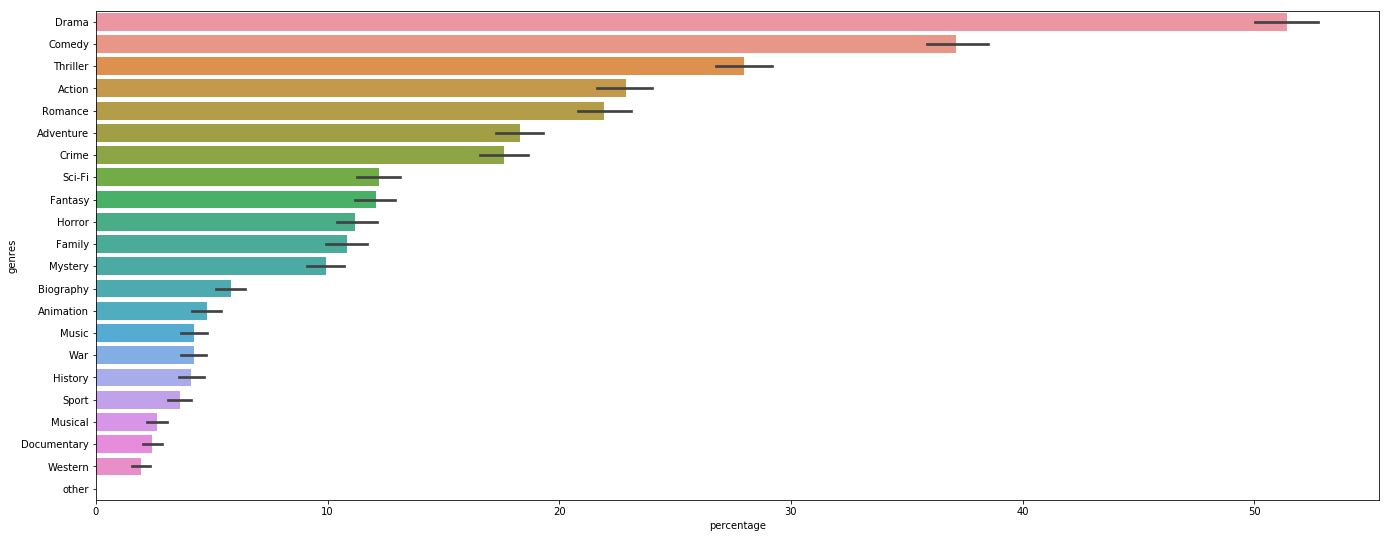

In [270]:
f, ax = plt.subplots(figsize=(23, 9))
df_genres = movie_metadata_cleaned[[x for x in movie_metadata_cleaned.columns if "genres_" in x]].stack().reset_index()
df_genres = df_genres.drop("level_0",axis=1)
df_genres.columns = ["genres","percentage"]
df_genres["genres"] = df_genres["genres"].apply(lambda x: x.split("_")[1])
df_genres["percentage"] = df_genres["percentage"]*100

sns.barplot(data=df_genres,
              y="genres",x="percentage");



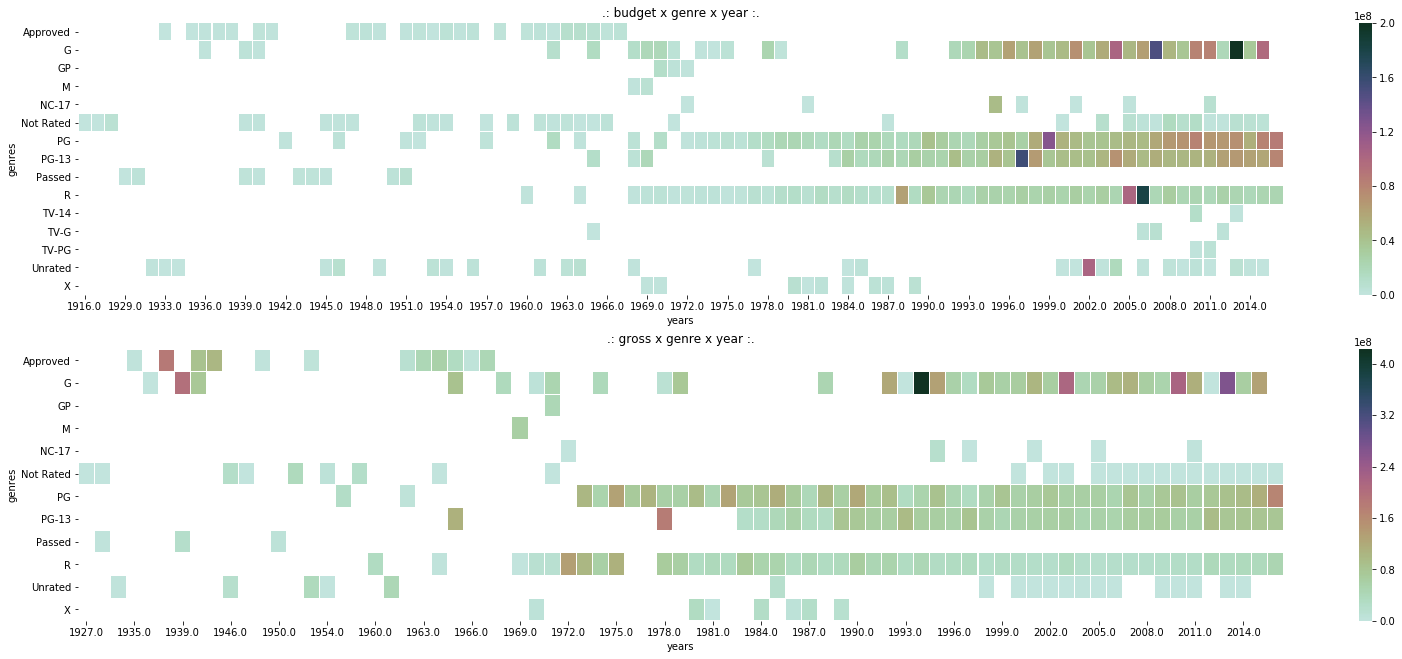

In [278]:
# this relies on giving each movie a single "main" genre


genre_year = movie_metadata.groupby(['content_rating', 'title_year']).mean().sort_index()
df_gyBudget = genre_year.pivot_table(index=['content_rating'], columns=['title_year'], values='budget', aggfunc=np.mean)
df_gyGross = genre_year.pivot_table(index=['content_rating'], columns=['title_year'], values='gross', aggfunc=np.mean)
f, [axA, axB] = plt.subplots(figsize=(27, 11), nrows=2)
cmap = sns.cubehelix_palette(start=1.5, rot=1.5, as_cmap=True)
sns.heatmap(df_gyBudget, xticklabels=3, cmap=cmap, linewidths=0.05, ax=axA)
sns.heatmap(df_gyGross, xticklabels=3, cmap=cmap, linewidths=0.05, ax=axB)
axA.set_title('.: budget x genre x year :.')
axA.set_xlabel('years')
axA.set_ylabel('genres')
axB.set_title('.: gross x genre x year :.')
axB.set_xlabel('years')
axB.set_ylabel('genres')
plt.show()

In [ ]:
## Sankey diagram via Matplotlib!



####################
# make connections #
####################
d_genre = {}
def connect(row):
    global d_genre
    genre = row['genre']
    cgenres = row['cgenres']
    if genre not in d_genre:
        d_cgenres = dict(zip(cgenres, [1]*len(cgenres)))
        d_genre[genre] = d_cgenres
    else:
        for cgenre in cgenres:
            if cgenre not in d_genre[genre]:
                d_genre[genre][cgenre] = 1
            else:
                d_genre[genre][cgenre] += 1
                
df_genre.apply(connect, axis = 1)
l_genre = list(d_genre.keys())
l_genre.sort()
###########################
# find largest connection #
###########################
cmax = 0
for key in d_genre:
    for e in d_genre[key]:
        if d_genre[key][e] > cmax:
            cmax = d_genre[key][e]
#########################
# visualize connections #
#########################
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
color = cm.get_cmap('rainbow')
f, ax = plt.subplots(figsize = (23, 13))

codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]

X, Y = 1, 1
wmin, wmax = 1, 32
amin, amax = 0.1, 0.25
getPy = lambda x: Y*(1 - x/len(l_genre))
for i, genre in enumerate(l_genre):
    yo = getPy(i)
    ax.text(0, yo, genre, ha = 'right')
    ax.text(X, yo, genre, ha = 'left')
    for cgenre in d_genre[genre]:
        yi = getPy(l_genre.index(cgenre))
        verts = [(0.0, yo), (X/4, yo), (2*X/4, yi), (X, yi)]
        path = Path(verts, codes)
        r, g, b, a = color(i/len(l_genre))
        width = wmin + wmax*d_genre[genre][cgenre]/cmax
        alpha = amin + amax*(1 - d_genre[genre][cgenre]/cmax)
        patch = patches.PathPatch(path, facecolor = 'none', edgecolor = (r, g, b), lw = width, alpha = alpha)
        ax.add_patch(patch)

ax.grid(False)
ax.set_xlim(0.0, X)
ax.set_ylim(0.0, Y + 1/len(l_genre))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [ ]:
https://www.kaggle.com/ankitjha/comparing-regression-models

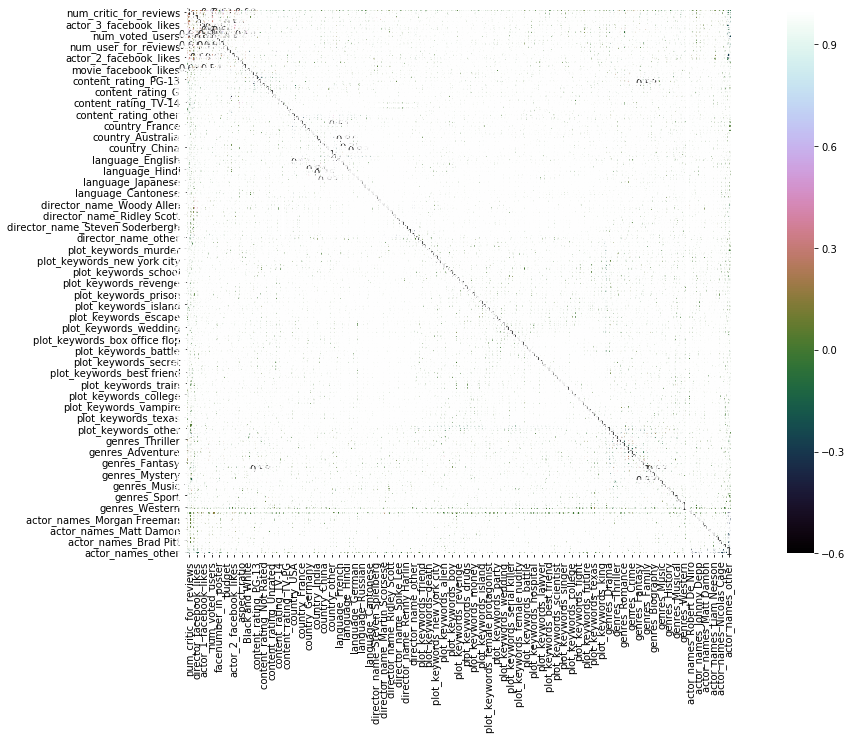

In [279]:
# GETTING Correllation matrix
corr_mat=movie_metadata_cleaned.corr(method='pearson')
plt.figure(figsize=(20,10));
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix');

In [ ]:
https://www.kaggle.com/tanetboss/beginner-binary-classification-for-nice-movie

<Figure size 720x720 with 0 Axes>

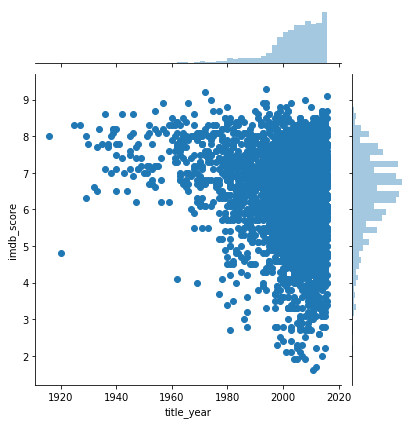

In [285]:
plt.figure(figsize = (10,10));
sns.jointplot(x="title_year", y="imdb_score", data=movie_metadata_cleaned);


<Figure size 720x720 with 0 Axes>

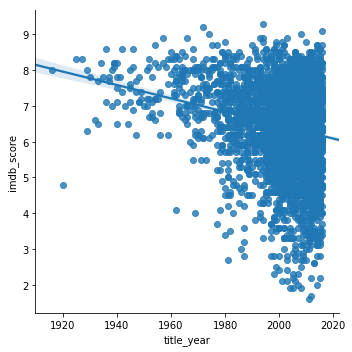

In [136]:
plt.figure(figsize = (10,10));
sns.lmplot(x="title_year", y="imdb_score", data=movie_metadata_cleaned);

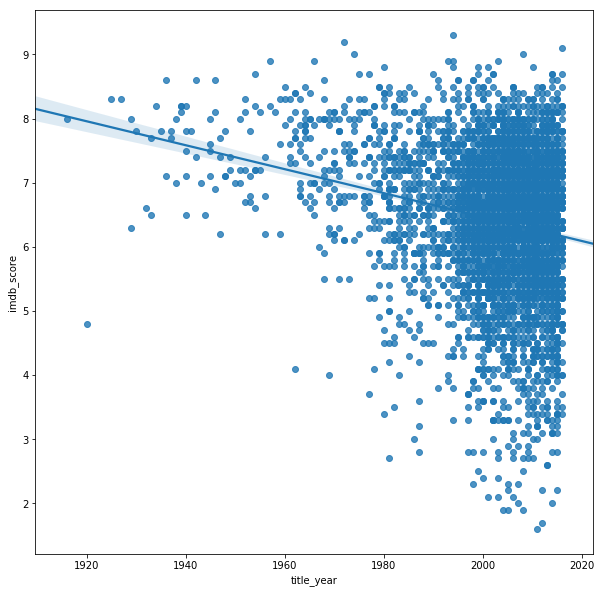

In [286]:
plt.figure(figsize = (10,10));
sns.regplot(x="title_year", y="imdb_score", data=movie_metadata_cleaned);

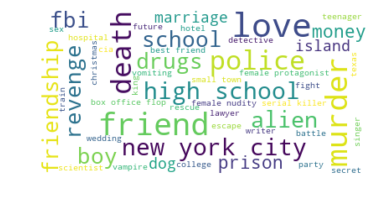

In [311]:
# https://www.datacamp.com/community/tutorials/wordcloud-python
# could force shapes via image masks

kw_dict = {plot_keywords:movie_metadata_cleaned["plot_keywords_"+plot_keywords].sum().astype('int') for plot_keywords in plot_keyword_list}

wordcloud= WordCloud(background_color='White', max_words=100,max_font_size=40, relative_scaling=.5).generate_from_frequencies({k:kw_dict[k] for k in list(kw_dict.keys())[0:100]})
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [314]:
[x for x in movie_metadata_cleaned.columns if "genre" in x]

['genres_Drama',
 'genres_Comedy',
 'genres_Thriller',
 'genres_Action',
 'genres_Romance',
 'genres_Adventure',
 'genres_Crime',
 'genres_Sci-Fi',
 'genres_Fantasy',
 'genres_Horror',
 'genres_Family',
 'genres_Mystery',
 'genres_Biography',
 'genres_Animation',
 'genres_Music',
 'genres_War',
 'genres_History',
 'genres_Sport',
 'genres_Musical',
 'genres_Documentary',
 'genres_Western',
 'genres_other']

In [316]:

genre_dict

{'Drama': 2594,
 'Comedy': 1872,
 'Thriller': 1411,
 'Action': 1153,
 'Romance': 1107,
 'Adventure': 923,
 'Crime': 889,
 'Sci-Fi': 616,
 'Fantasy': 610,
 'Horror': 565,
 'Family': 546,
 'Mystery': 500,
 'Biography': 293,
 'Animation': 242,
 'Music': 214,
 'War': 213,
 'History': 207,
 'Sport': 182,
 'Musical': 132,
 'Documentary': 121,
 'Western': 97}

In [320]:
movie_metadata["genres"].apply(lambda x: len(x.split("|"))).value_counts()

3    1628
2    1355
4     981
1     633
5     349
6      75
7      18
8       4
Name: genres, dtype: int64

In [346]:
genre_dict = {genre:movie_metadata_cleaned["genres_"+genre].sum().astype('int') for genre in genre_list}

def find_most_specific_sub_genre(genre_string):
    genre_array = genre_string.split("|")
    for excpt in ["Game-Show", 'Reality-TV', 'News', 'Short','Film-Noir']:
        if excpt in genre_array:
            genre_array.remove(excpt)
       
        
        
    if len(genre_array) ==1:
        return genre_array[0]
    elif len(genre_array) >1:
        
#         gs = movie_metadata["genres"].loc[0].split("|")
        frequency_array = [genre_dict[x] for x in genre_array]
        return genre_array[frequency_array.index(min(frequency_array))]        
        
    elif len(genre_array) ==0:
        return np.nan # or raise Exception?? I guess make an option
    

In [352]:
movie_metadata_cleaned["specific_genre"] = movie_metadata["genres"].apply(lambda x: find_most_specific_sub_genre(x))
movie_metadata_cleaned["specific_genre"].value_counts()

Crime          581
Romance        529
Mystery        474
Horror         408
Comedy         401
Sci-Fi         294
Family         252
Drama          237
Fantasy        218
Animation      193
History        176
Sport          172
Adventure      171
Music          169
Musical        130
Documentary    121
War            121
Biography      117
Western         97
Action          95
Thriller        87
Name: specific_genre, dtype: int64

In [349]:
genre_dict

{'Drama': 2594,
 'Comedy': 1872,
 'Thriller': 1411,
 'Action': 1153,
 'Romance': 1107,
 'Adventure': 923,
 'Crime': 889,
 'Sci-Fi': 616,
 'Fantasy': 610,
 'Horror': 565,
 'Family': 546,
 'Mystery': 500,
 'Biography': 293,
 'Animation': 242,
 'Music': 214,
 'War': 213,
 'History': 207,
 'Sport': 182,
 'Musical': 132,
 'Documentary': 121,
 'Western': 97}

In [330]:
g = sns.pairplot(iris, hue="species", palette="husl")

'Fantasy'

In [356]:
movie_metadata.columns[movie_metadata.dtypes!=object]+

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes'],
      dtype='object')

In [49]:
movie_metadata_cleaned["imbd_score_rough"] = pd.qcut(movie_metadata_cleaned["imdb_score"],3).cat.rename_categories(["Low","Medium","High"])

In [47]:
numerical_rows = list(movie_metadata.columns[movie_metadata.dtypes!=object])
numerical_rows.remove("imdb_score")
numerical_rows = numerical_rows+["imbd_score_rough"]

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


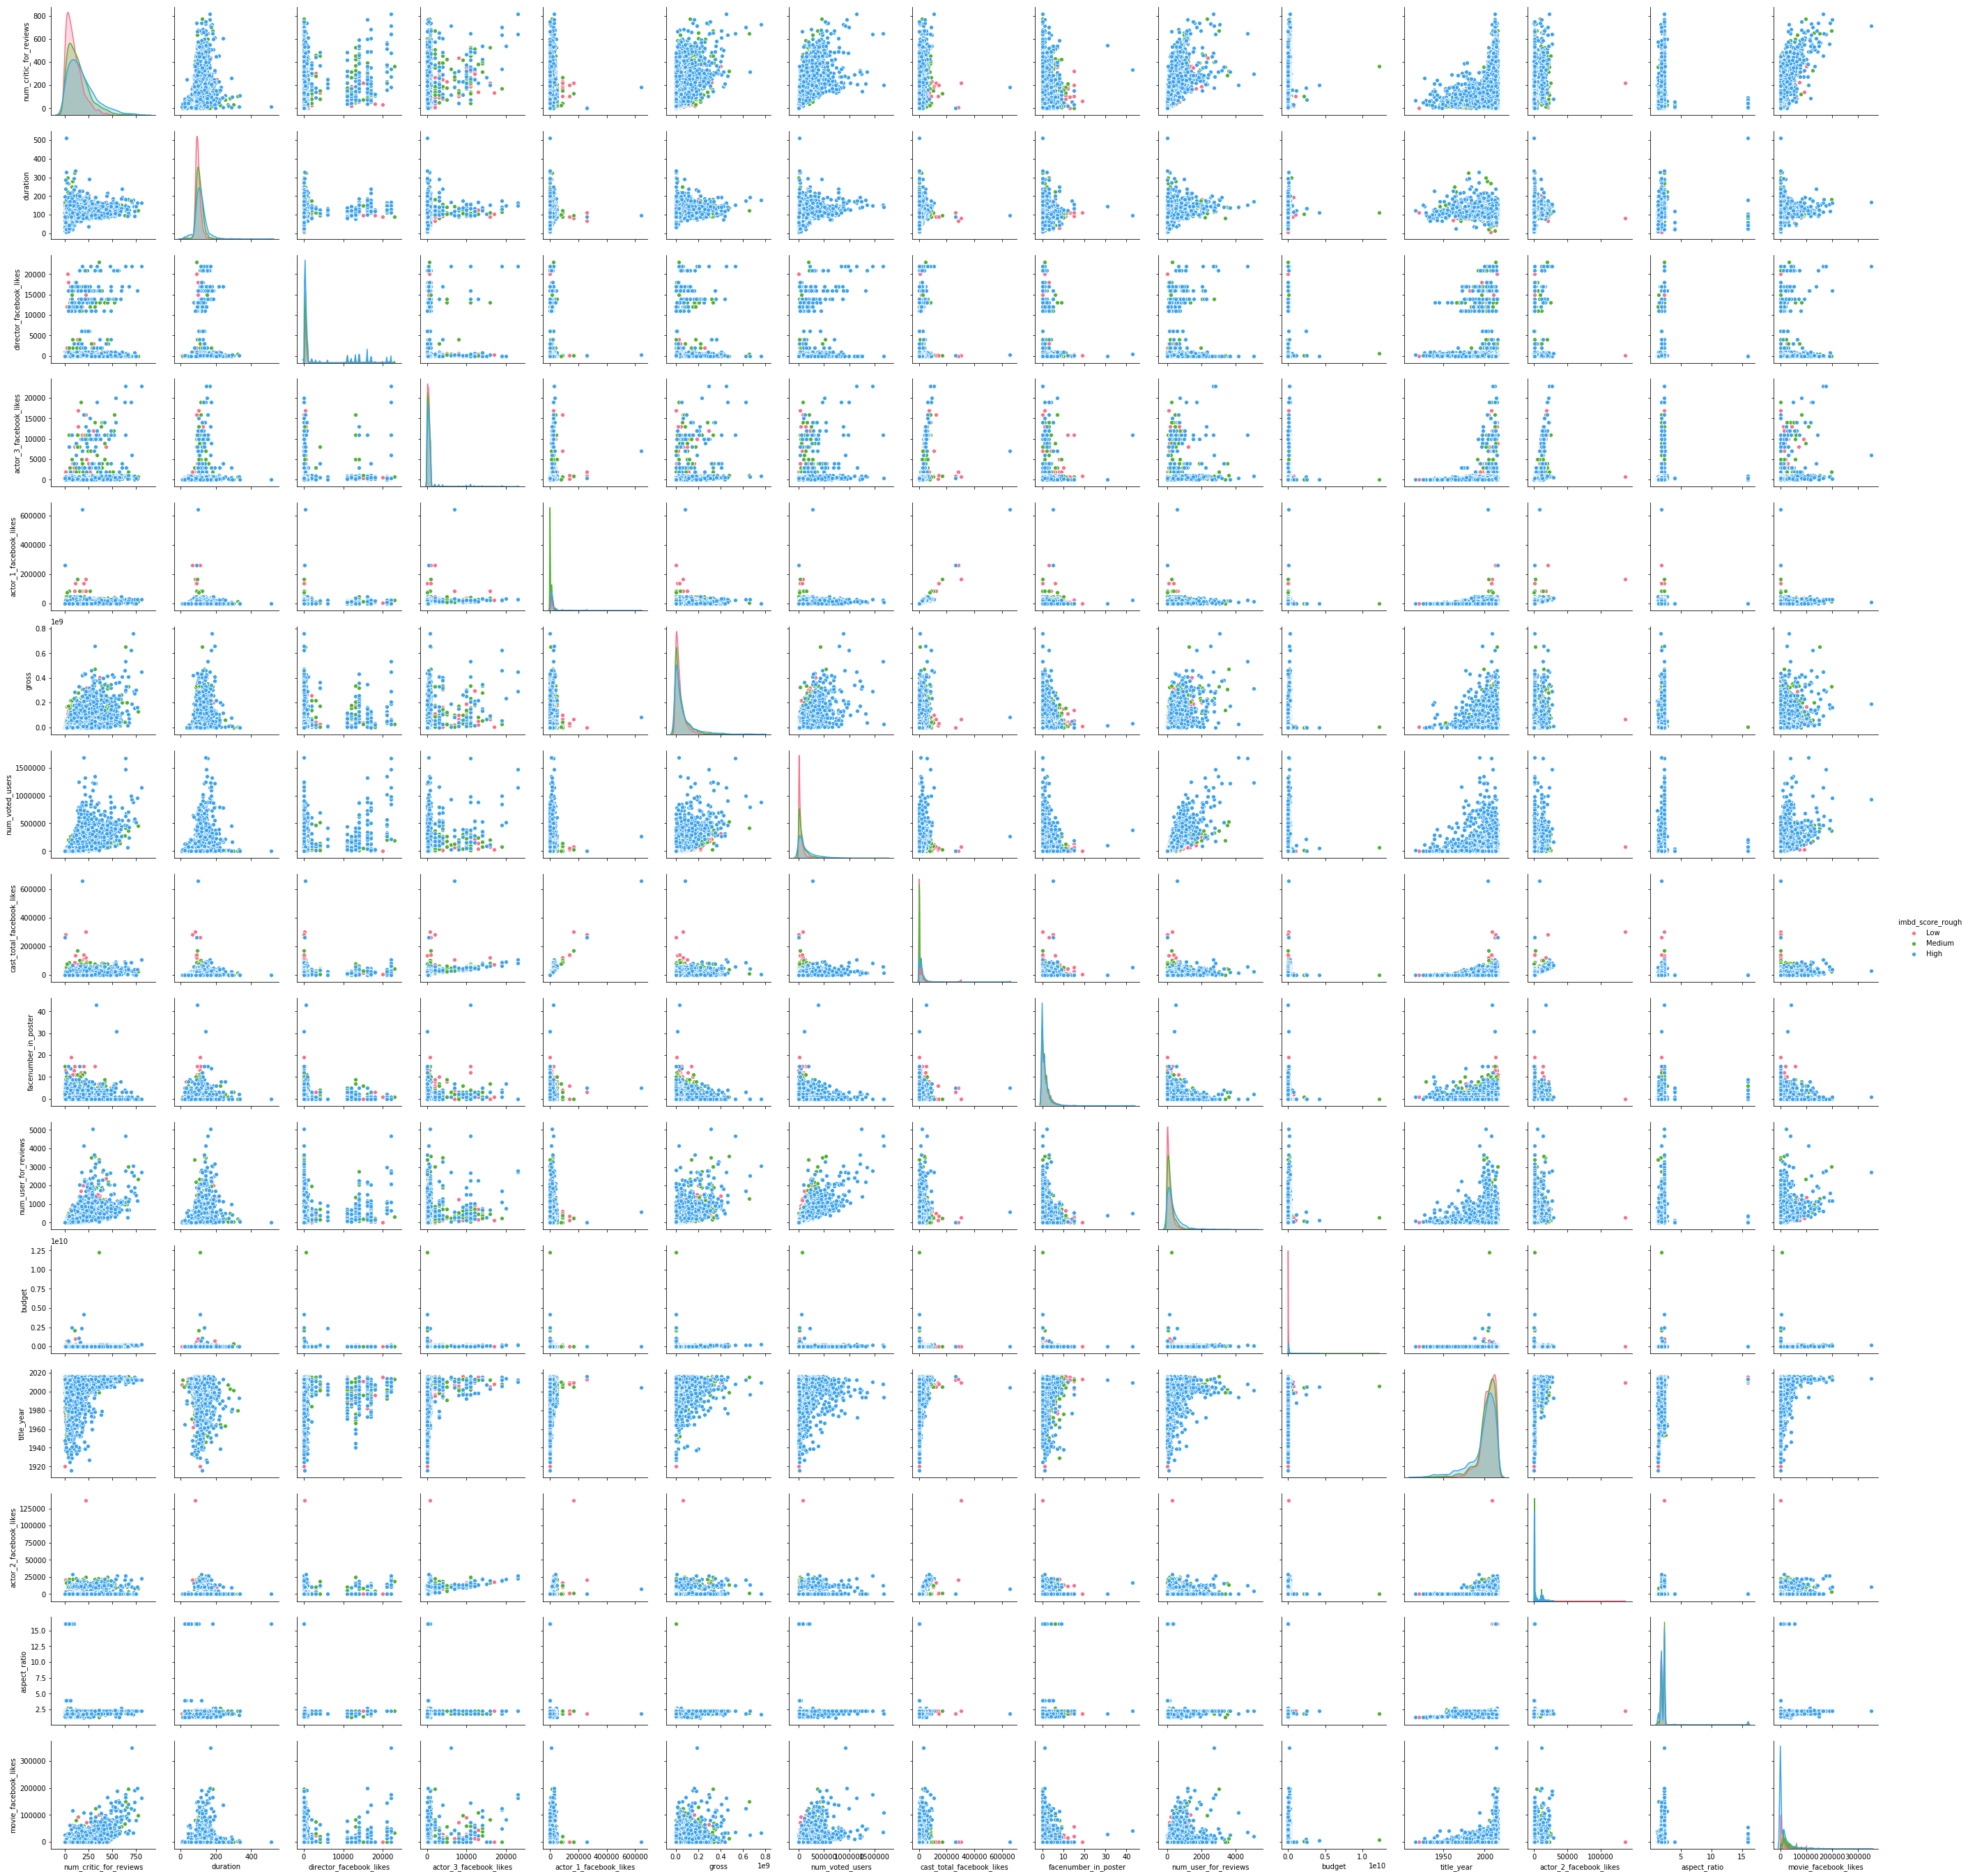

In [50]:
g = sns.pairplot( data = movie_metadata_cleaned[ numerical_rows ],
                  hue = "imbd_score_rough",
                  palette="husl")

In [131]:
scatter_matrix(movie_metadata_cleaned[ numerical_rows ],alpha=0.2, figsize=(20, 20), diagonal='kde')

NameError: name 'scatter_matrix' is not defined

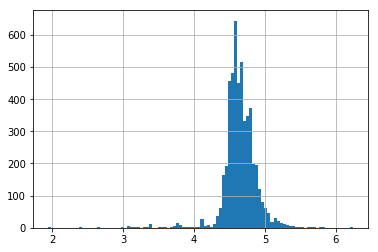

In [92]:
movie_metadata_cleaned["duration"].apply(lambda x: np.log(x)).hist(bins=100);

In [52]:
from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3);
    plt.suptitle(ser.name)
    return xt_std
    
    

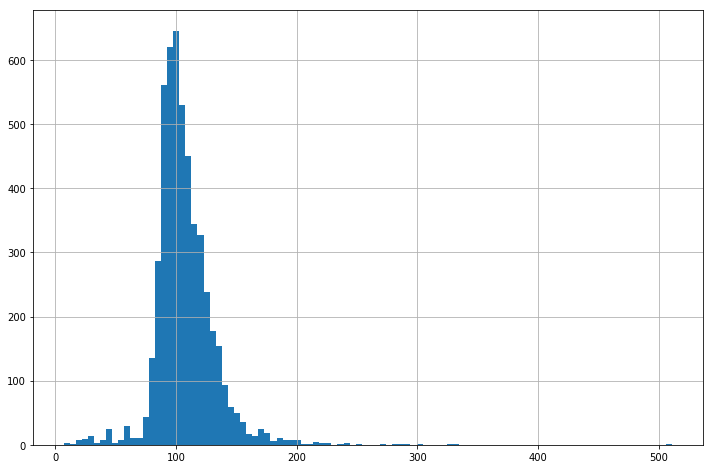

In [97]:
movie_metadata_cleaned["duration"].hist(bins=100, figsize=(12,8))

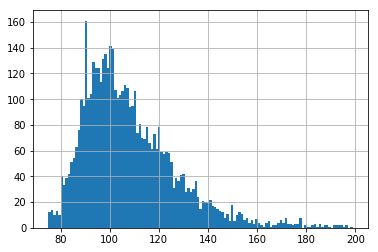

In [103]:
duration_tails_removed = movie_metadata_cleaned["duration"].dropna()
duration_tails_removed = duration_tails_removed[ (duration_tails_removed>=75) & (duration_tails_removed<200) ]
duration_tails_removed.hist(bins=125);

In [110]:
duration_tails_removed.min()

75.0

array([ 2.34570406,  2.20207968,  1.76358884, ..., -2.52706843,
       -0.28018834, -1.05678795])

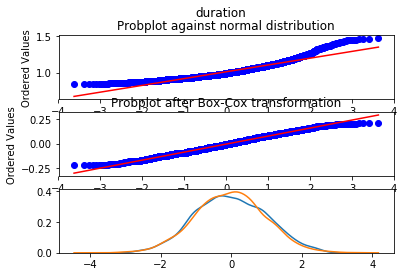

In [119]:
box_cox_normalise( duration_tails_removed/200, offset=.1)
# box_cox_normalise(ser, offset = 3, bw='scott')

array([ 2.60227673,  2.31270042,  1.60354035, ..., -1.34029049,
       -0.24525295, -0.68388025])

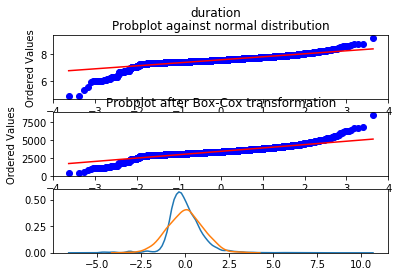

In [93]:
box_cox_normalise( movie_metadata_cleaned["duration"].dropna().apply(lambda x: np.log(x)), offset=1)
# box_cox_normalise(ser, offset = 3, bw='scott')

array([ 2.57081114,  2.28768734,  1.59219563, ..., -1.3415167 ,
       -0.2394158 , -0.67902083])

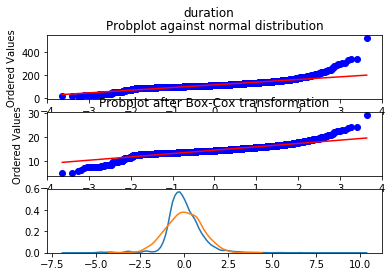

In [59]:
box_cox_normalise( movie_metadata_cleaned["duration"].dropna(), offset=1)
# box_cox_normalise(ser, offset = 3, bw='scott')

In [60]:
granularity = 50
duration_uniform = pd.qcut(movie_metadata_cleaned["duration"].dropna().rank(method='first'), q=granularity, labels=range(0,granularity))

array([ 1.51044716,  1.45836783,  1.40595207, ..., -1.91386277,
       -0.12088908, -1.02866489])

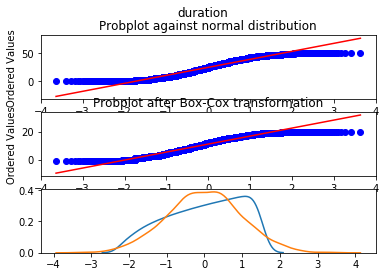

In [70]:
box_cox_normalise(duration_uniform.astype('float'), offset=.1)
# box_cox_normalise(ser, offset = 3, bw='scott')

In [86]:
from scipy.stats import norm

duration_discrete_normal = duration_uniform.apply(lambda x: norm.ppf((x+.5)/50))

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


array([ 2.31529069,  1.87888706,  1.64694582, ..., -1.93267363,
       -0.16813419, -0.8832192 ])

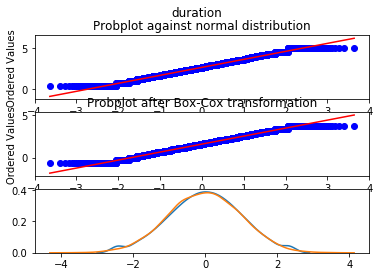

In [90]:
box_cox_normalise(duration_discrete_normal, offset=5)
# box_cox_normalise(ser, offset = 3, bw='scott')

In [85]:
duration_discrete_normal

In [ ]:
g=sns.FacetGrid(dframe.groupby("country").filter(lambda x: len(x) > 20), col = "country")
g.map(plt.scatter,"imdb_score","duration")

In [ ]:
https://towardsdatascience.com/imdb-score-prediction-401e952b5542
    
Series.str.get_dummies(sep='|')

https://medium.com/@jae.huang111/imdb-data-machine-learning-predicting-movie-gross-2113513513bb
    
I love the decision tree visualisation!

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


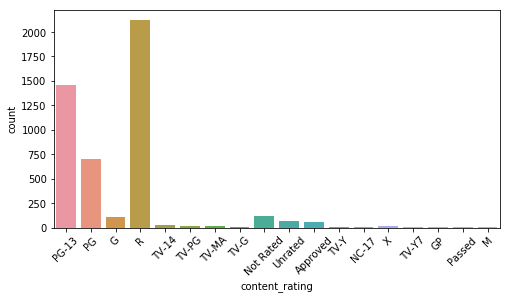

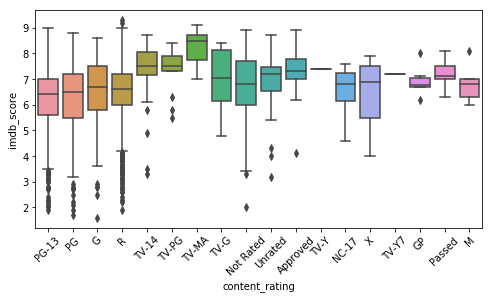

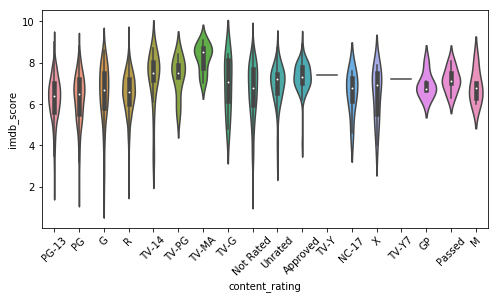

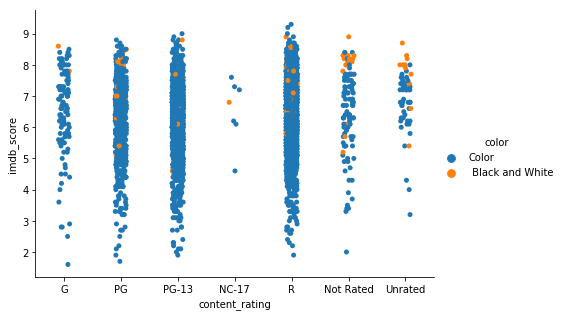

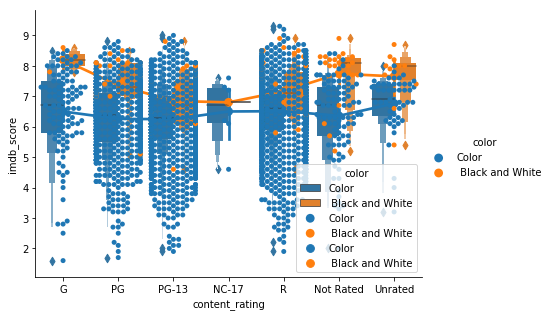

In [133]:
# https://www.kaggle.com/alaaawad/imdb-dataset-exploration

plt.figure(figsize = (8, 4))
sns.countplot(x = 'content_rating', data = movie_metadata)
xt = plt.xticks(rotation=45)

plt.figure(figsize = (8, 4))
sns.boxplot(x = 'content_rating', y = 'imdb_score',  data = movie_metadata)
xt = plt.xticks(rotation=45)

plt.figure(figsize = (8, 4))
sns.violinplot(x = 'content_rating', y = 'imdb_score',  data = movie_metadata)
xt = plt.xticks(rotation=45)

sns.catplot('content_rating', 'imdb_score', hue = 'color', estimator = np.mean, data = movie_metadata, 
             height = 4.5, aspect = 1.4, order = ['G', 'PG', 'PG-13', 'NC-17', 'R', 'Not Rated', 'Unrated']);

sns.factorplot('content_rating', 'imdb_score', hue = 'color', estimator = np.mean, data = movie_metadata, 
             height = 4.5, aspect = 1.4, order = ['G', 'PG', 'PG-13', 'NC-17', 'R', 'Not Rated', 'Unrated']);

sns.swarmplot('content_rating', 'imdb_score', hue = 'color', data = movie_metadata, 
             order = ['G', 'PG', 'PG-13', 'NC-17', 'R', 'Not Rated', 'Unrated']);

sns.boxenplot('content_rating', 'imdb_score', hue = 'color', data = movie_metadata, 
             order = ['G', 'PG', 'PG-13', 'NC-17', 'R', 'Not Rated', 'Unrated']);


In [ ]:
# Nice plotly graphs

https://www.kaggle.com/artempanin/actors-clusterization-by-popularity
https://www.kaggle.com/cristianpb/movies-analysis-with-plotly
https://www.kaggle.com/jacoblea/data-analysis-for-tmdb-5000-movies

In [9]:
# https://github.com/seanabu/movie_data_scraper/blob/master/the_numbers_scrape.ipynb
import requests
from bs4 import BeautifulSoup
import string
# import urlparse 
from urllib.parse import urlparse
import re
import locale
import pickle
from dateutil import parser

def get_details(url, movie):
    print(movie)
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page) 
    
    try:
        rt_score = soup.find(id="movie_ratings").find_all('a')[2].br.next_sibling
        rt_score = str(rt_score)
        match = re.search(r'\d+', rt_score)
        critic_score = int(match.group())
    except:
        critic_score = ""
    
    rows = soup.find_all('table')[2].find_all('tr')
    for row in rows:
        if row.find_all('td')[0].text == u'Production\xa0Budget:':
            budget = row.find_all('td')[1].text
            locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )
            prod_budget = locale.atoi(budget.strip("$"))
        if row.find_all('td')[0].text =='Domestic Releases:':
            wide = '(Wide)' in row.find_all('td')[1].text
            release =  row.find_all('td')[1]
            release = str(release.text).split(" (")
            release_dt = parser.parse(release[0])
            company = str(row.find_all('td')[1].find('a').text)
        if row.find_all('td')[0].text == u'MPAA\xa0Rating:':
            rating = str(row.find_all('td')[1].find('a').text)
        if row.find_all('td')[0].text == u'Production\xa0Method:':
            prod_method = str(row.find_all('td')[1].find('a').text)
        if row.find_all('td')[0].text =='Running Time:':
            runtime = row.find_all('td')[1].text
            runtime = runtime.replace(' minutes','')
            run_time = int(runtime)
        if row.find_all('td')[0].text =='Source:':
            source = str(row.find_all('td')[1].find('a').text)
        if row.find_all('td')[0].text =='Genre:':
            genre = str(row.find_all('td')[1].find('a').text)

    try:
        movies_dict[movie]['rating']= rating
    except: 
        movies_dict[movie]['rating']= ""
    try:
        movies_dict[movie]['budget']= prod_budget
    except: 
        movies_dict[movie]['budget']= ""
    try:
        movies_dict[movie]['budget']= prod_budget
    except:
        movies_dict[movie]['budget']= ""
    try:
        movies_dict[movie]['method']= prod_method
    except:
        movies_dict[movie]['method']= ""
    try:
        movies_dict[movie]['source']= source
    except:
        movies_dict[movie]['source']= ""
    try:    
        movies_dict[movie]['genre']= genre
    except:
        movies_dict[movie]['genre']= ""
    try:
        movies_dict[movie]['distribution']= company
    except:
        movies_dict[movie]['distribution']= ""
    try:
        movies_dict[movie]['runtime']= run_time
    except: 
        movies_dict[movie]['runtime']= ""
    try:
        movies_dict[movie]['critic_rating']= critic_score
    except:
        movies_dict[movie]['critic_rating']= ""
        
def get_weekly(url, movie):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page) 
    rows = soup.find_all(id = 'box_office_chart')[-1].find_all('tr')
    weekly_list = []
    for row in rows[1:]:
        row_list = []
        col = row.text
        for cell in row.find_all('td'):
            info = filter(lambda x: x in string.printable, cell.text)
            info = str(info)
            row_list.append(info)
        weekly_list.append(row_list)

    movies_dict[movie]['weekend_boxoffice']= weekly_list
    
def get_movieid(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page)
    rows = soup.find('table').find_all('tr')[1:201]
    for row in rows:
        try:
            title = list(filter(lambda x: x in string.printable, row.a.text))
            title = "".join(title)
            movies_dict[title]= {}
            movie_id = row.a['href']
            par = urlparse.urlparse(movie_id).path.lstrip("/movie")
            movies_dict[title]['id']= par
        except:
            print(row)
            
def create_dict(year):
    url = 'http://www.the-numbers.com/market/%d/top-grossing-movies' % (year)
    while year < 2015:
        get_movieid(url)
        year += 1
        
def scrape(movies_dict):
    for movie in movies_dict: 
        summary_url = 'http://www.the-numbers.com/movie/%s#tab=summary' % (str(movies_dict[movie]['id']))
        try:
            get_details(summary_url, movie)
        except:
            print("------Could not get details for " + movie)
        boxoffice_url = 'http://www.the-numbers.com/movie/%s#tab=box-office' % (str(movies_dict[movie]['id']))
        try:
            get_weekly(boxoffice_url, movie)
        except: 
            print("-----Could not get weekly for " + movie)
        pickle_count += 1
        


In [12]:
url = 'https://www.the-numbers.com/movie/budgets/all'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page)
rows = soup.find('table').find_all('tr')[1:201]
for row in rows:
    try:
        title = "".join(list(filter(lambda x: x in string.printable, row.a.text)))
#         title = "".join(title)
#         movies_dict[title]= {}
        movie_id = row.a['href']
        par = urlparse.urlparse(movie_id).path.lstrip("/movie")
#         movies_dict[title]['id']= par
        print(title, par)
    except:
        print(row)


<tr><td class="data">1</td>
<td><a href="/box-office-chart/daily/2009/12/18">Dec 18, 2009</a></td>
<td><b><a href="/movie/Avatar#tab=summary">Avatar</a></b></td>
<td class="data">$425,000,000</td>
<td class="data">$760,507,625</td>
<td class="data">$2,776,345,279</td>
</tr>
<tr><td class="data">2</td>
<td><a href="/box-office-chart/daily/2011/05/20">May 20, 2011</a></td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-On-Stranger-Tides#tab=summary">Pirates of the Caribbean: On Stranger Tides</a></b></td>
<td class="data">$410,600,000</td>
<td class="data">$241,063,875</td>
<td class="data">$1,045,663,875</td>
</tr>
<tr><td class="data">3</td>
<td><a href="/box-office-chart/daily/2015/05/01">May 1, 2015</a></td>
<td><b><a href="/movie/Avengers-Age-of-Ultron#tab=summary">Avengers: Age of Ultron</a></b></td>
<td class="data">$330,600,000</td>
<td class="data">$459,005,868</td>
<td class="data">$1,403,013,963</td>
</tr>
<tr><td class="data">4</td>
<td><a href="/box-office-chart/daily/2017/

In [16]:
rows[0]

<tr><td class="data">1</td>
<td><a href="/box-office-chart/daily/2009/12/18">Dec 18, 2009</a></td>
<td><b><a href="/movie/Avatar#tab=summary">Avatar</a></b></td>
<td class="data">$425,000,000</td>
<td class="data">$760,507,625</td>
<td class="data">$2,776,345,279</td>
</tr>

In [10]:
movies_dict= {}

create_dict(2003)

# scrape(movies_dict)

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

<tr>
<td class="data">1</td>
<td><b><a href="/movie/Finding-Nemo#tab=summary">Finding Nemo</a></b></td>
<td><a href="/box-office-chart/daily/2003/05/30">May 30, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$339,714,367</td>
<td class="data">56,337,374</td>
</tr>
<tr>
<td class="data">2</td>
<td><b><a href="/movie/Pirates-of-the-Caribbean-The-Curse-of-the-Black-Pearl#tab=summary">Pirates of the Caribbean: T…</a></b></td>
<td><a href="/box-office-chart/daily/2003/07/09">Jul 9, 2003</a></td>
<td><a href="/market/distributor/Walt-Disney">Walt Disney</a></td>
<td><a href="/market/genre/Adventure">Adventure</a></td>
<td class="data">$305,411,224</td>
<td class="data">50,648,627</td>
</tr>
<tr>
<td class="data">3</td>
<td><b><a href="/movie/Lord-of-the-Rings-The-Return-of-the-King-The#tab=summary">The Lord of the Rings: The …</a></b></td>
<td><a href="/box-office-chart/daily/2003/12/1

In [11]:
movies_dict

{'Finding Nemo': {},
 'Pirates of the Caribbean: T': {},
 'The Lord of the Rings: The ': {},
 'The Matrix Reloaded': {},
 'Bruce Almighty': {},
 'X-Men 2': {},
 'Elf': {},
 'Chicago': {},
 'Terminator 3: Rise of the M': {},
 'Bad Boys II': {},
 'The Matrix Revolutions': {},
 'Anger Management': {},
 'Bringing Down the House': {},
 'Hulk': {},
 '2 Fast 2 Furious': {},
 'Seabiscuit': {},
 'S.W.A.T.': {},
 'Spy Kids 3-D: Game Over': {},
 'Freaky Friday': {},
 'Scary Movie 3': {},
 'The Italian Job': {},
 'How to Lose a Guy in 10 Days': {},
 'American Wedding': {},
 'Daddy Day Care': {},
 'Daredevil': {},
 "Charlie's Angels: Full Thro": {},
 'The Cat in the Hat': {},
 'Legally Blonde 2: Red, Whit': {},
 'The Last Samurai': {},
 'Cheaper by the Dozen': {},
 'Brother Bear': {},
 'Master and Commander: The F': {},
 'Freddy vs. Jason': {},
 "Something's Gotta Give": {},
 'The Texas Chainsaw Massacre': {},
 'School of Rock': {},
 'Old School': {},
 'The Haunted Mansion': {},
 'Kill Bill: Volume

In [161]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  4 22:20:13 2016
@author: Sarick Shah
"""
# -*- coding: utf-8 -*-

# https://github.com/shahsarick/MovieWorldWidePrediction/blob/master/film_scrape2.py

# import urllib2
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re 
from collections import defaultdict 
from pandas import Series, DataFrame 
import numpy as np 
from bs4 import BeautifulSoup
import re 
import sys
sys.setrecursionlimit(20000)
import unidecode
import unicodedata

#%%
def solver(list_of_variables, mpaaRating): 
    list_to_append = []
    for category in list_of_variables: 
        try: 
            if category == 'Rotten Tomatoes':  
                rating_index = mpaaRating.index(category)+3
                rating = mpaaRating[rating_index:rating_index+2]                
                list_to_append.extend([rating])                
            else:
                category = (mpaaRating[mpaaRating.index(category)+1])
                list_to_append.append(category)
                
        except (ValueError, AttributeError):
            #print "category didn't work"
            list_to_append.append(None)            
    return list_to_append
#%%
def make_police_request(url):

    req = urllib.request.Request(
        url, 
        data=None, 
        headers={
            'User-Agent': 'Respectful Scraper Bot'
        }
    )
    return req
url = 'http://www.the-numbers.com/movie/budgets/all'
response = urllib.request.urlopen(make_police_request(url))

#response = urlopen('http://www.the-numbers.com/movie/budgets/all')
main_doc = response.read()
def txt_link_downloader(html_link):
    
    soup = BeautifulSoup(html_link, 'html.parser')
    list_df = []    
    batch = soup.find_all('td')
    counter = 0
    for index,i in enumerate(range(0,len(batch),6)):
        list_df.append( list(map(lambda x: x.get_text(), batch[i:i+6])))
        
        url_end = BeautifulSoup(batch[i+2].encode('utf-8'),'html.parser').find('a').get('href') 
        url = 'http://www.the-numbers.com' + url_end
        list_df[index].append(url)
        
        response = urlopen(make_police_request(url))
        main_doc = response.read()
        soup = BeautifulSoup(main_doc,'html.parser')
    
        mpaaRating = []
        for tr in soup.findAll('tr'): 
            for td in tr.findAll('td'): 
                mpaaRating.append(td.get_text())
        mpaaRating = [unidecode.unidecode(x).strip() for x in mpaaRating]   
        
        list_of_variables = ['Genre:','Running Time:','MPAA Rating:','Production Companies:','Domestic Releases:','Domestic DVD Sales','Domestic Blu-ray Sales','Total Domestic Video Sales','Rotten Tomatoes']
        
        second_page = solver(list_of_variables,mpaaRating)
        list_df[index].extend(second_page)
        
        response = urlopen(make_police_request(url))
        main_doc = response.read()
        soup = BeautifulSoup(main_doc,'html.parser')
        soup = soup.find(text = re.compile('Weekend Box Office Performance')).parent.parent.find('div', attrs = {"id": "box_office_chart"})
        try:
            soup = soup.get_text()
            soup = unicodedata.normalize('NFKD', soup).encode('utf-8').split()[4:35]
            soup.insert(3,'None')
            list_df[index].extend(soup)
        except:
            pass
        
        counter += 1
        #sets upper limit, max is 5230 as of 10/9/2016
        if counter == 2000:
            return DataFrame(list_df)            
import copy
list_df = txt_link_downloader(main_doc)
#%%
df_deepcopy = copy.deepcopy(list_df)
df_deepcopy.to_csv('sarickmovies3.csv', encoding= 'utf-8' )

AttributeError: 'NoneType' object has no attribute 'to_csv'